# Data Formatting
- Correction for Skewed Distributions (Numerical Variables)
- Standardization (Numerical Variables)
- One-Hot Encoding (Categorical Variables)

In [1]:
from datetime import datetime
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
from scipy.stats import skew
from scipy.stats import yeojohnson
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import sys

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

date_format = "%Y-%m-%d"

In [2]:
my_os = platform.system()
print("OS in my system: ",my_os)

if my_os == "Windows":
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

artif_path = path + 'data_artifacts' + slash

OS in my system:  Windows


## Load data

In [3]:
# eikon spx
data_set = pd.read_csv(artif_path + 'data_set_e_spx_1-cleaned.csv', index_col=0)
data_set = data_set.drop(columns=['isin', 'date', 'fy_end_date'])

#data_set.head()
data_set_indexed = data_set.set_index(['ric', 'year'])
data_set_indexed.head()

mapping = pd.read_excel(path.replace('3_data_pre-processing', '1_data_collection') + 'possible_features.xlsx', sheet_name='mapping')

In [4]:
feature_list = pd.DataFrame({'feature': ['debt', 'tass', 'rtass', 'tlia', 'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt',
           'capex', 'ncfo', 'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa', 'ebitmarg', 'shouts', 'mc',
           'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c', 'finlev_c', 'inc_days', 'ipo_days', 'naics', 'tau_cop_3y', 'tau_cop_5y']})

feature_list = feature_list.merge(mapping, on='feature')

In [5]:
# numerical variables
var_num = ['debt', 'tass', 'rtass', 'tlia', 'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt',
           'capex', 'ncfo', 'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa', 'ebitmarg', 'shouts', 'mc',
           'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c', 'finlev_c', 'inc_days', 'ipo_days']

## ----------------------------------------

## Correction for Skewed Distributions (Numerical Variables)
skew(): This function calculates the skewness of a data set, which is a measure of its symmetry. A positive value indicates a right-skewed distribution, a negative value indicates a left-skewed distribution, and a value of 0 indicates a symmetric distribution.

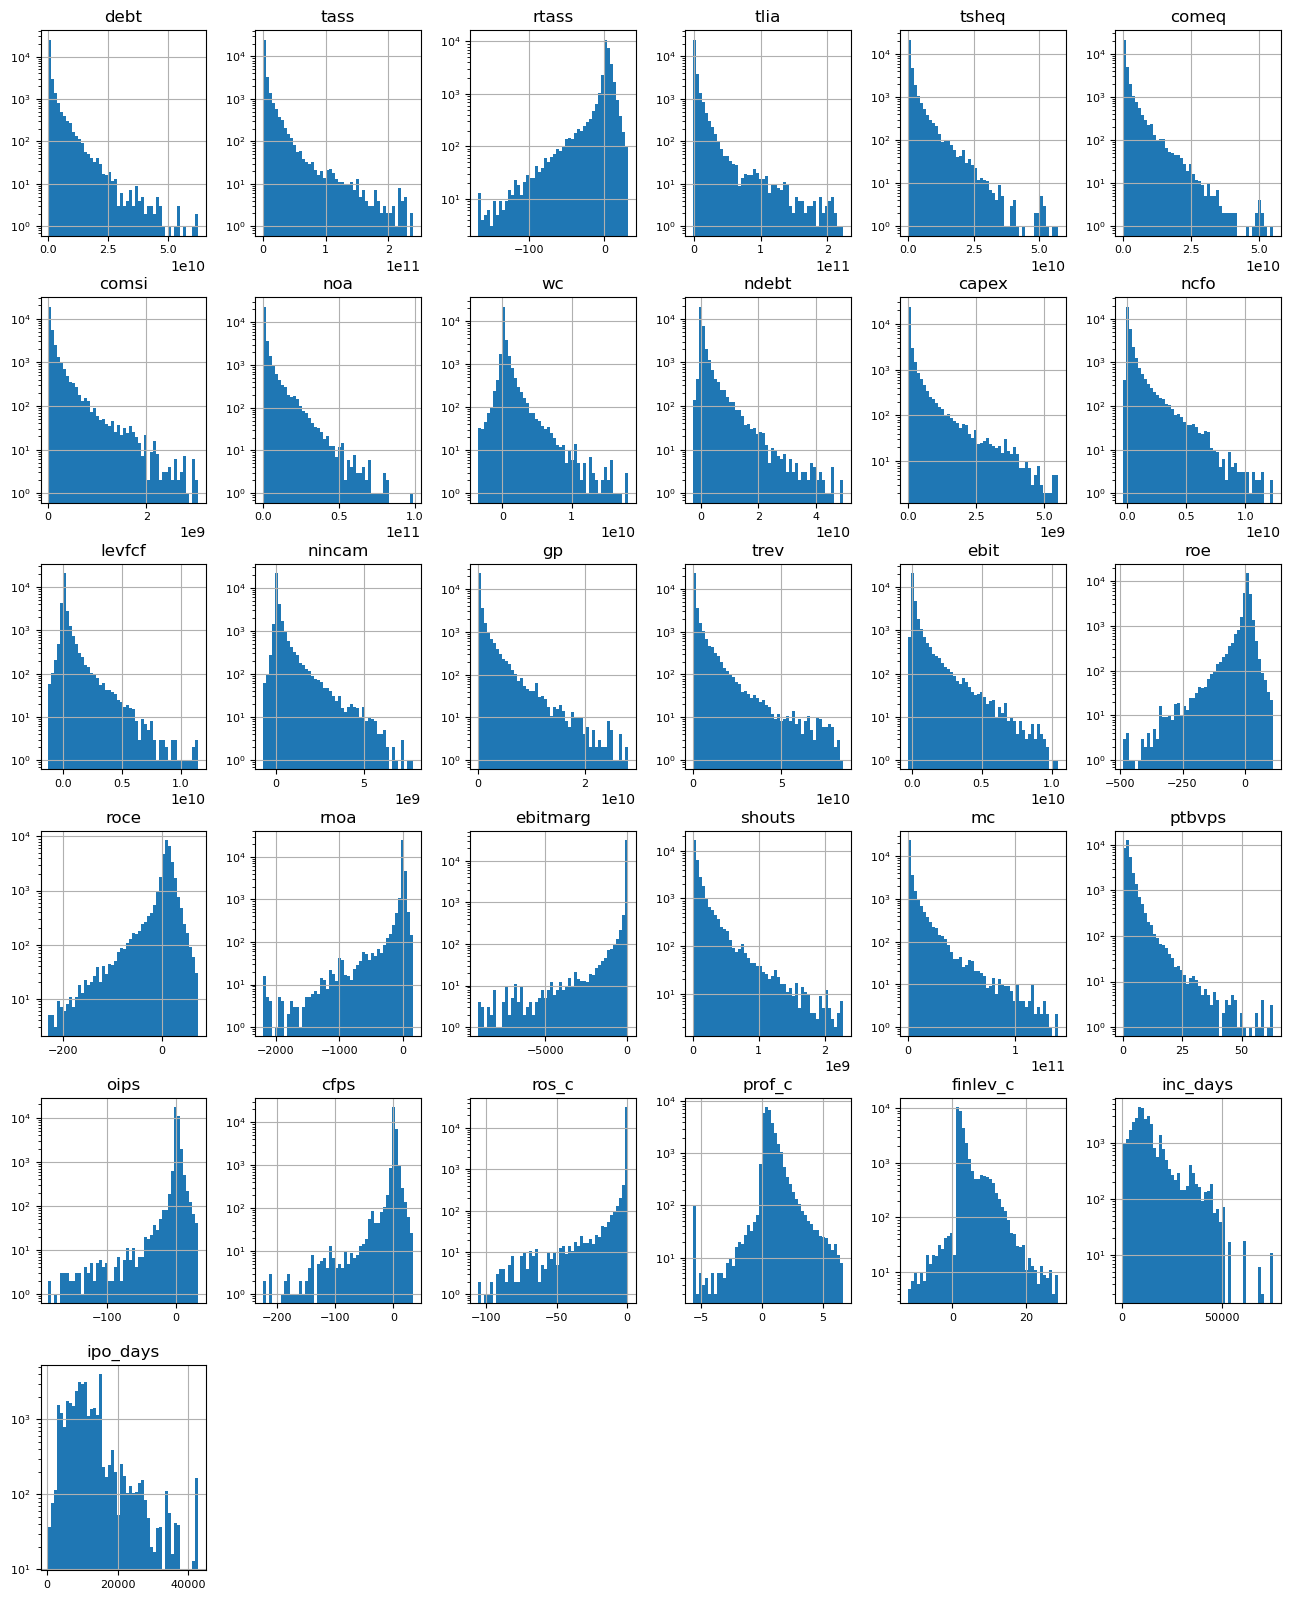

In [6]:
data_set[var_num].hist(figsize=(16, 20), log=True, bins=50, xlabelsize=8, ylabelsize=8);

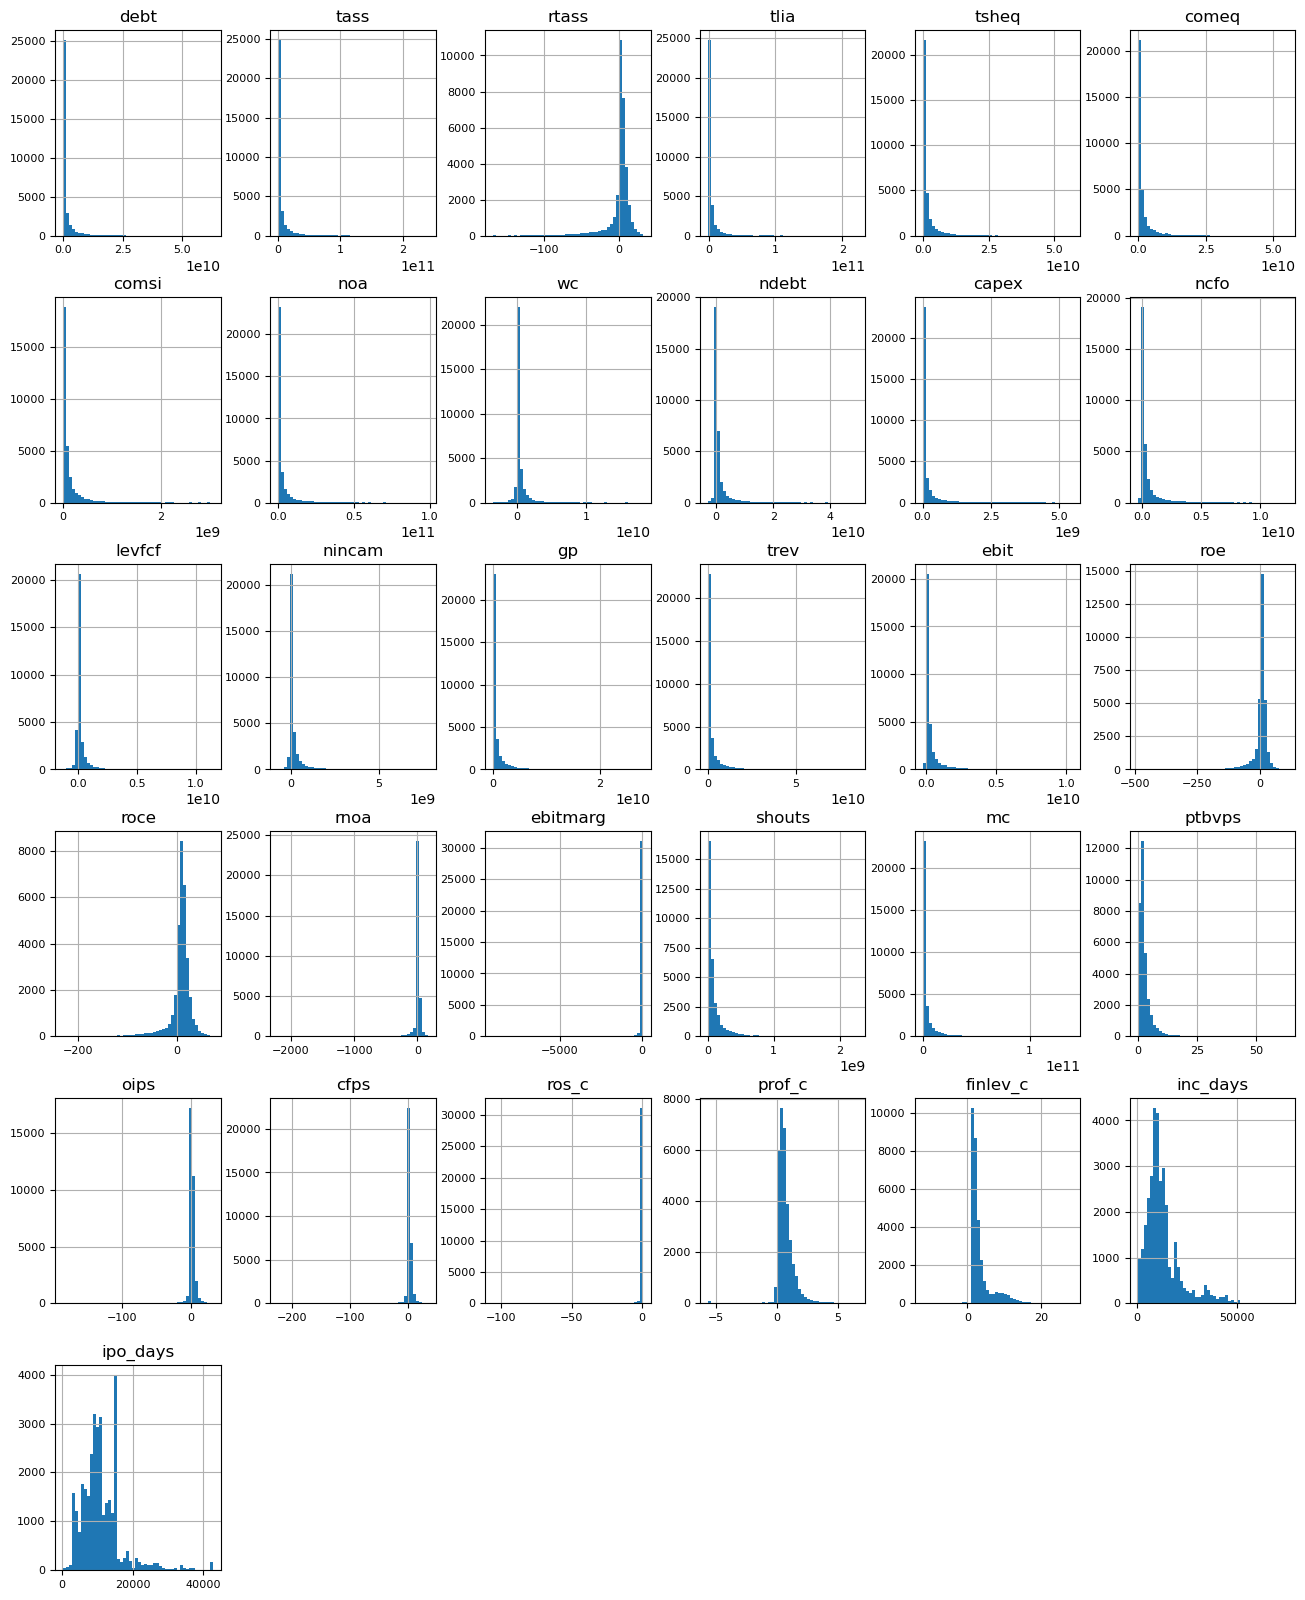

In [7]:
data_set[var_num].hist(figsize=(16, 20), log=False, bins=50, xlabelsize=8, ylabelsize=8);

In [8]:
skewness_per_feature = {'feature':[], 'skewness':[], 'to_correct_low': [], 'to_correct_high': []}

for feature in var_num:
    skewness_per_feature['feature'].append(feature)
    
    skewness = skew(data_set[feature])
    skewness_per_feature['skewness'].append(skewness)
    
    if skewness < -0.5 or skewness > 0.5:
        to_correct_low = True
    else:
        to_correct_low = False
    skewness_per_feature['to_correct_low'].append(to_correct_low)
    
    if skewness < -1 or skewness > 1:
        to_correct_high = True
    else:
        to_correct_high = False
    skewness_per_feature['to_correct_high'].append(to_correct_high)

skewness_per_feature = pd.DataFrame(skewness_per_feature)
display(skewness_per_feature)

,feature,skewness,to_correct_low,to_correct_high
0,debt,6.018540,True,True
1,tass,6.989656,True,True
2,rtass,-3.900635,True,True
3,tlia,8.363308,True,True
4,tsheq,5.013502,True,True
5,comeq,5.017667,True,True
6,comsi,4.704490,True,True
7,noa,4.750542,True,True
8,wc,5.815405,True,True
9,ndebt,5.847985,True,True


**Yeo-Johnson transformation:**

This is also a general transformation that can be applied to data that is skewed and contains negative or positive values. Like the Box-Cox transformation, Yeo-Johnson transformation can be useful when you have a variable that may be exponential, or have outliers in the data. The scipy library have the implementation of this transformation.

In [9]:
data_set_corrected = data_set.copy()

In [10]:
# first correction
for feature in skewness_per_feature[skewness_per_feature['to_correct_low'] == True].feature:
    data_set_corrected[feature] = yeojohnson(data_set_corrected[feature])[0]
    
skewness_per_feature = {'feature':[], 'skewness':[], 'to_correct_low': [], 'to_correct_high': []}

for feature in var_num:
    skewness_per_feature['feature'].append(feature)
    
    skewness = skew(data_set_corrected[feature])
    skewness_per_feature['skewness'].append(skewness)
    
    if skewness < -0.5 or skewness > 0.5:
        to_correct_low = True
    else:
        to_correct_low = False
    skewness_per_feature['to_correct_low'].append(to_correct_low)
    
    if skewness < -1 or skewness > 1:
        to_correct_high = True
    else:
        to_correct_high = False
    skewness_per_feature['to_correct_high'].append(to_correct_high)

skewness_per_feature = pd.DataFrame(skewness_per_feature)
skewness_per_feature[skewness_per_feature['to_correct_low'] == True]

,feature,skewness,to_correct_low,to_correct_high
2,rtass,0.639050,True,False
3,tlia,1.040561,True,True
4,tsheq,3.296695,True,True
5,comeq,3.325335,True,True
7,noa,2.794554,True,True
8,wc,3.742276,True,True
9,ndebt,0.984141,True,False
11,ncfo,2.126678,True,True
12,levfcf,1.796047,True,True
13,nincam,1.894326,True,True


In [11]:
# second correction
for feature in skewness_per_feature[skewness_per_feature['to_correct_low'] == True].feature:
    data_set_corrected[feature] = yeojohnson(data_set_corrected[feature])[0]
    
skewness_per_feature = {'feature':[], 'skewness':[], 'to_correct_low': [], 'to_correct_high': []}

for feature in var_num:
    skewness_per_feature['feature'].append(feature)
    
    skewness = skew(data_set_corrected[feature])
    skewness_per_feature['skewness'].append(skewness)
    
    if skewness < -0.5 or skewness > 0.5:
        to_correct_low = True
    else:
        to_correct_low = False
    skewness_per_feature['to_correct_low'].append(to_correct_low)
    
    if skewness < -1 or skewness > 1:
        to_correct_high = True
    else:
        to_correct_high = False
    skewness_per_feature['to_correct_high'].append(to_correct_high)

skewness_per_feature = pd.DataFrame(skewness_per_feature)
skewness_per_feature[skewness_per_feature['to_correct_low'] == True]

,feature,skewness,to_correct_low,to_correct_high
3,tlia,2.072577,True,True
4,tsheq,3.409294,True,True
5,comeq,3.431408,True,True
7,noa,2.915341,True,True
8,wc,3.758148,True,True
9,ndebt,1.028287,True,True
11,ncfo,2.178077,True,True
12,levfcf,1.828987,True,True
13,nincam,1.932588,True,True
14,gp,2.847592,True,True


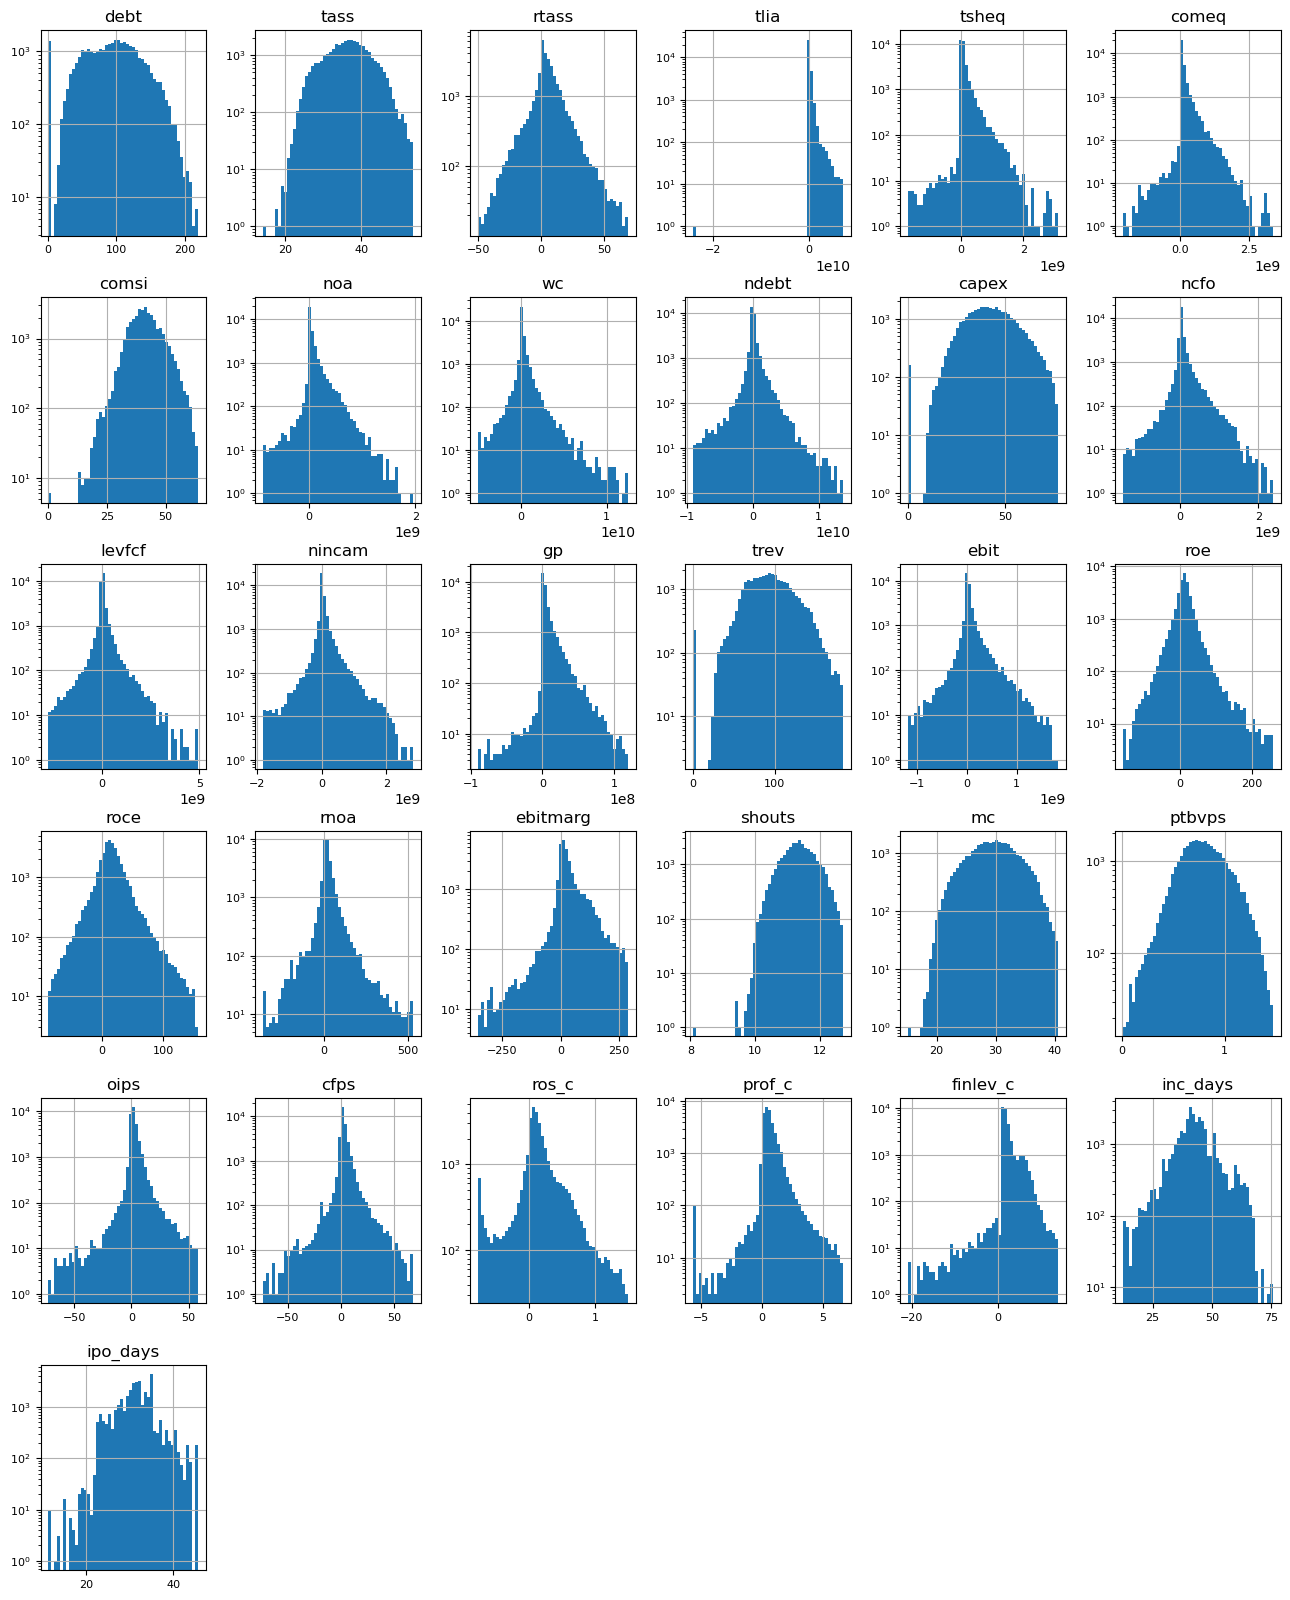

In [12]:
data_set_corrected[var_num].hist(figsize=(16, 20), log=True, bins=50, xlabelsize=8, ylabelsize=8);

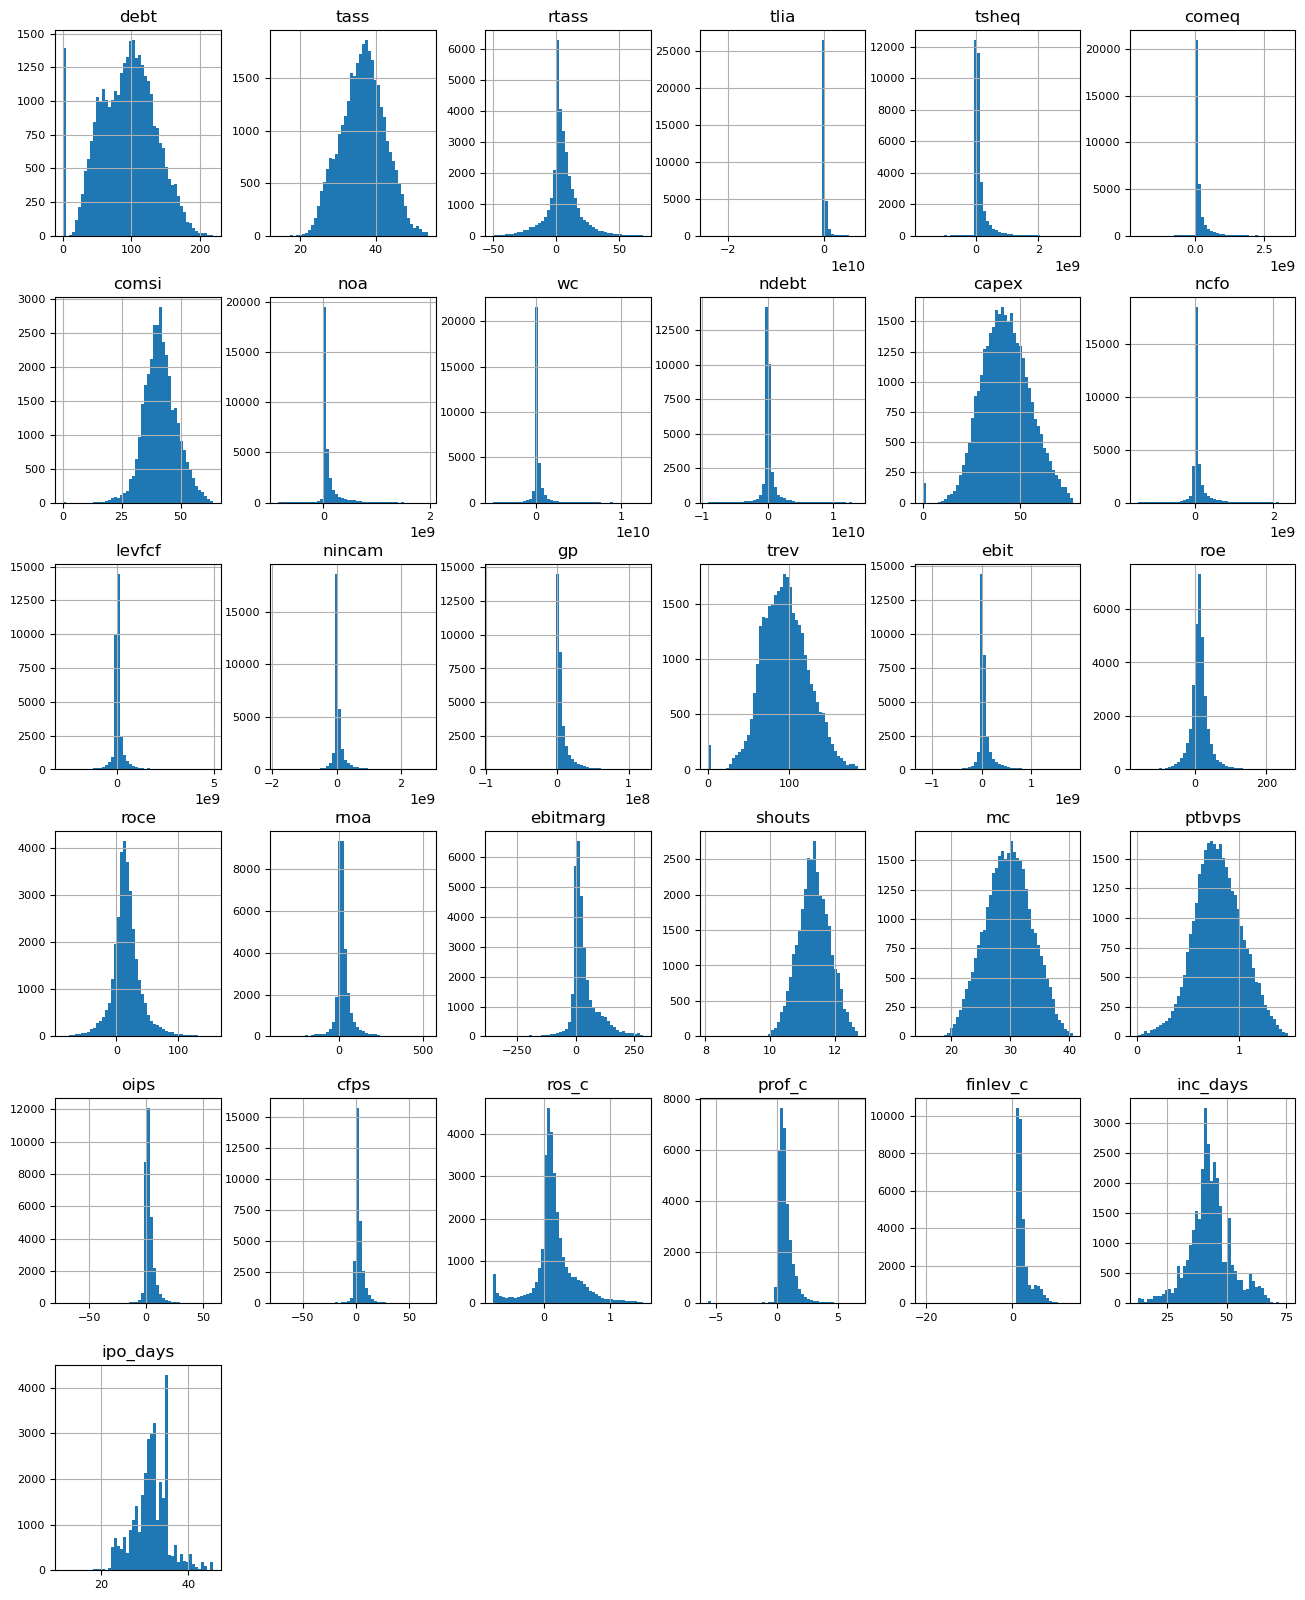

In [13]:
data_set_corrected[var_num].hist(figsize=(16, 20), log=False, bins=50, xlabelsize=8, ylabelsize=8);

### debt

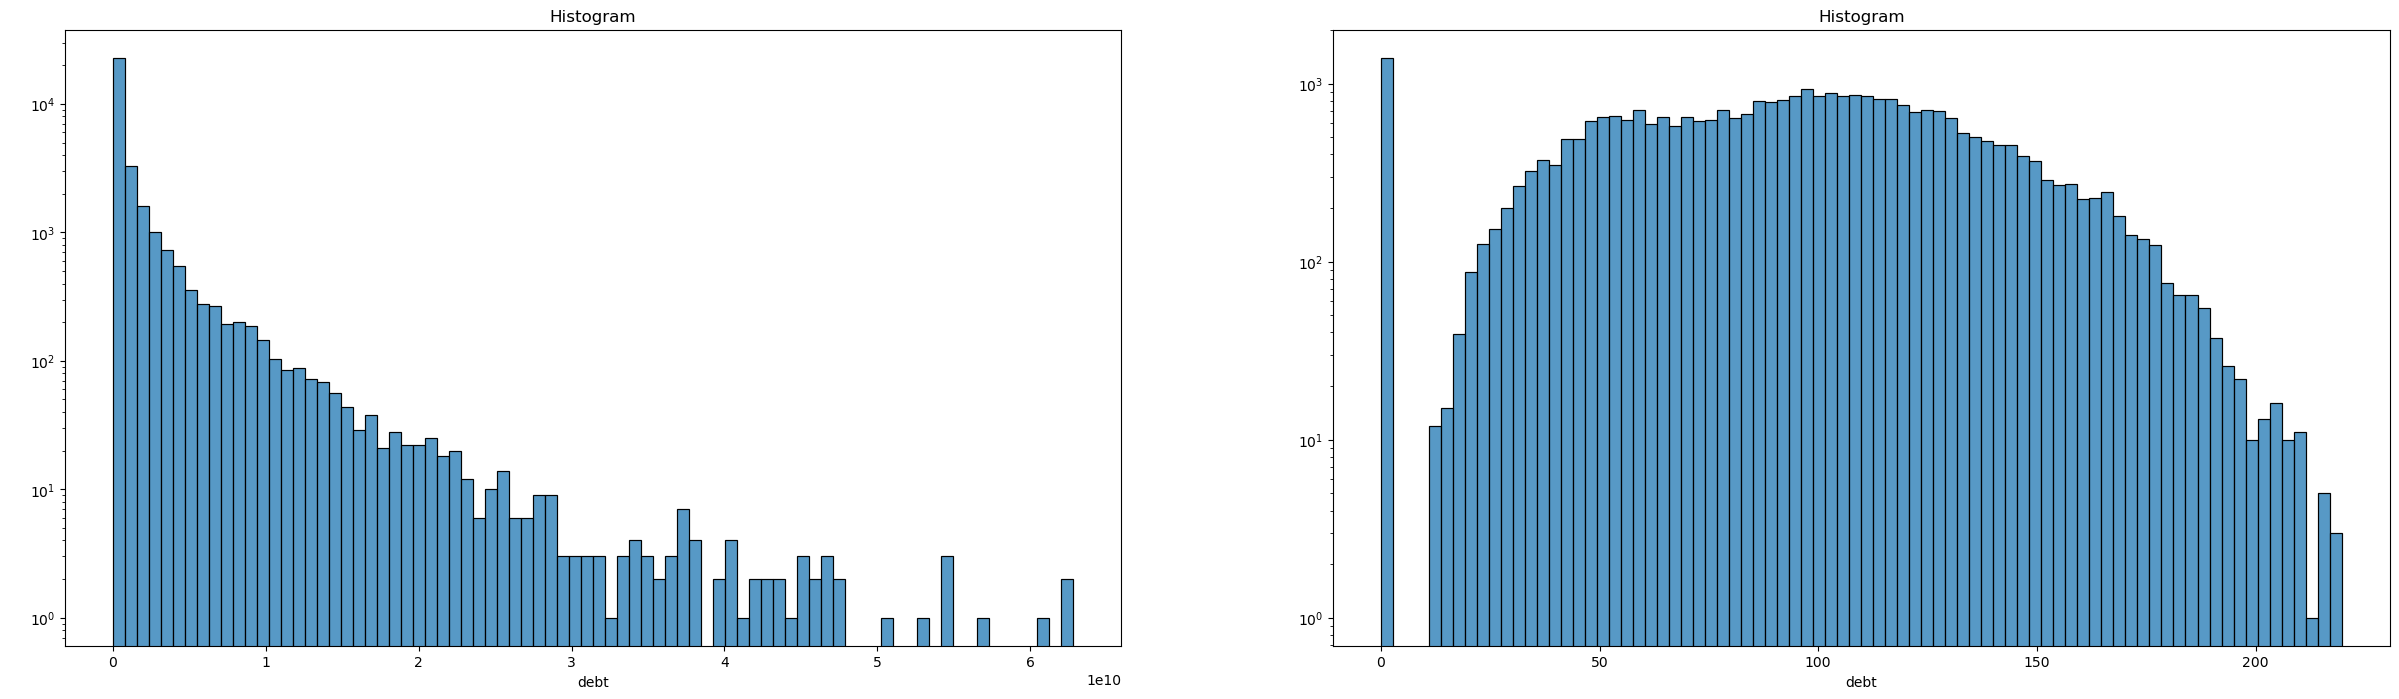

### tass

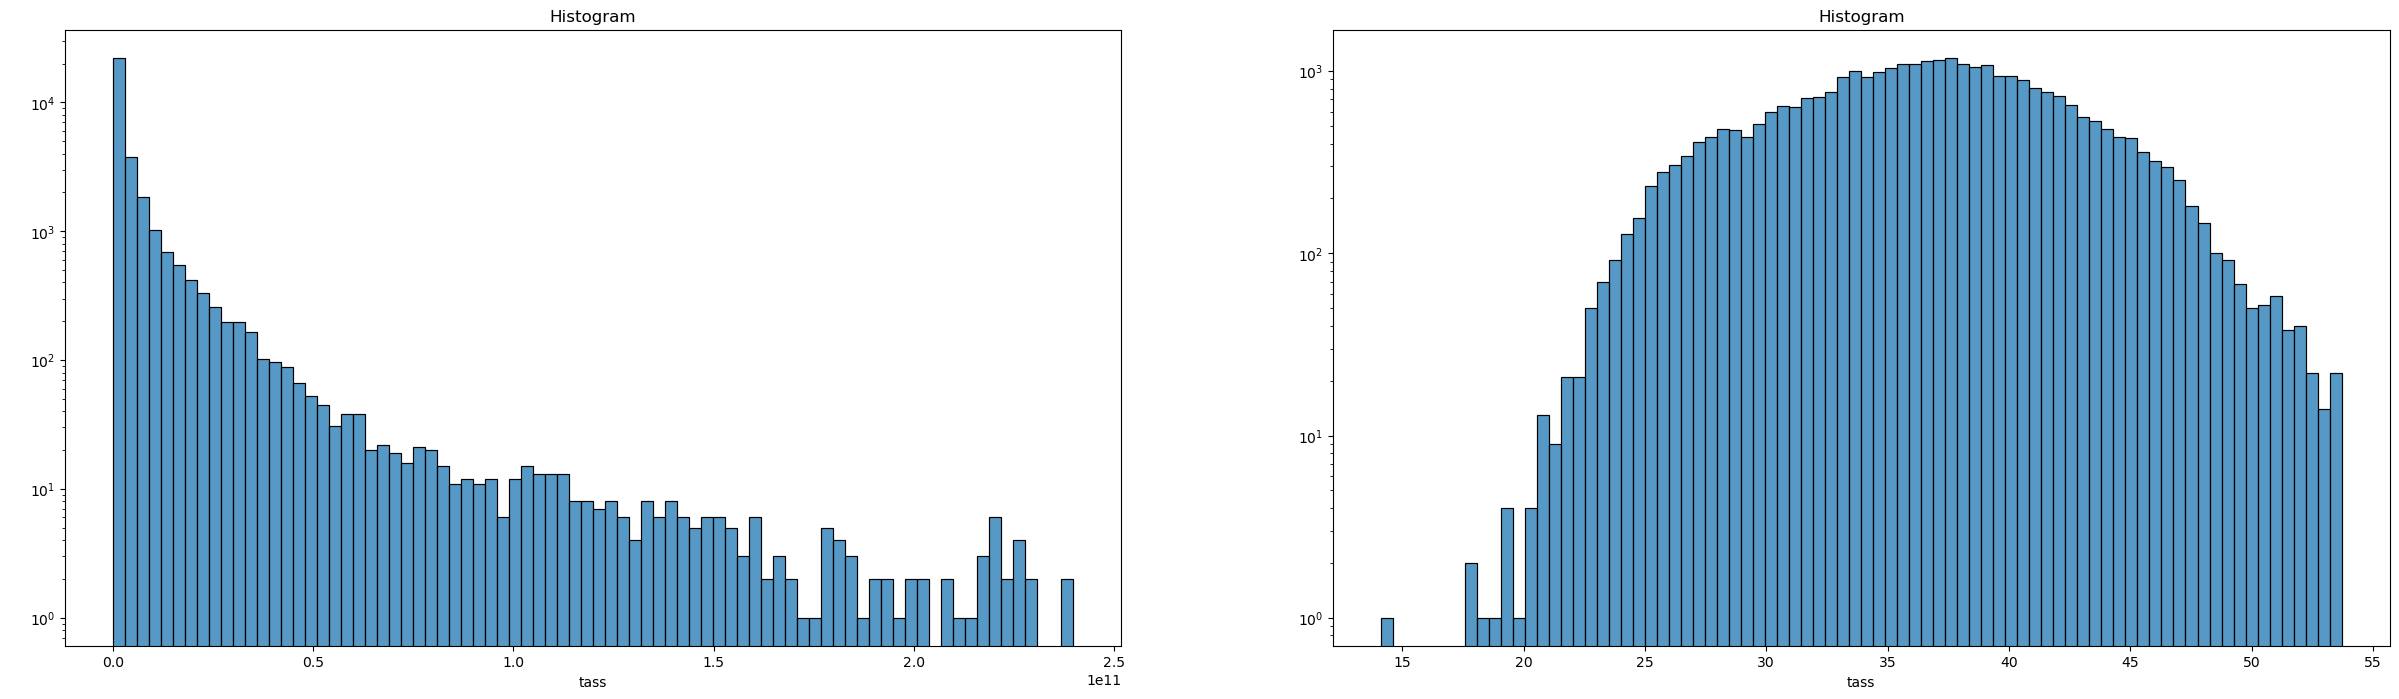

### rtass

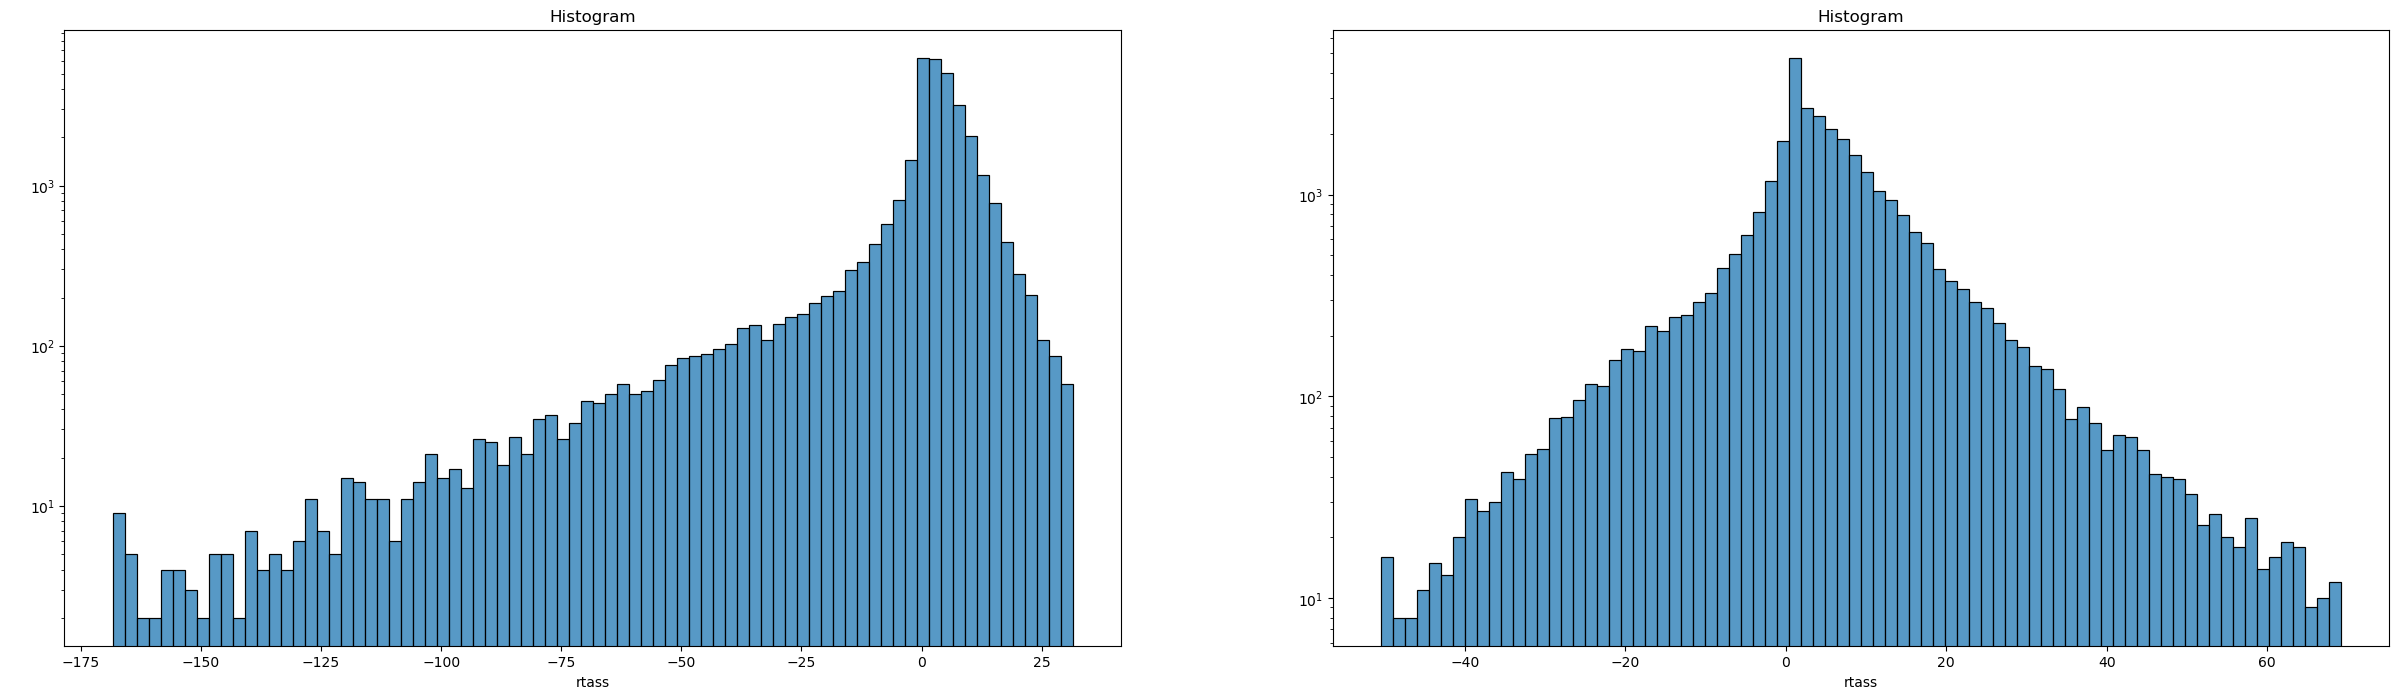

### tlia

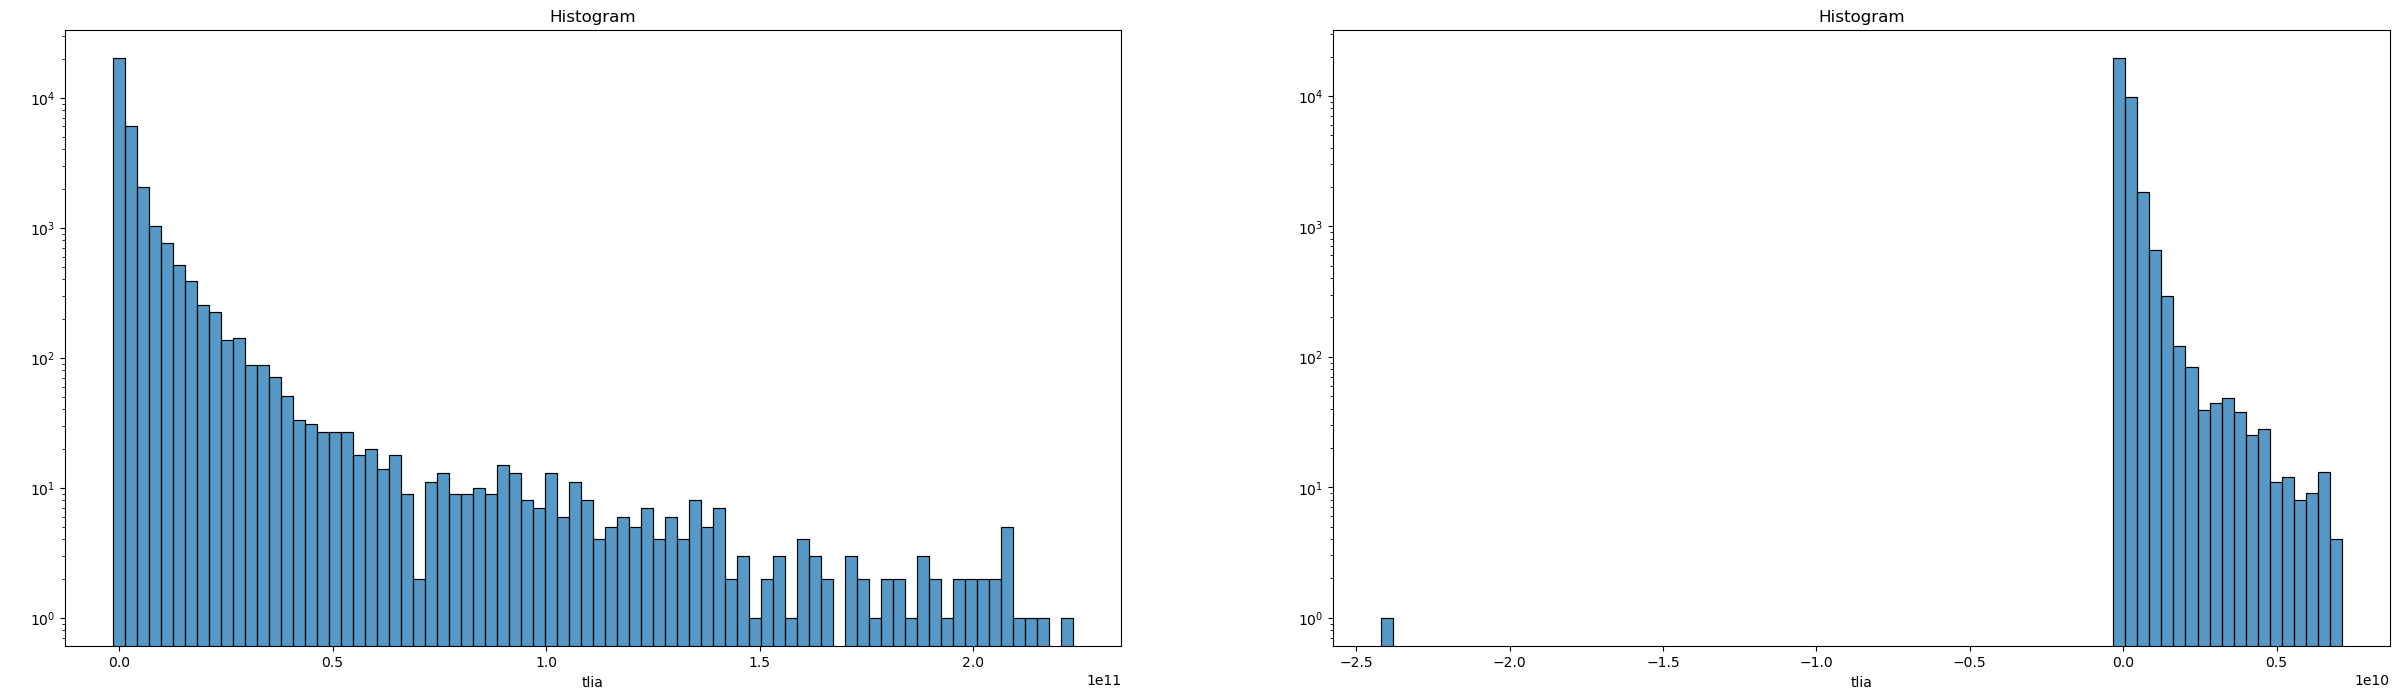

### tsheq

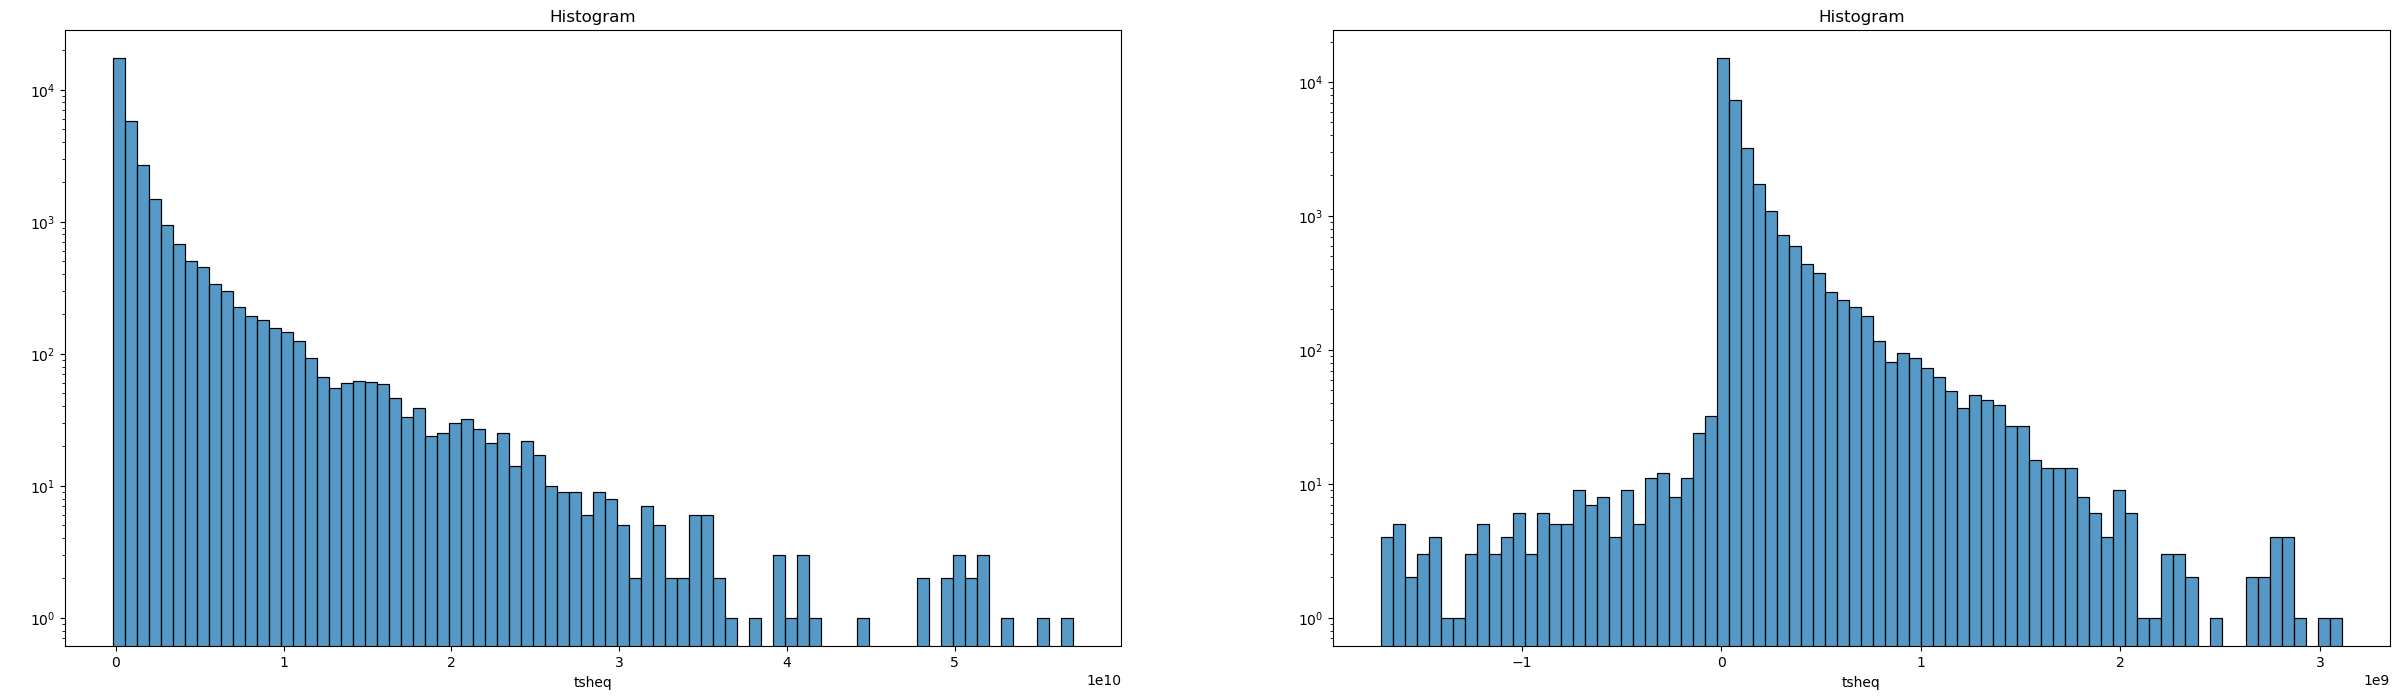

### comeq

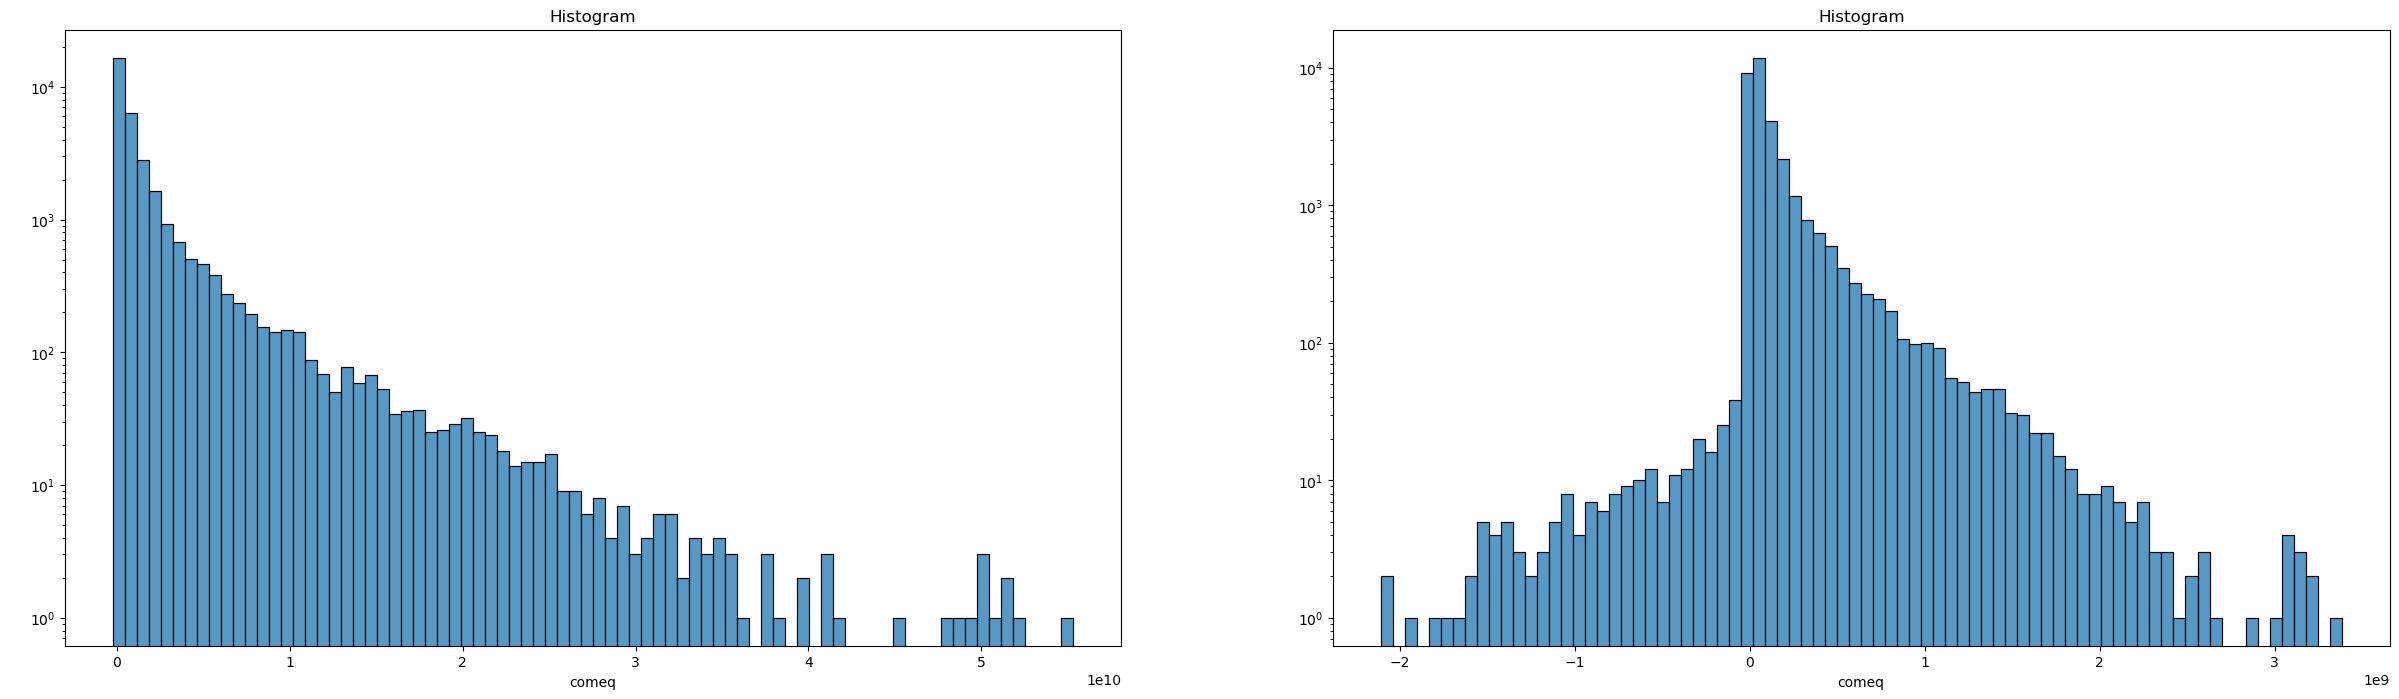

### comsi

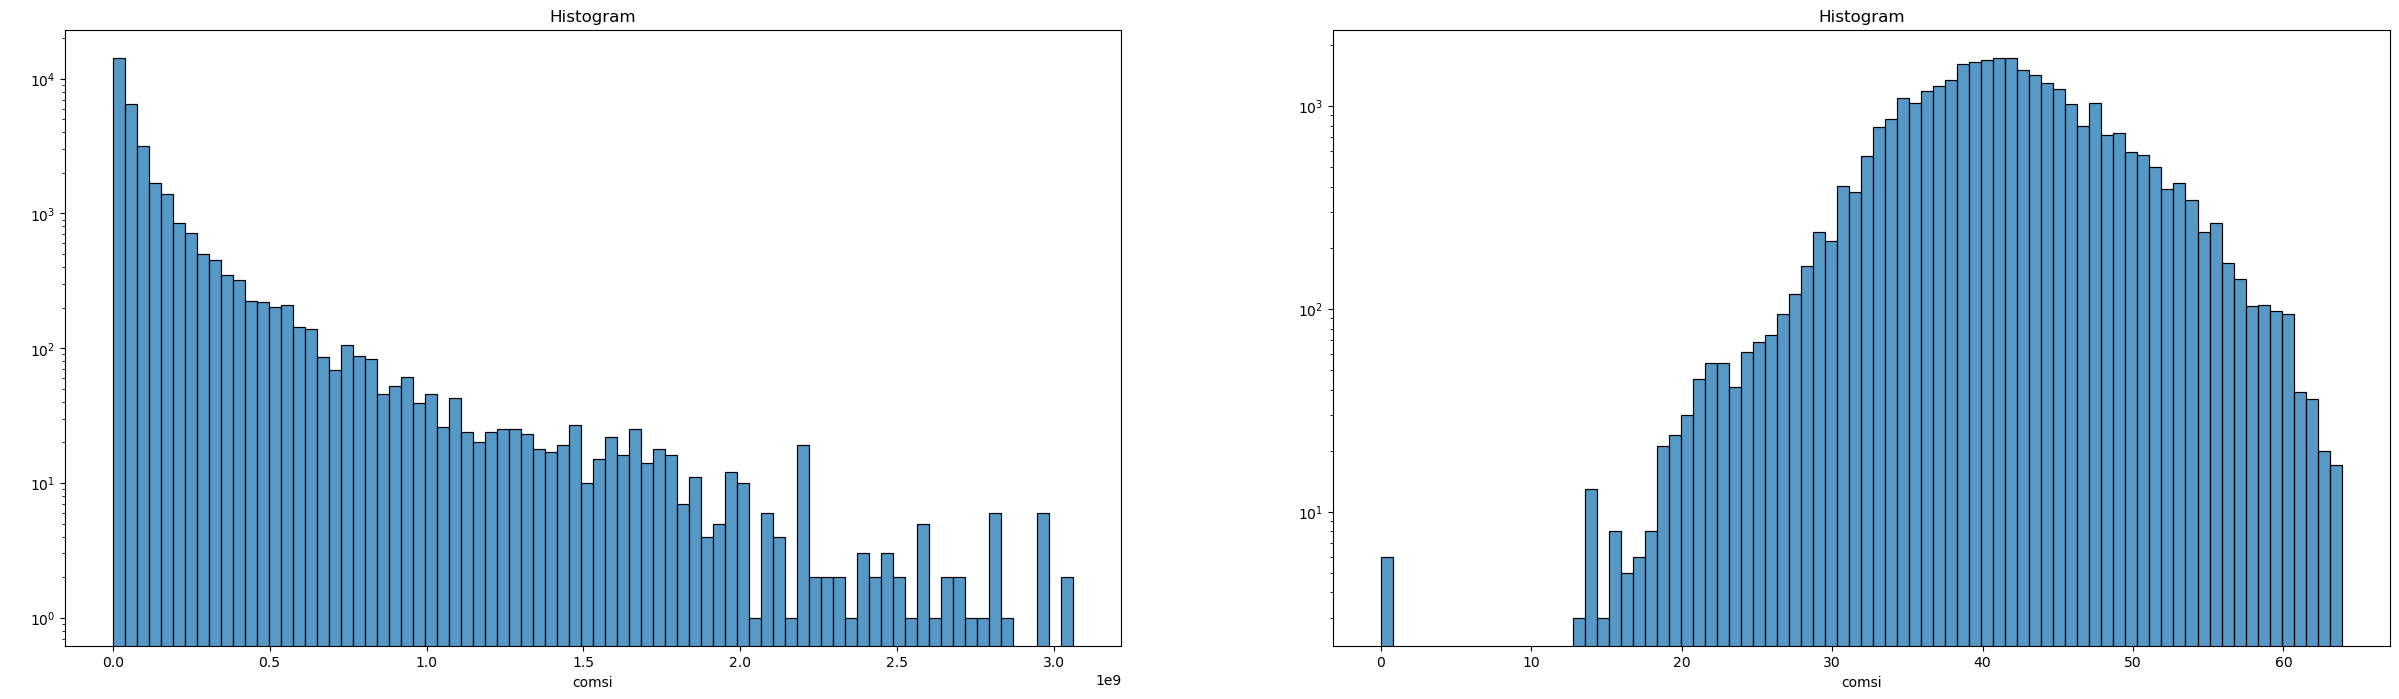

### noa

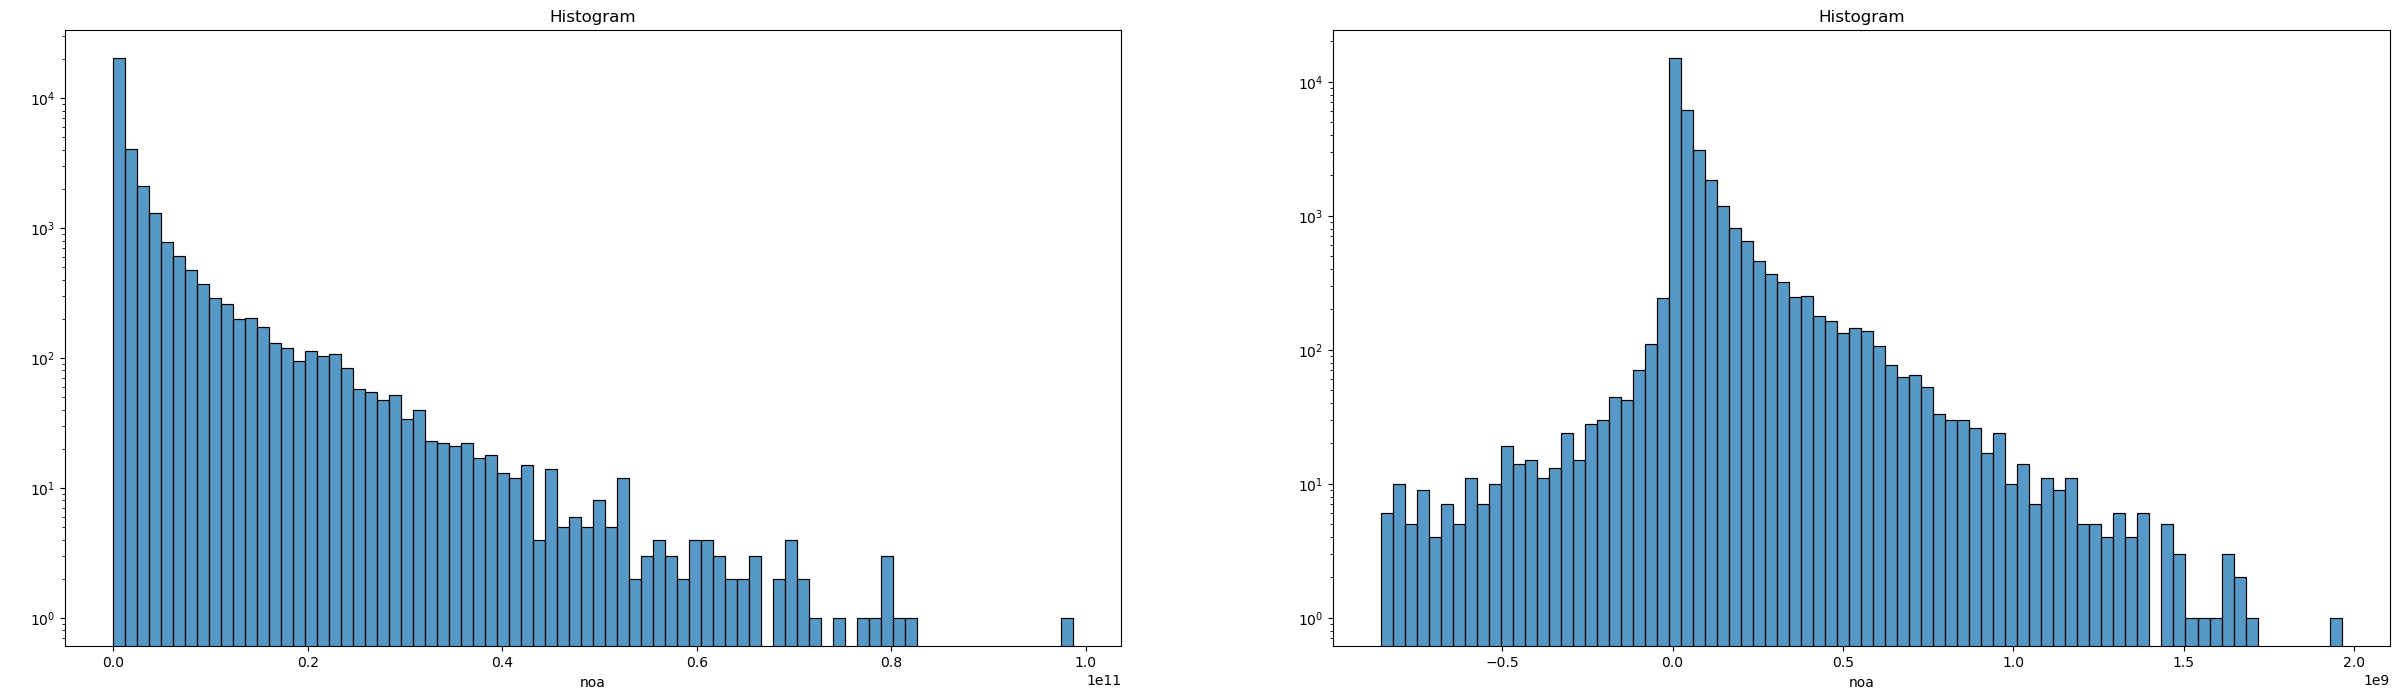

### wc

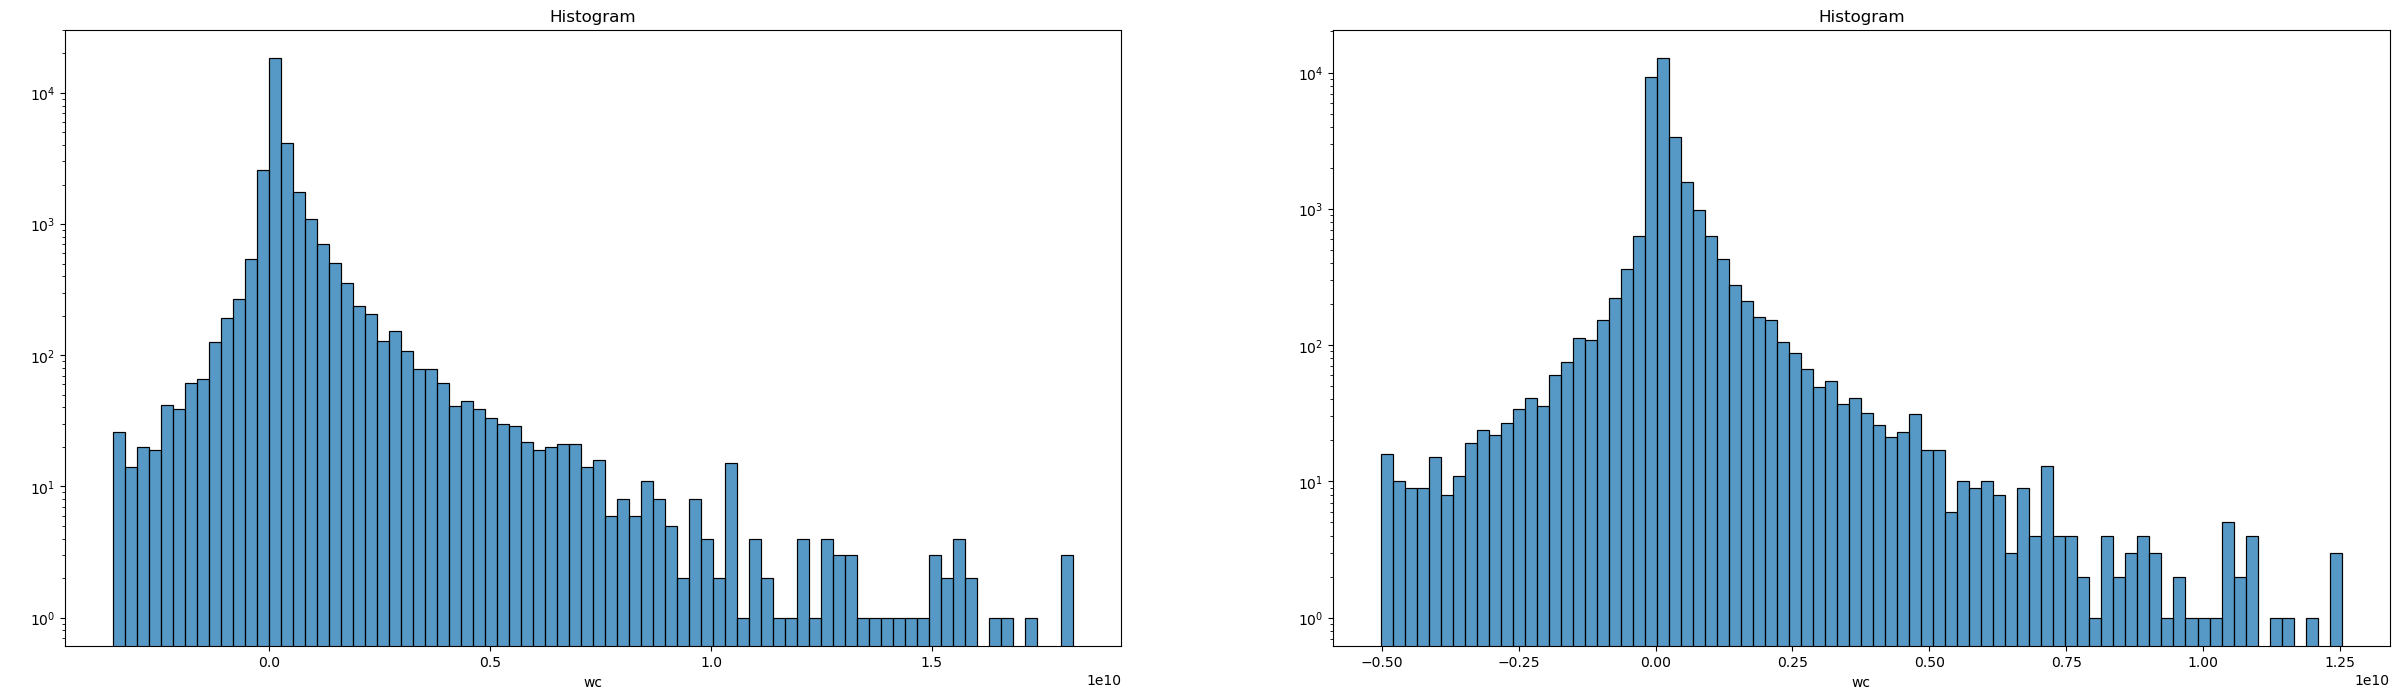

### ndebt

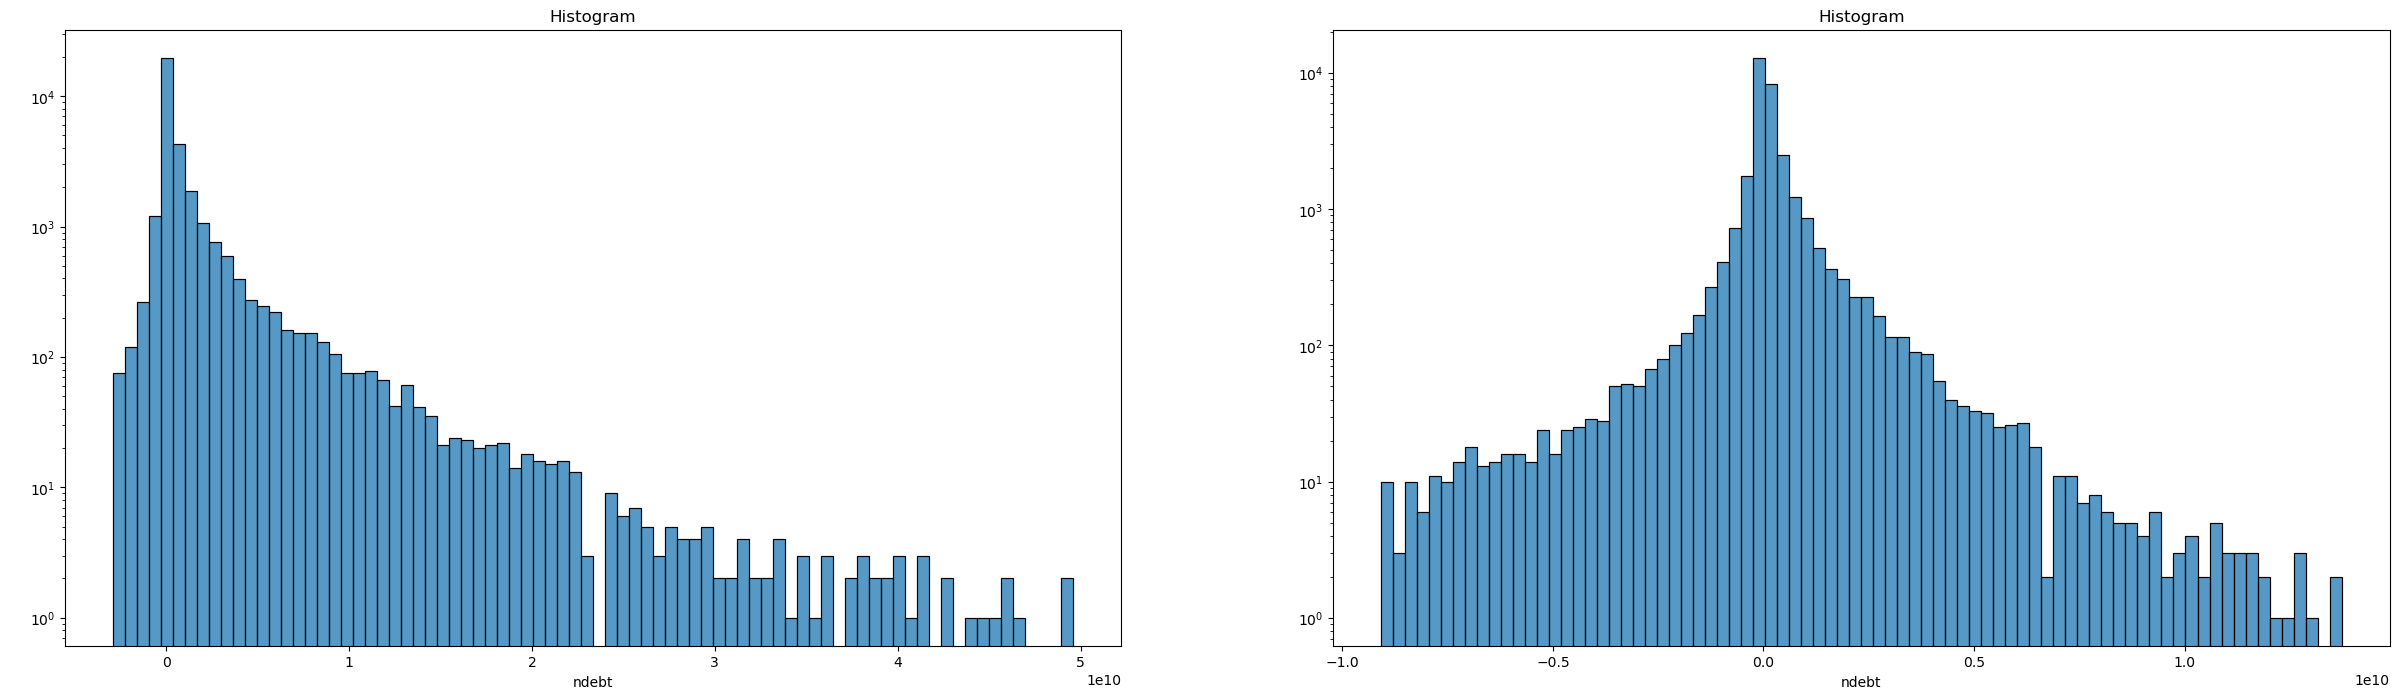

### capex

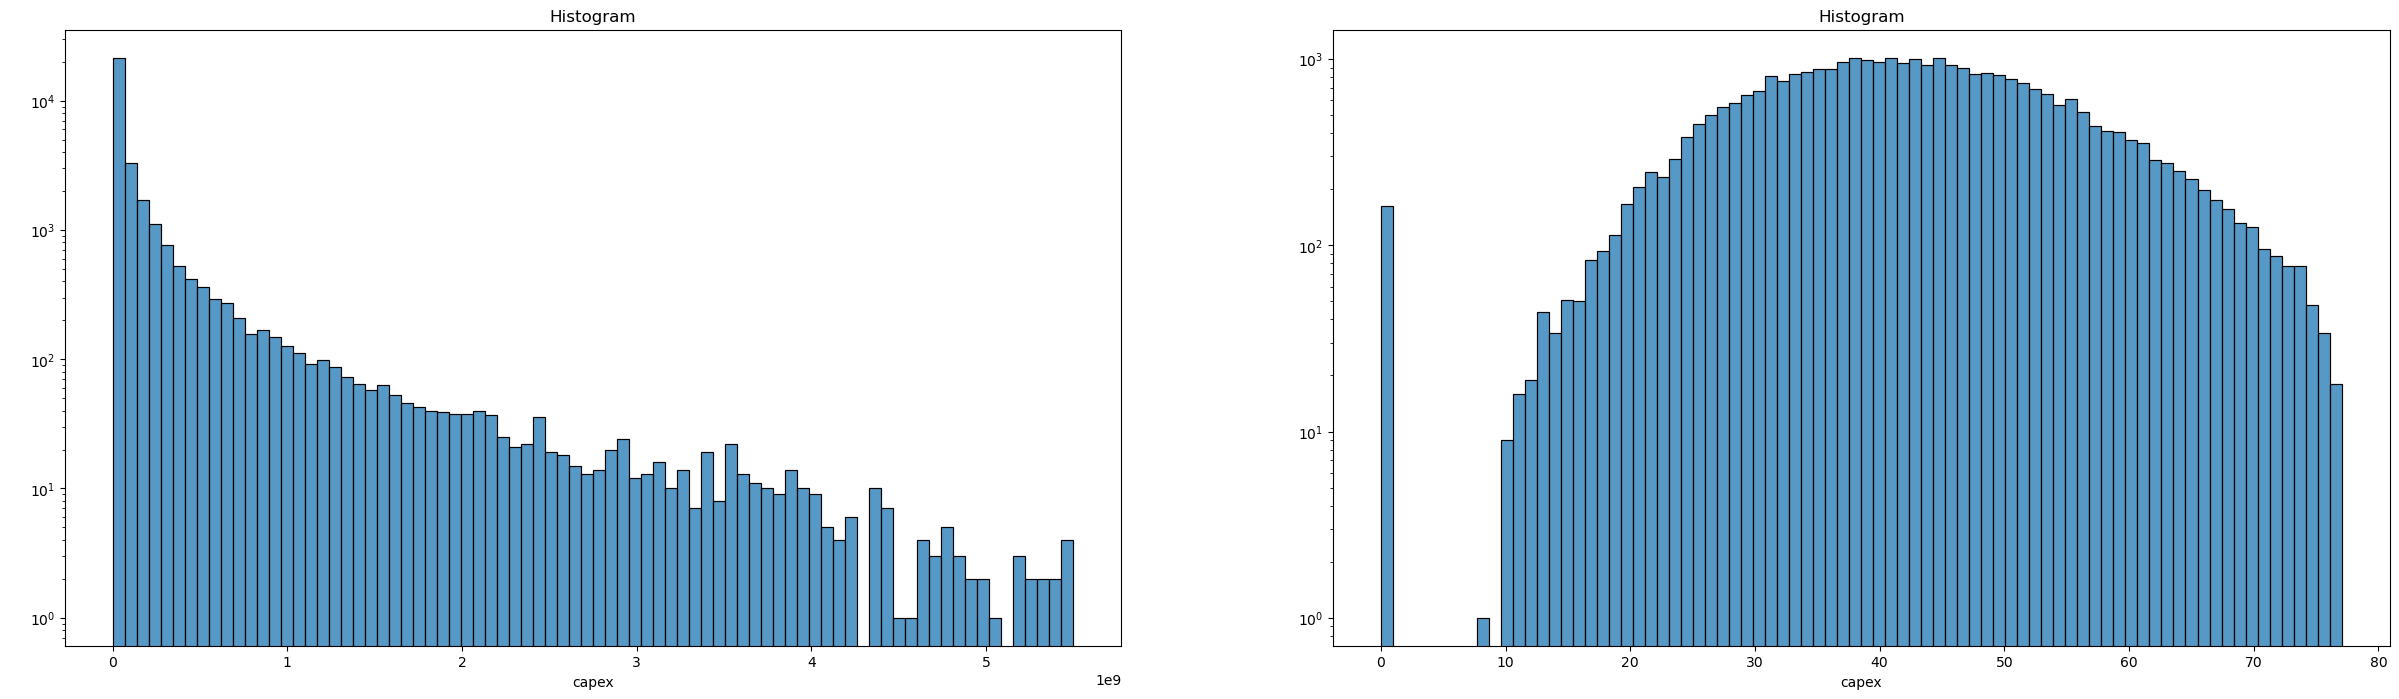

### ncfo

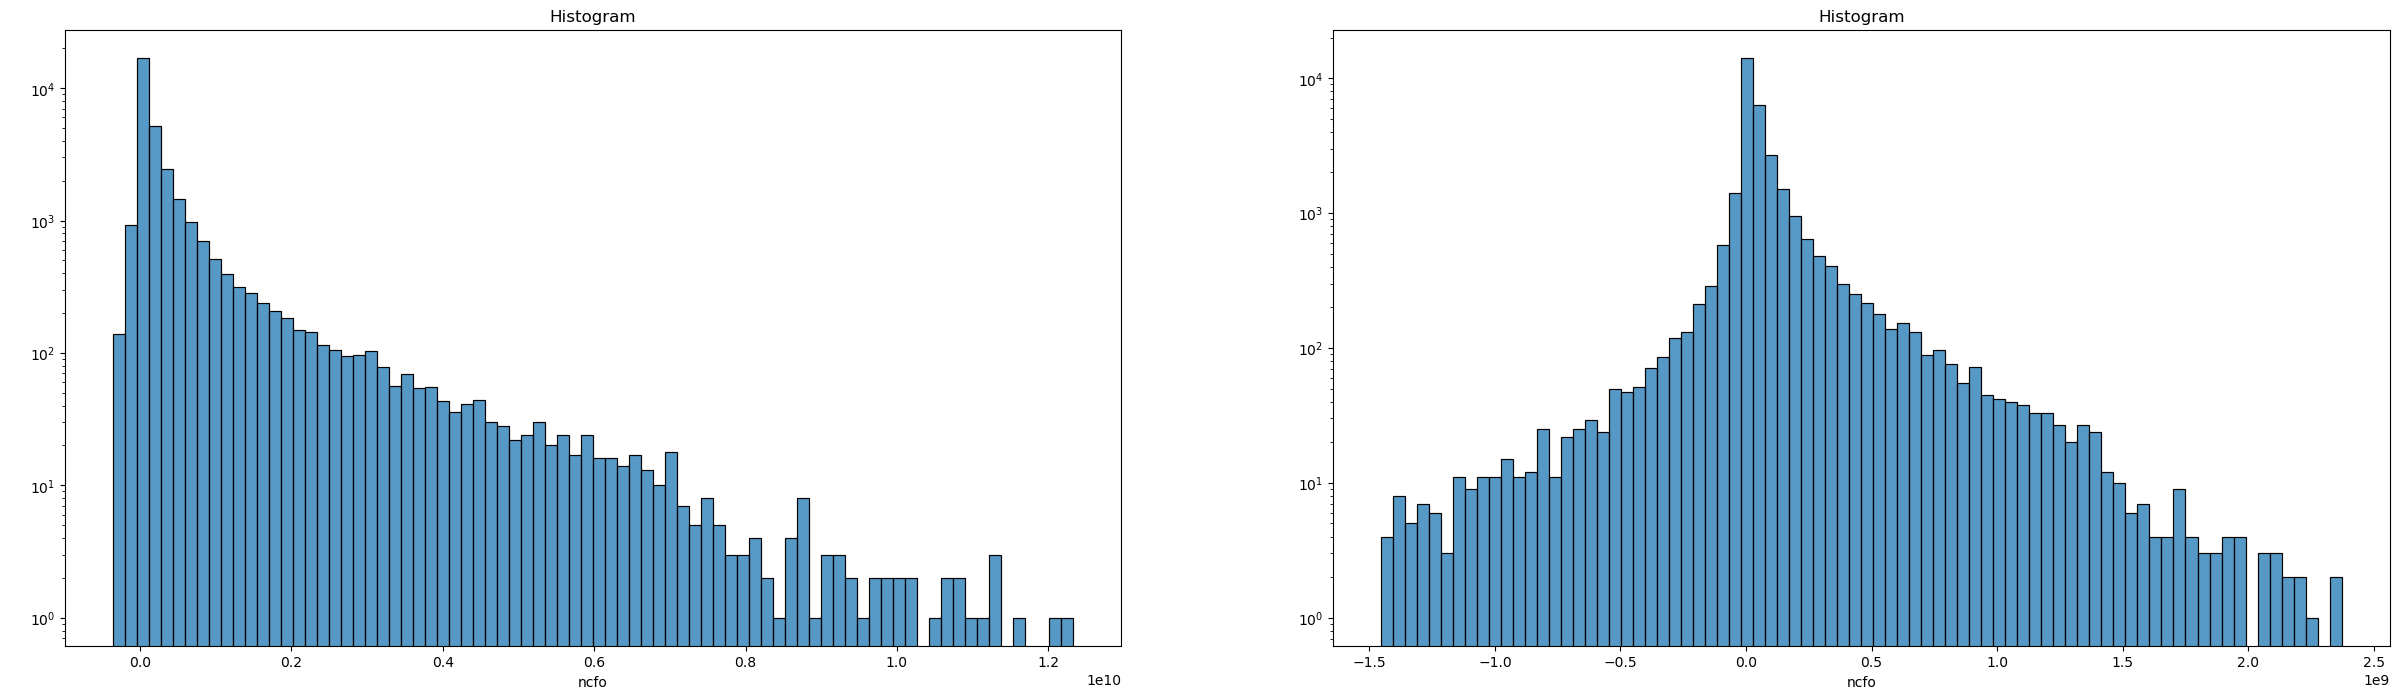

### levfcf

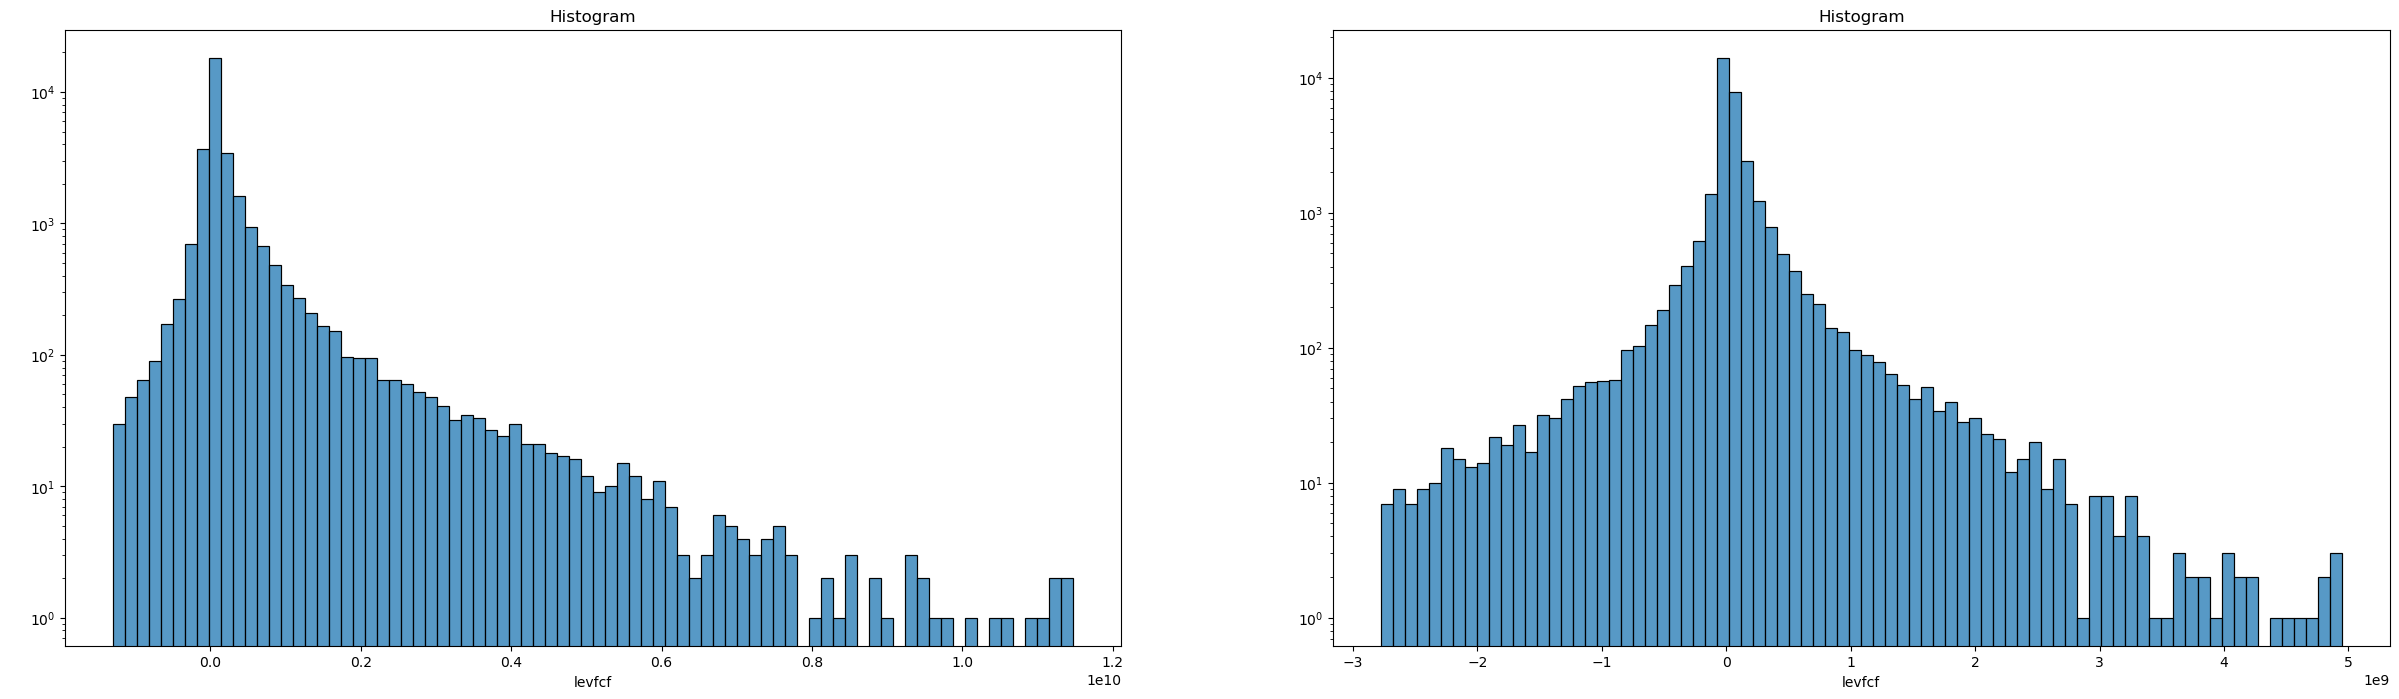

### nincam

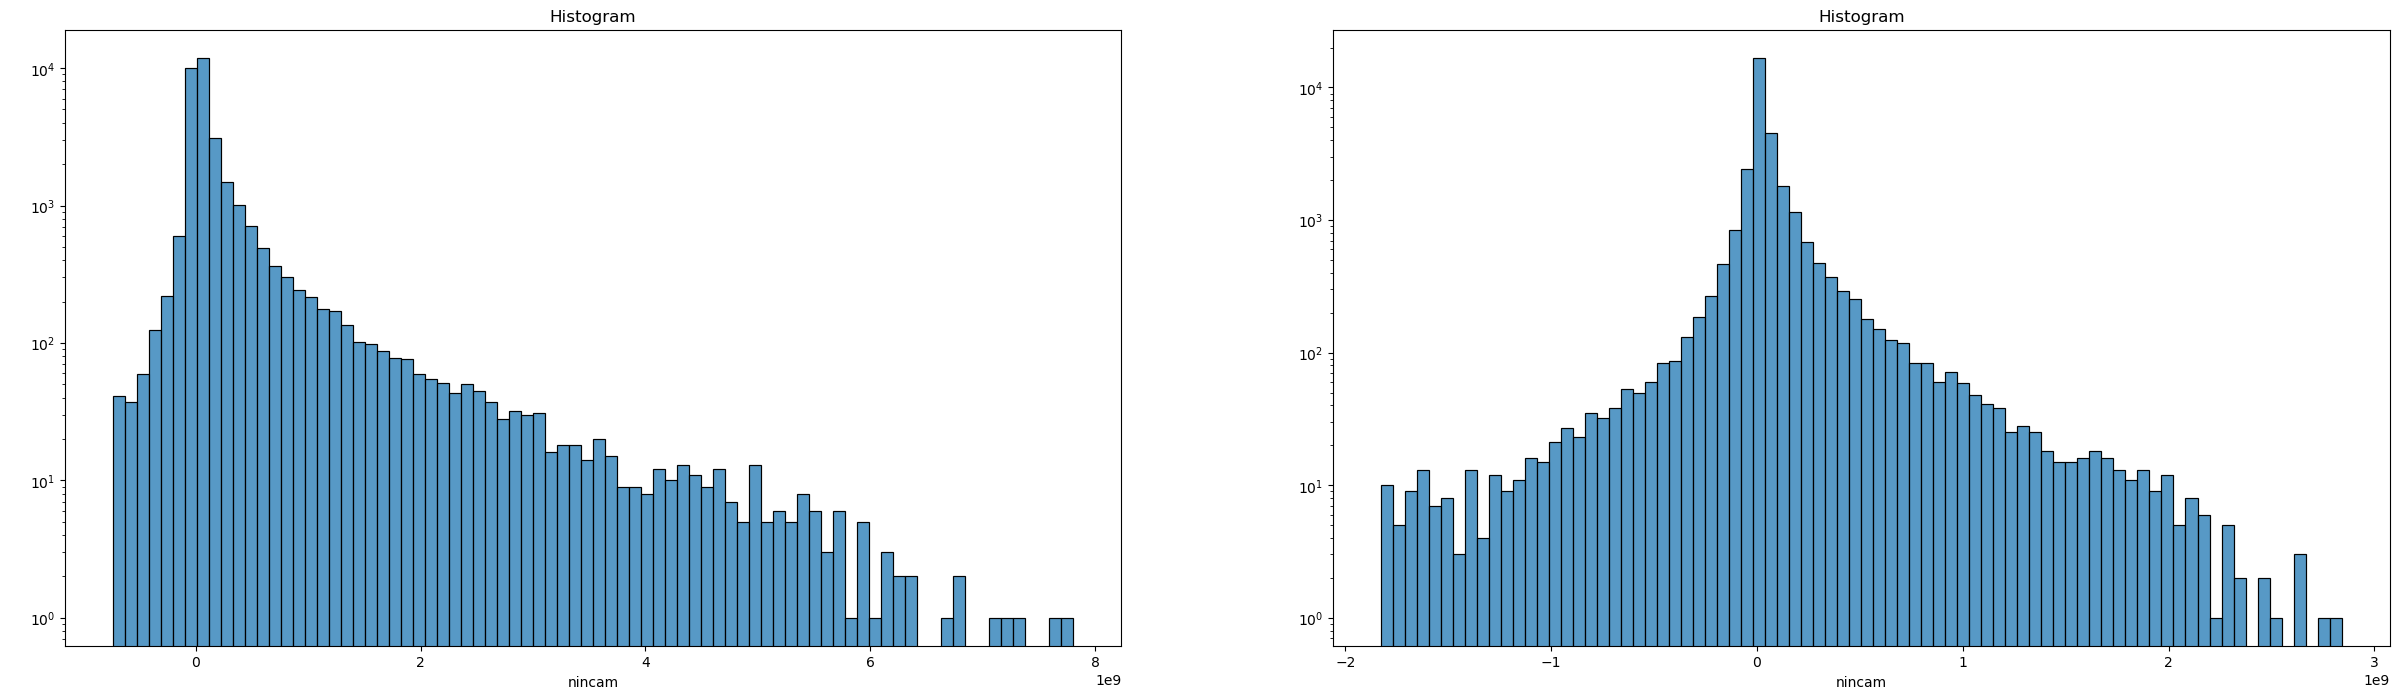

### gp

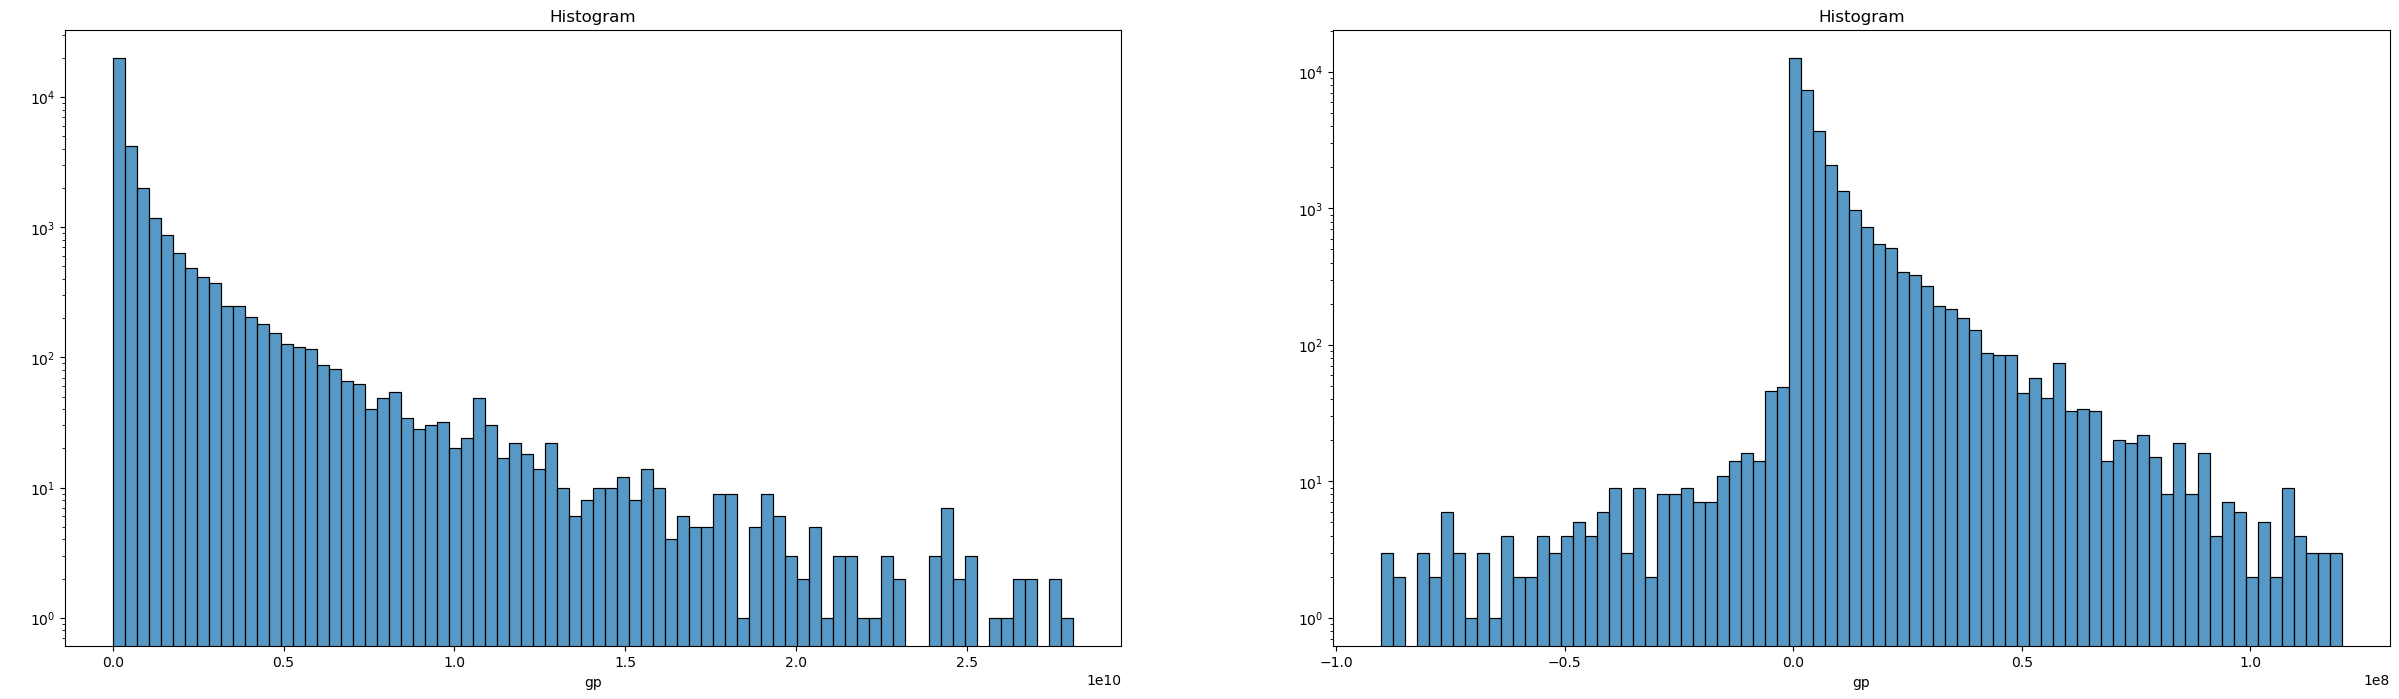

### trev

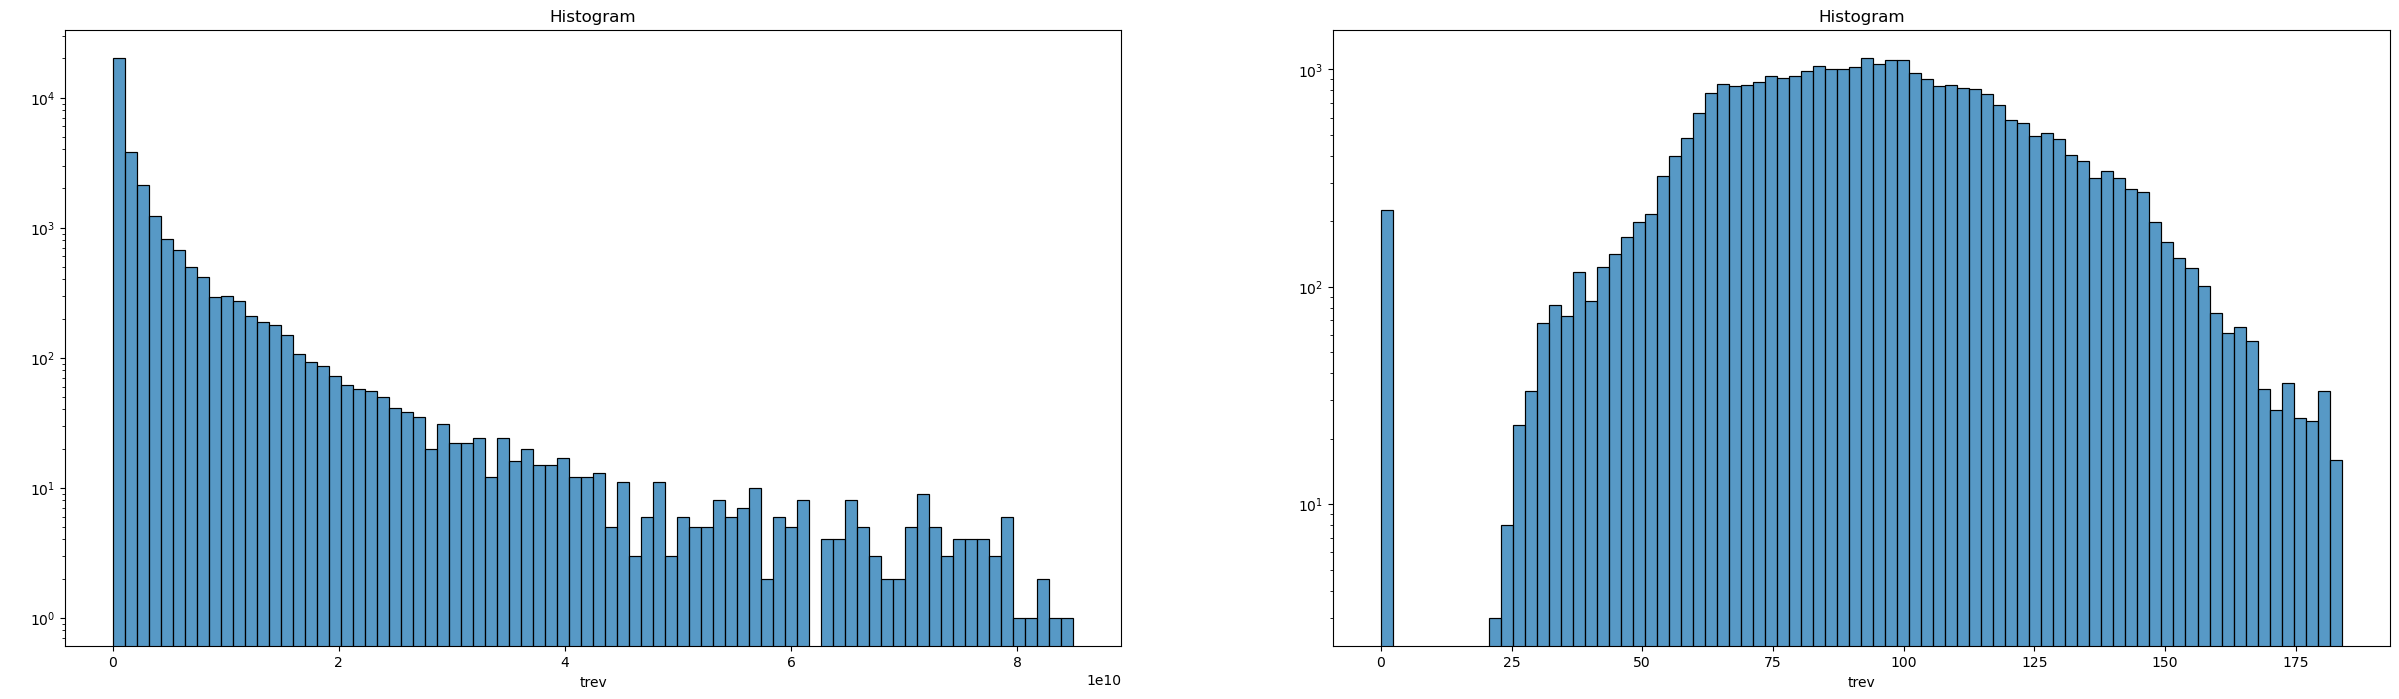

### ebit

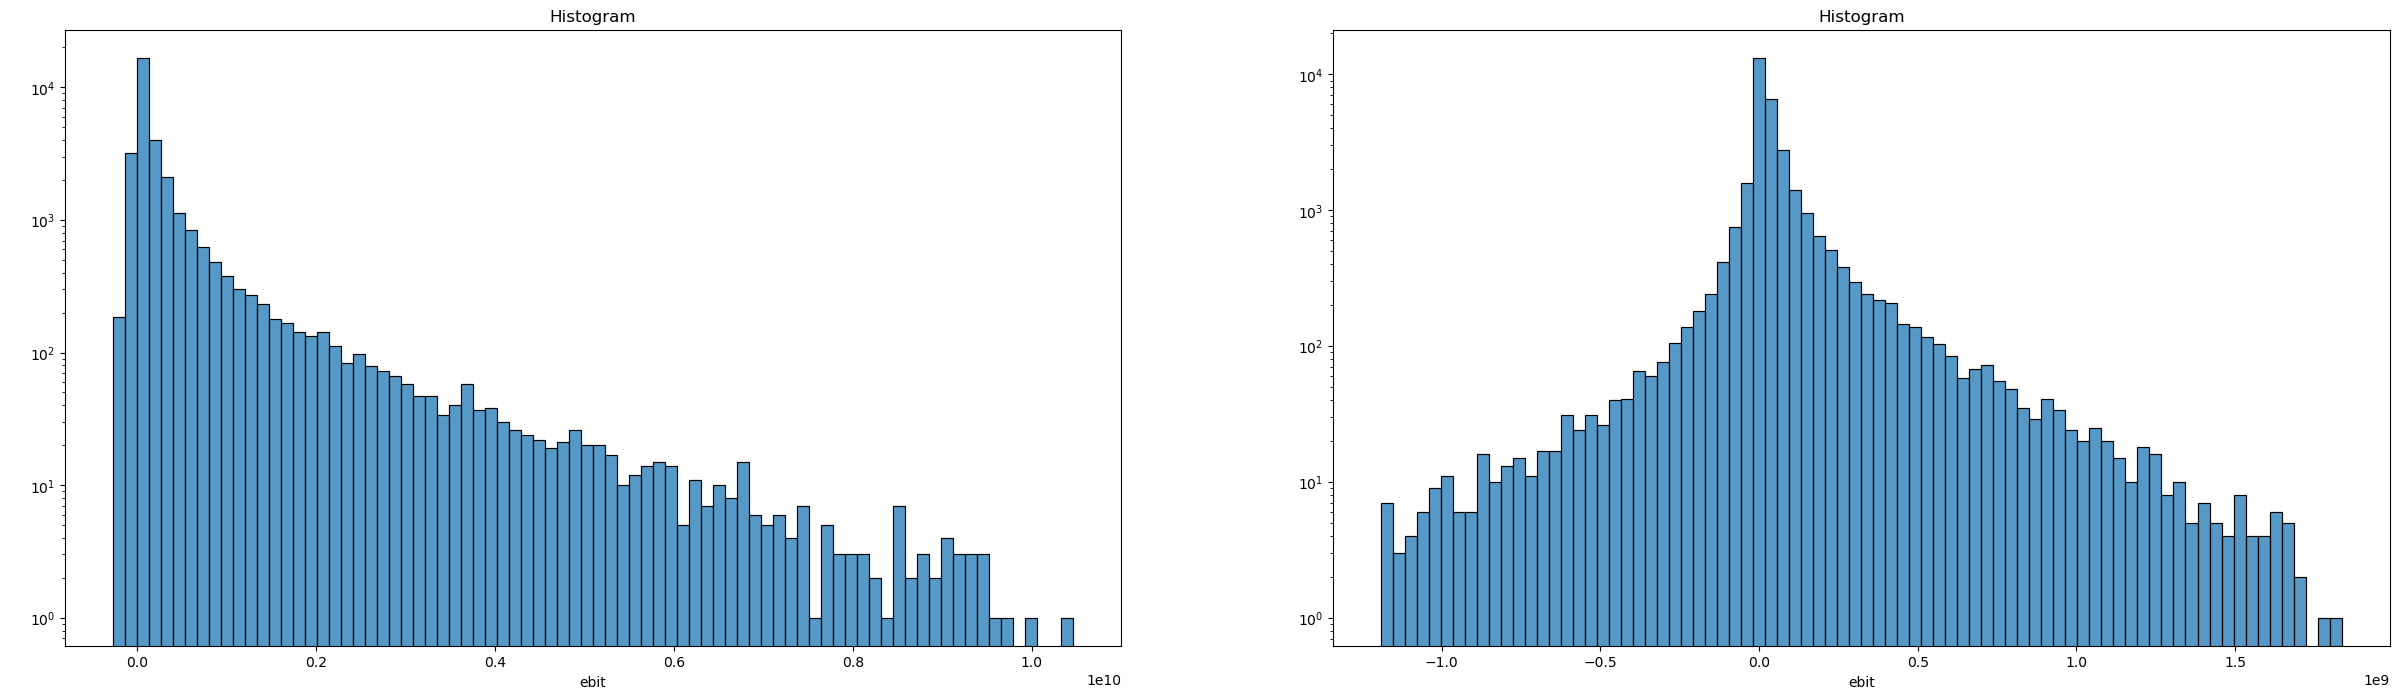

### roe

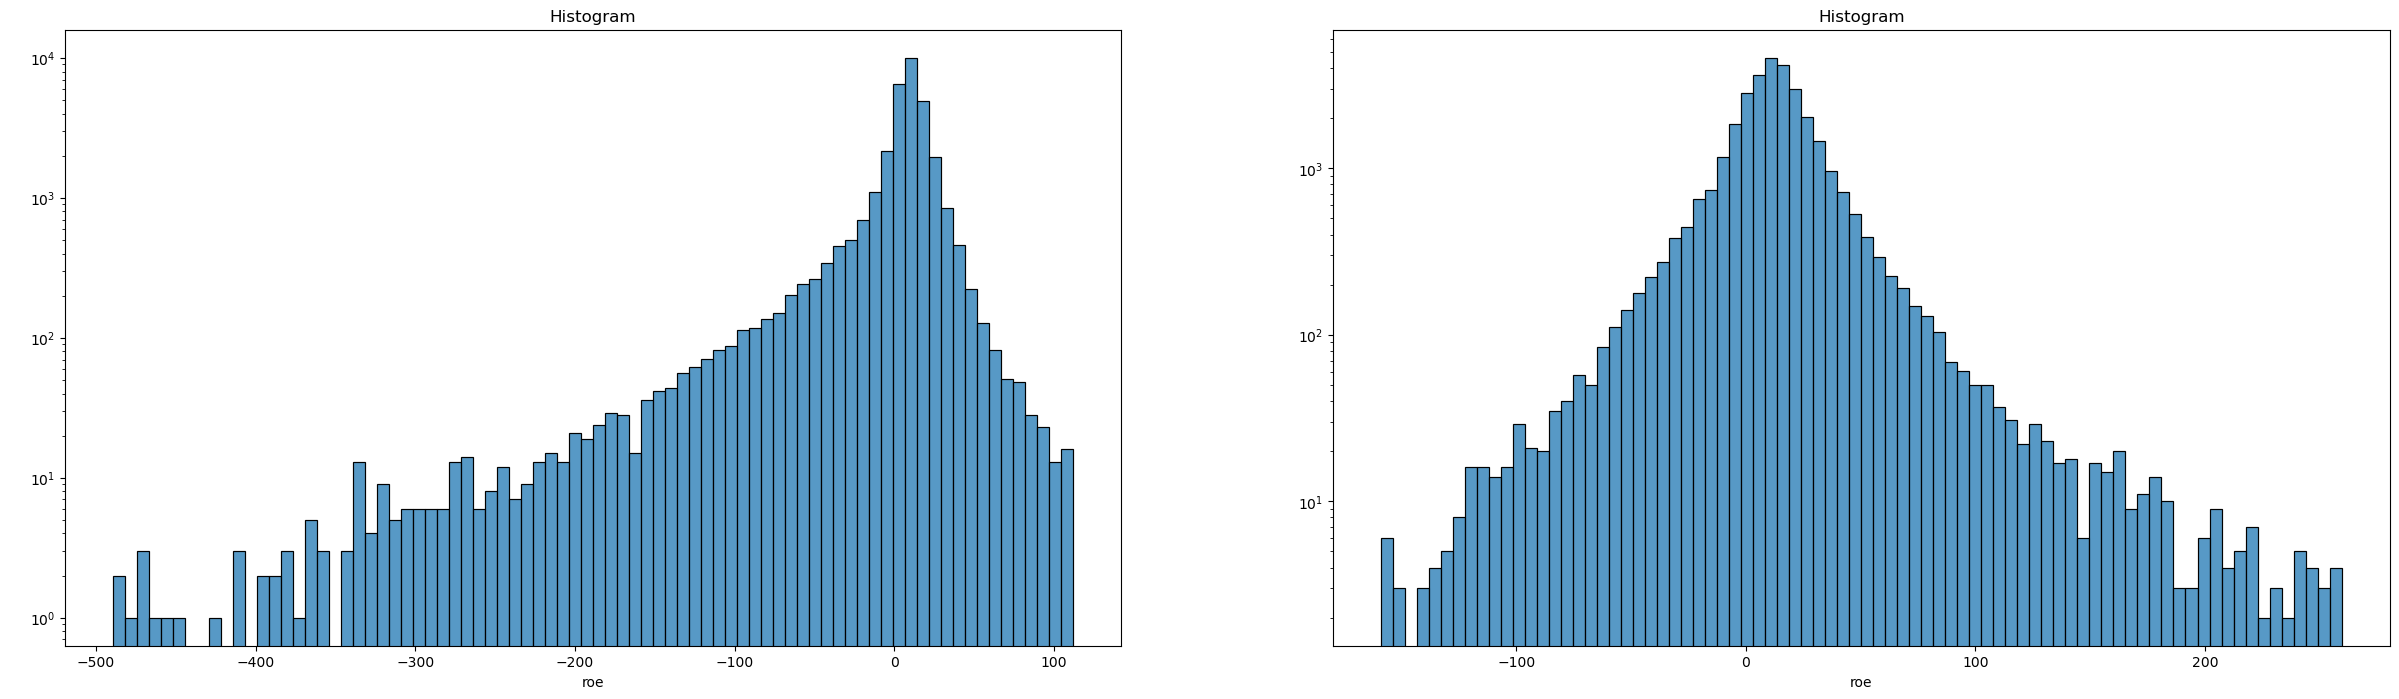

### roce

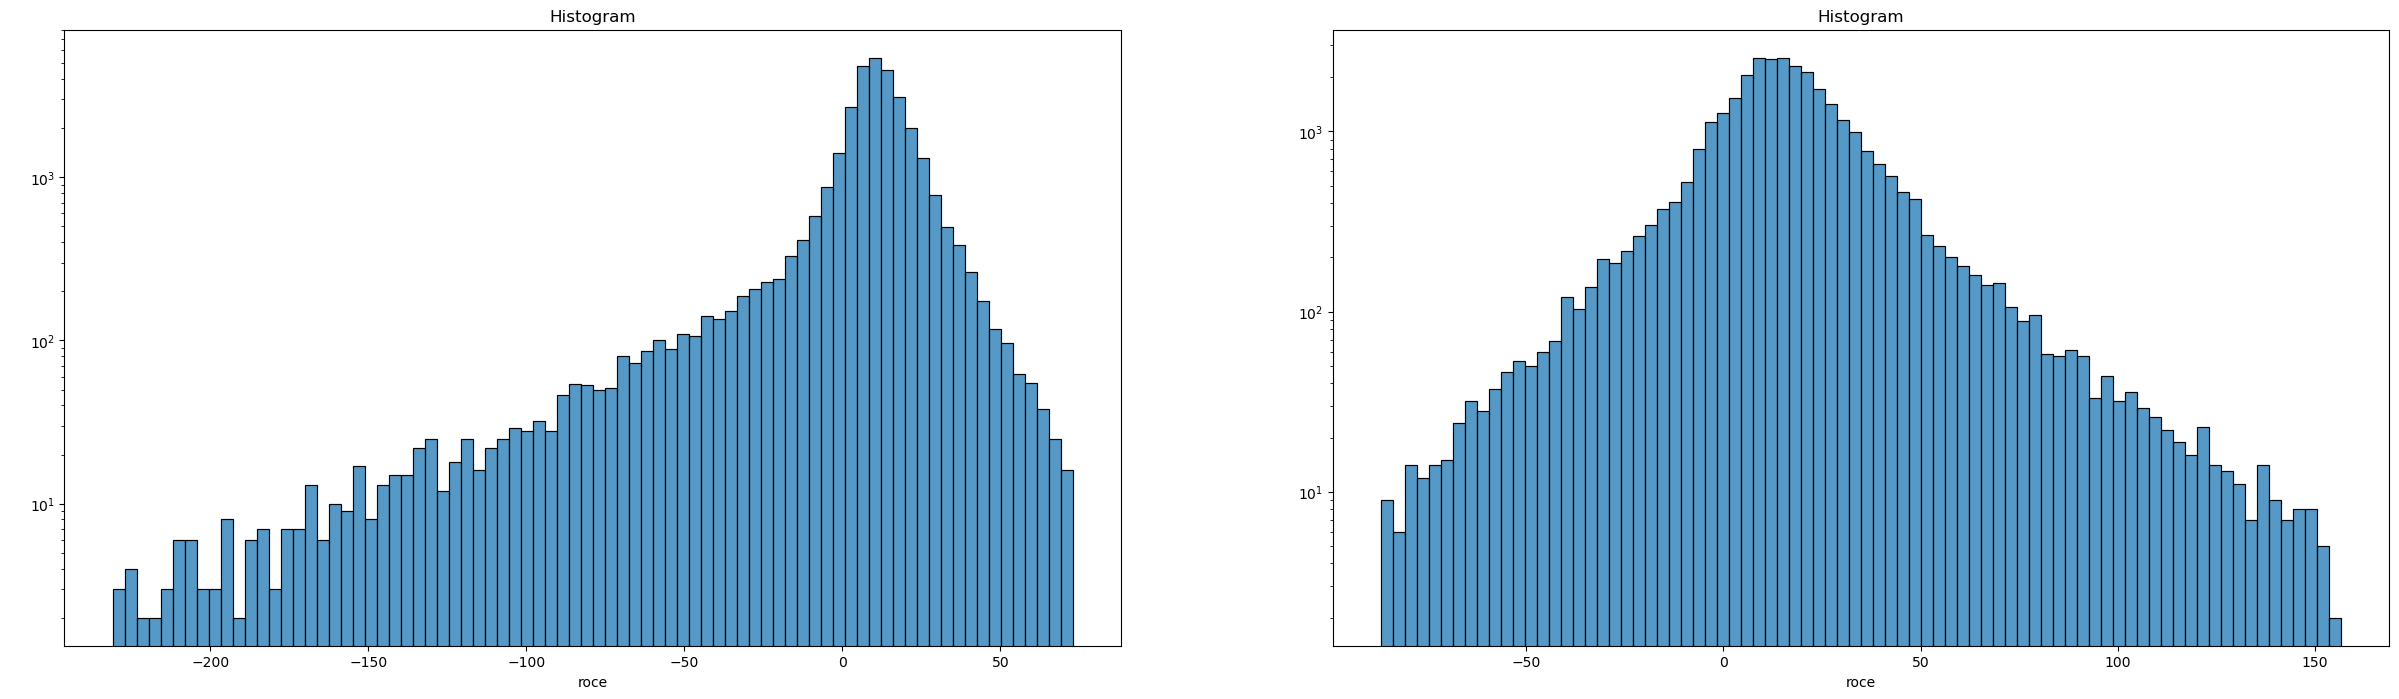

### rnoa

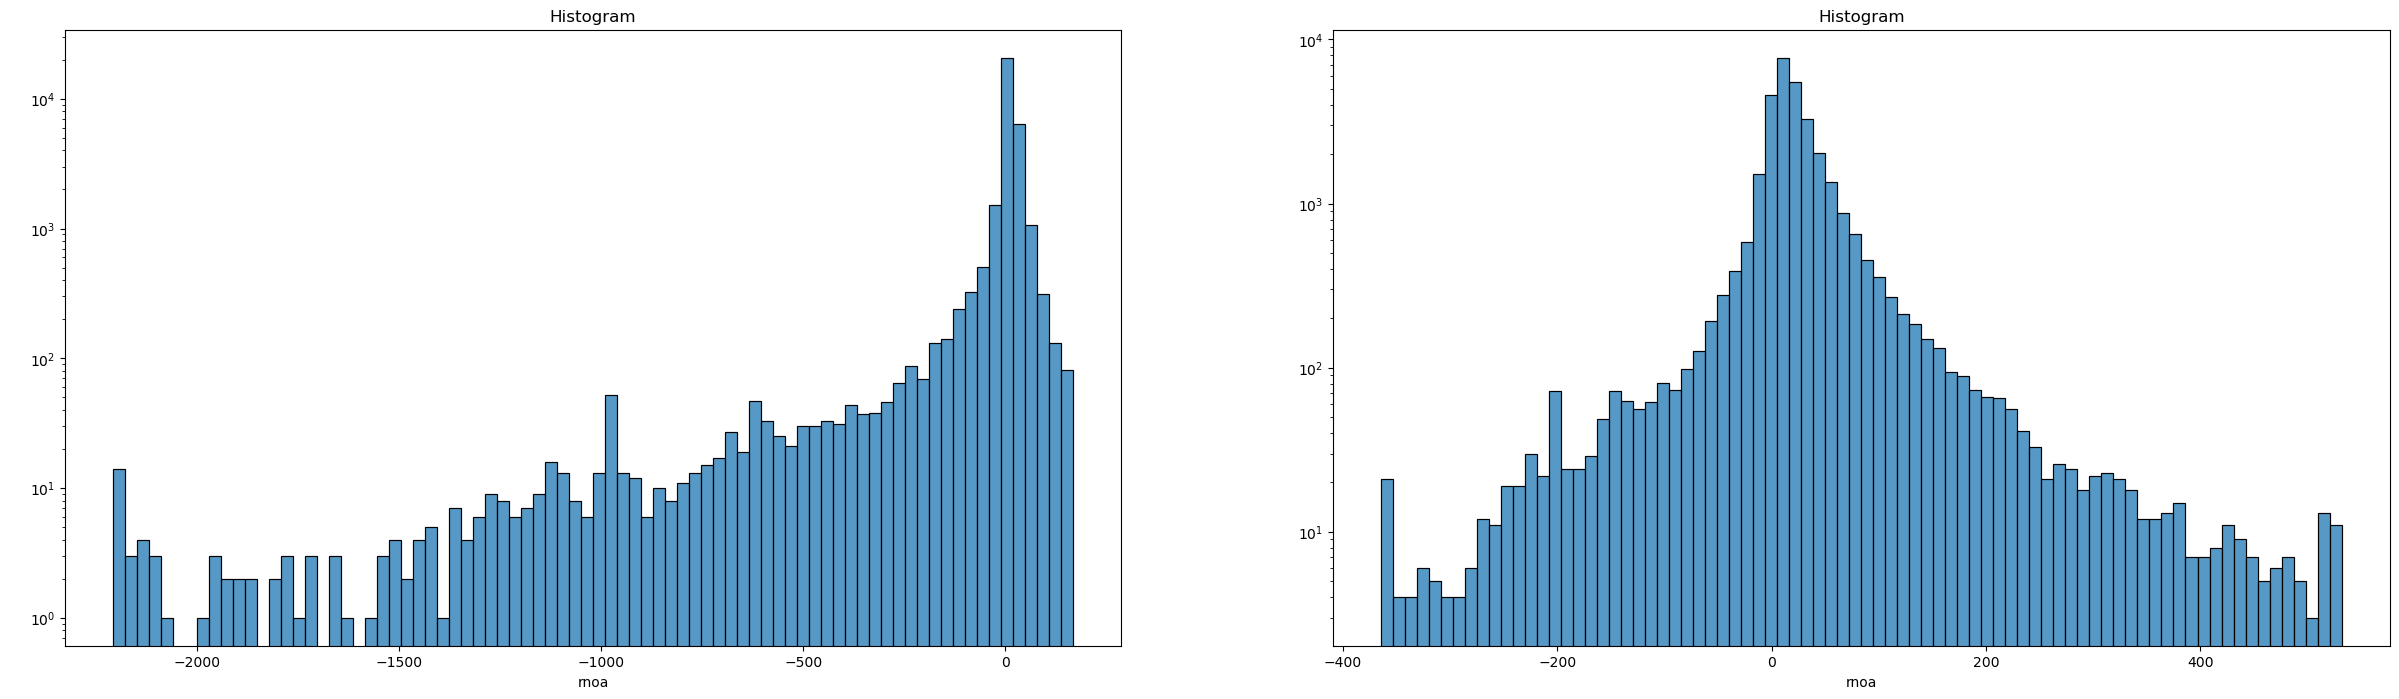

### ebitmarg

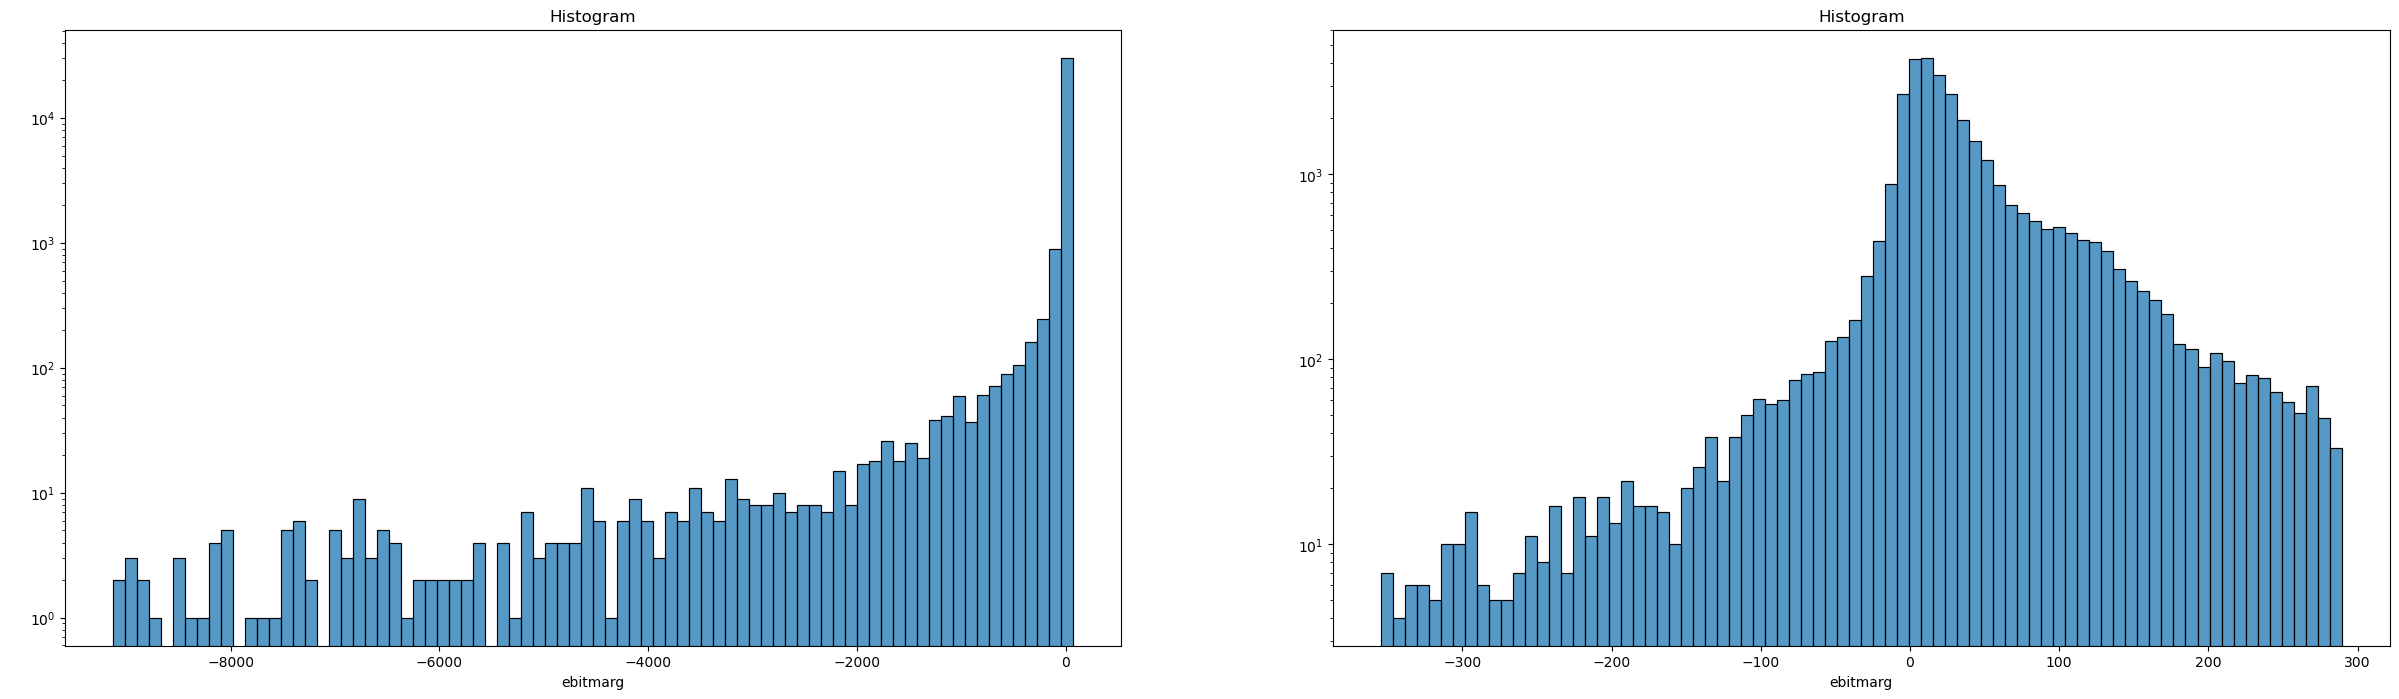

### shouts

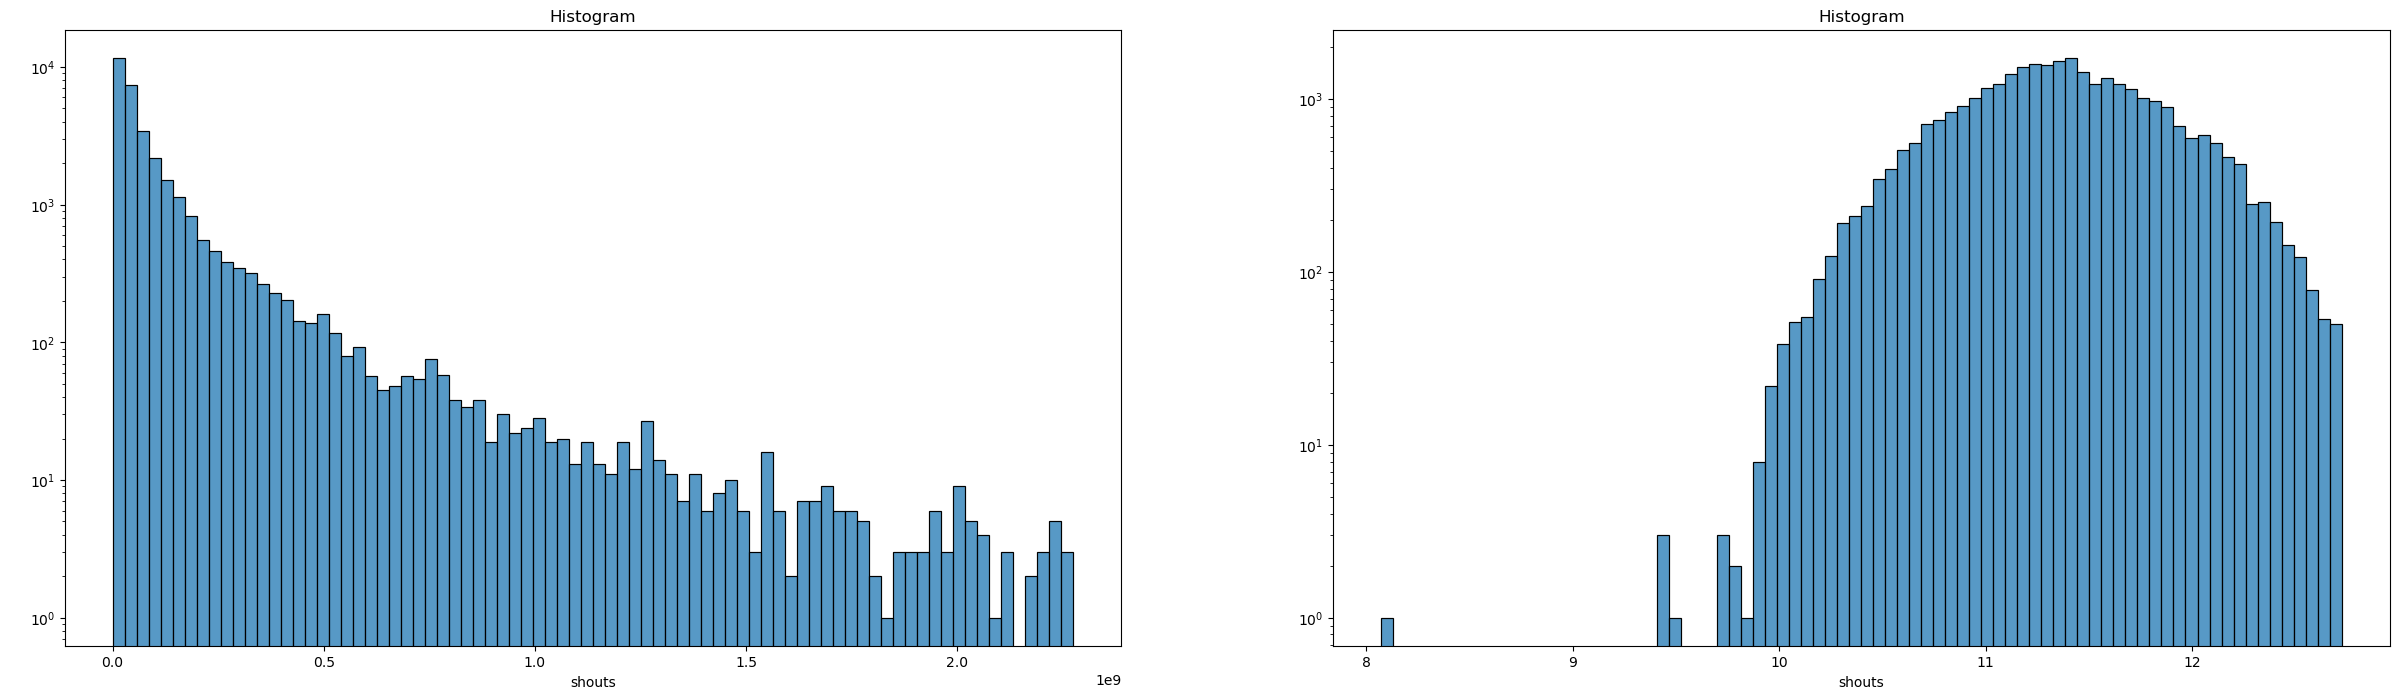

### mc

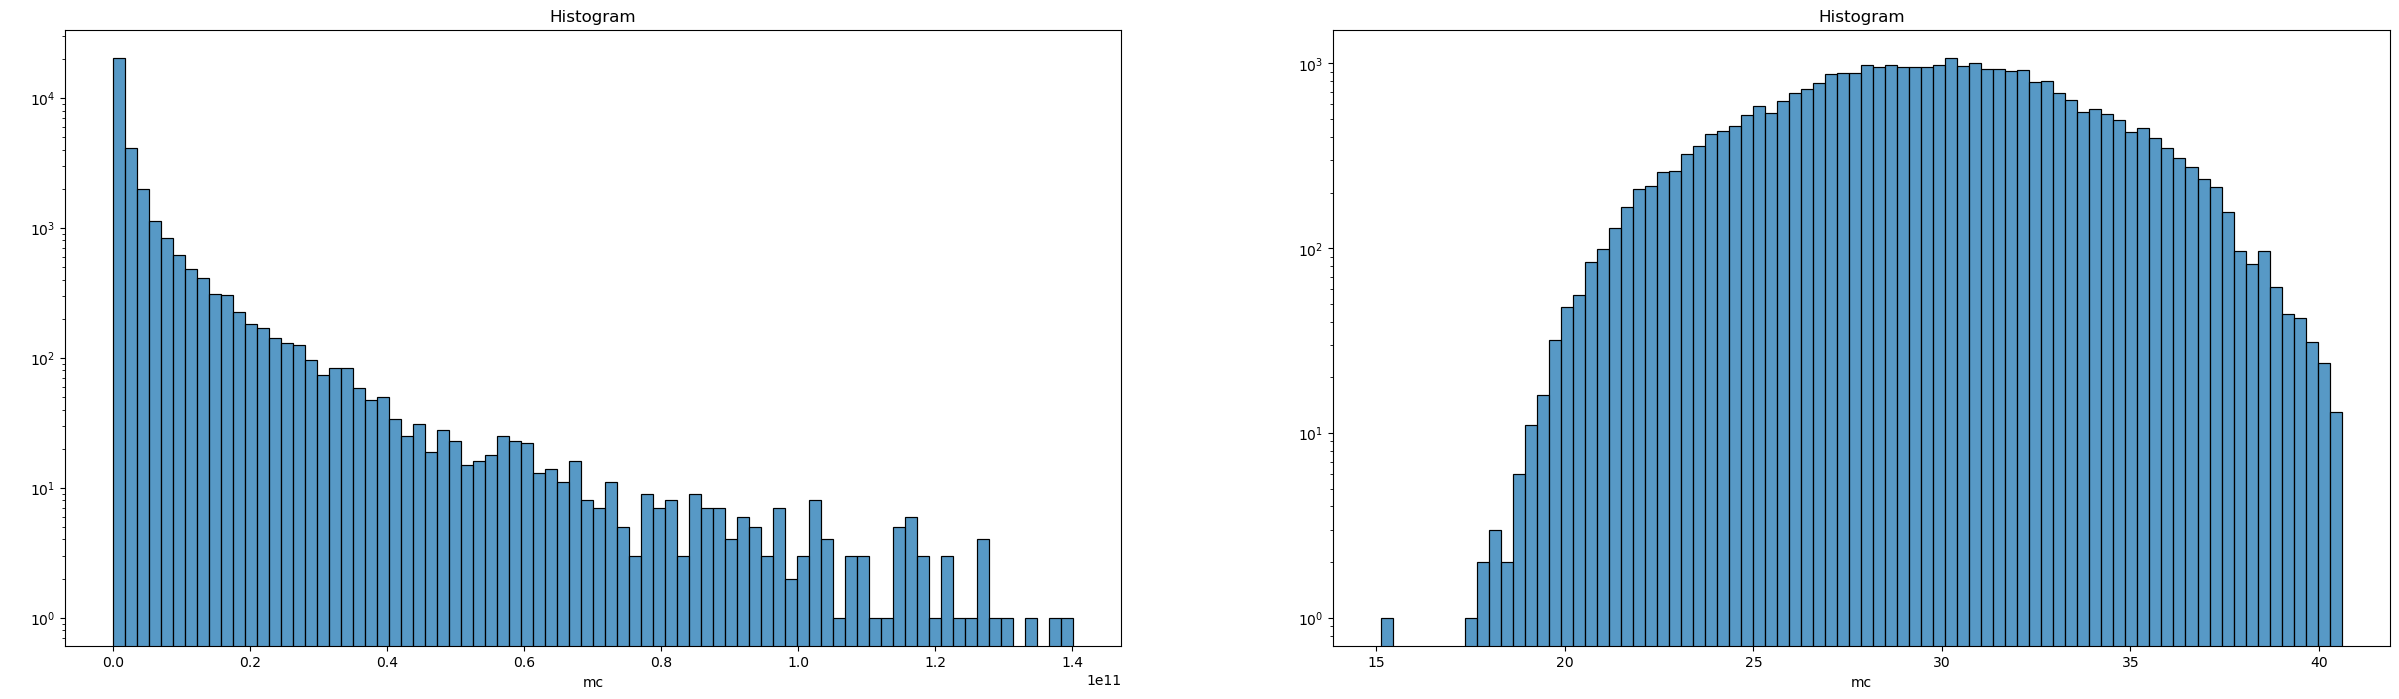

### ptbvps

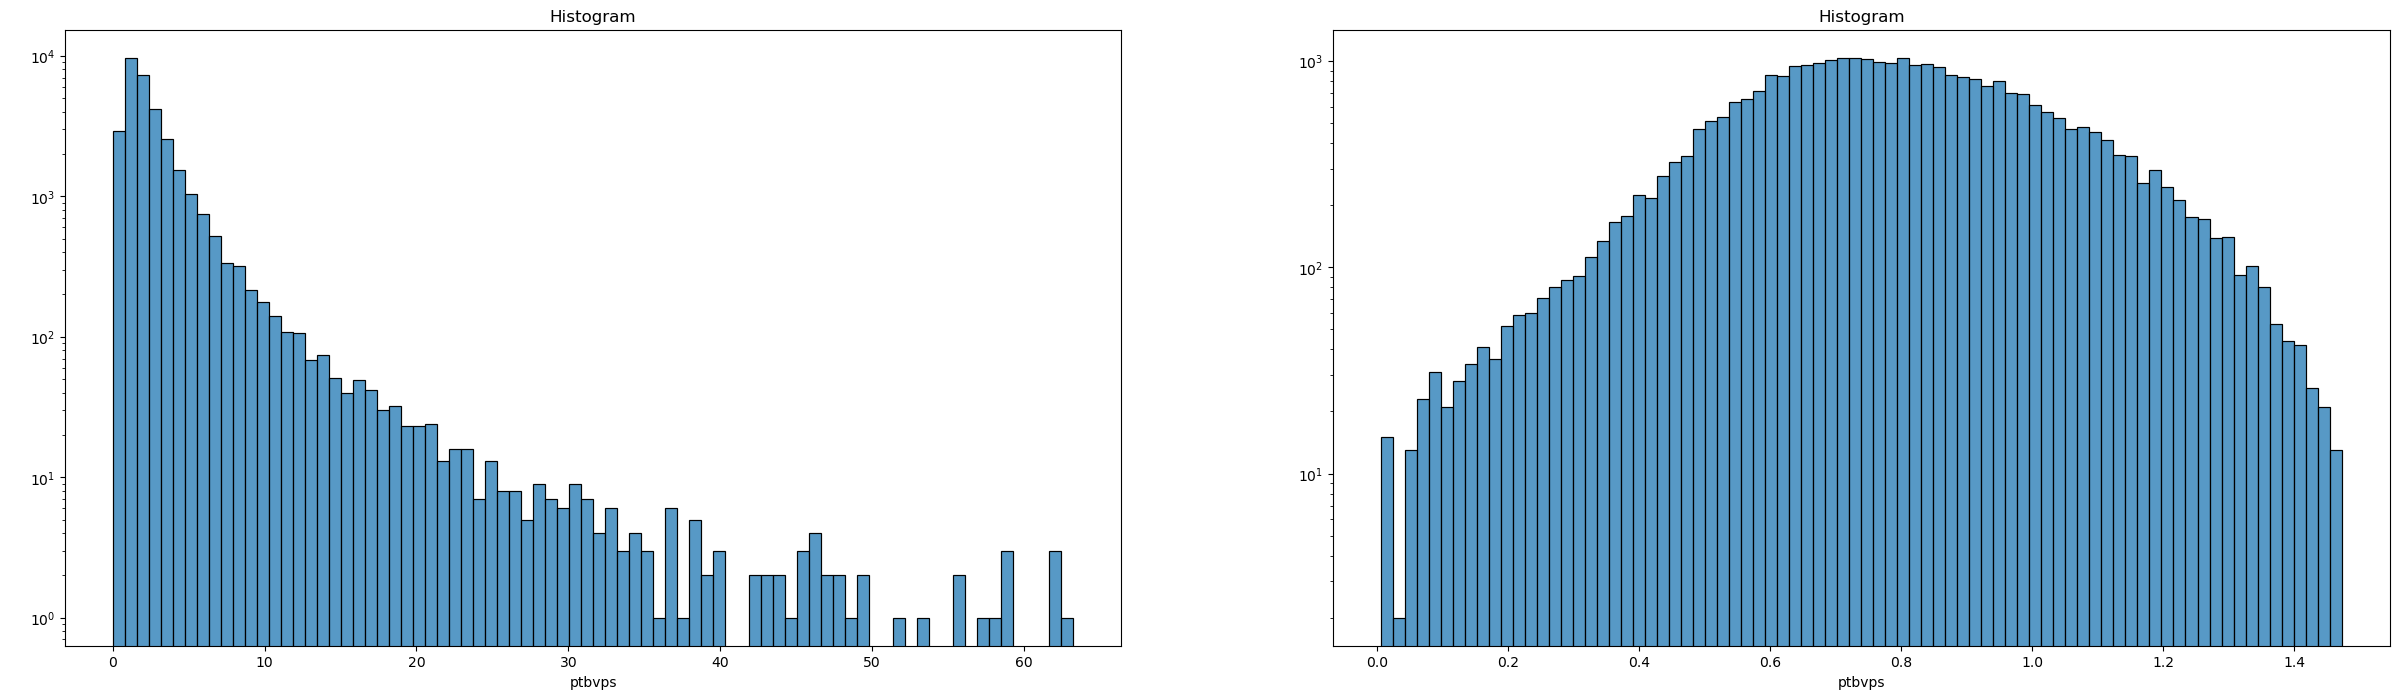

### oips

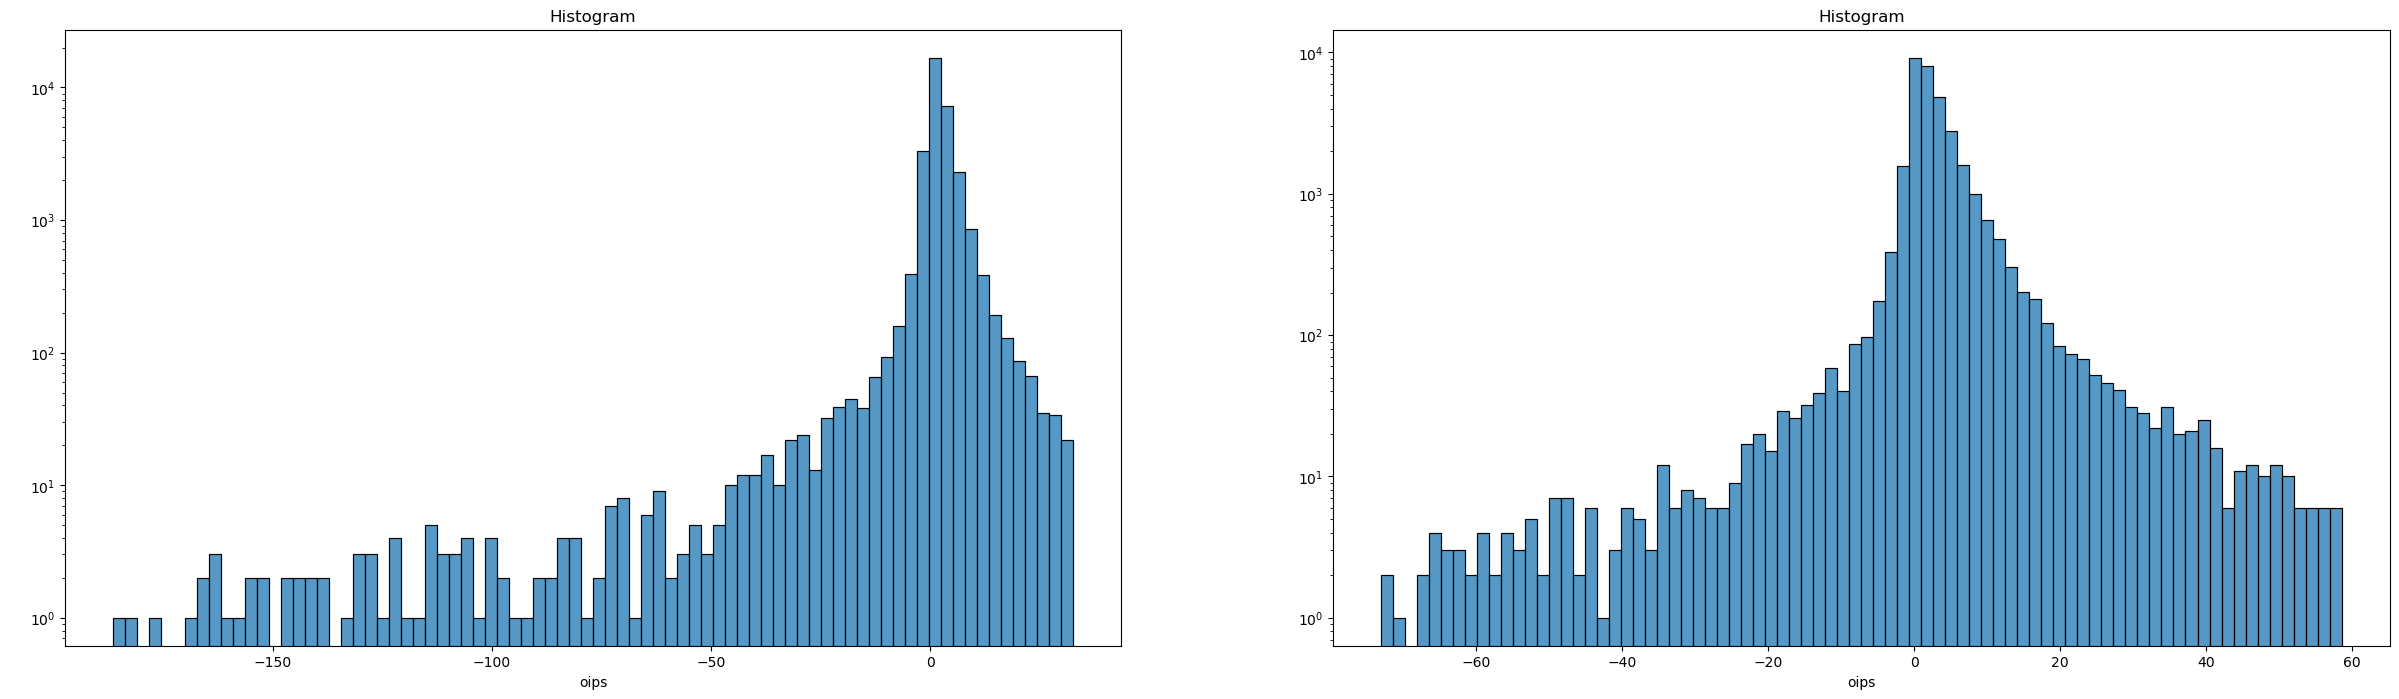

### cfps

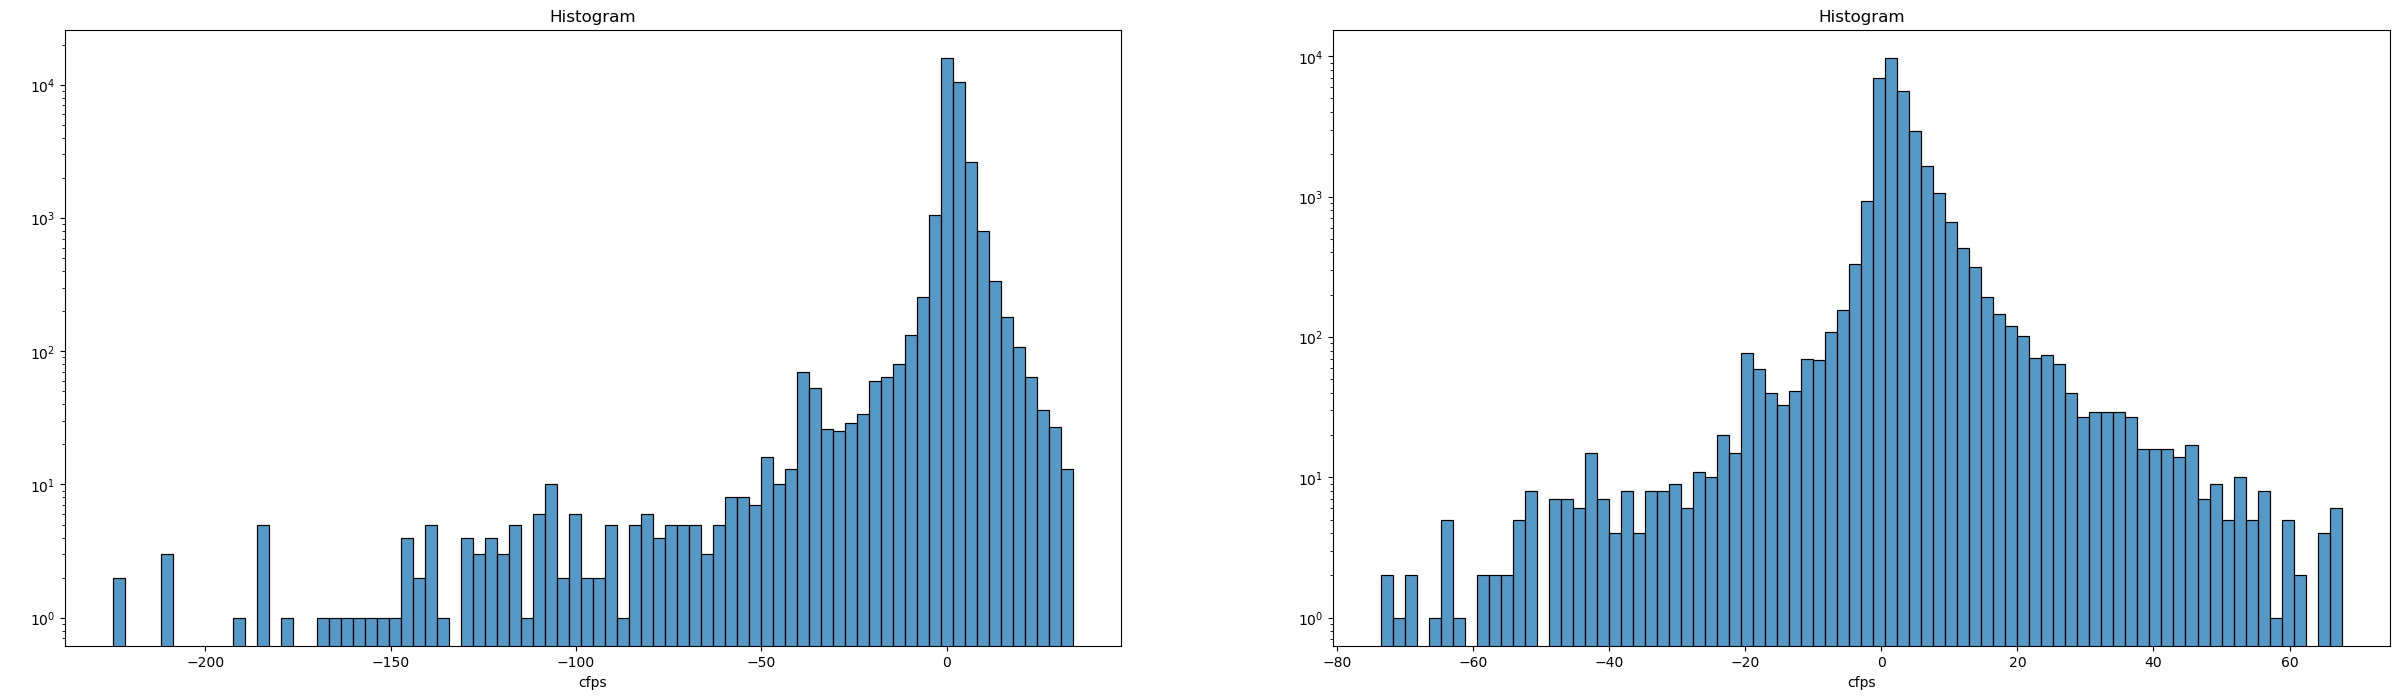

### ros_c

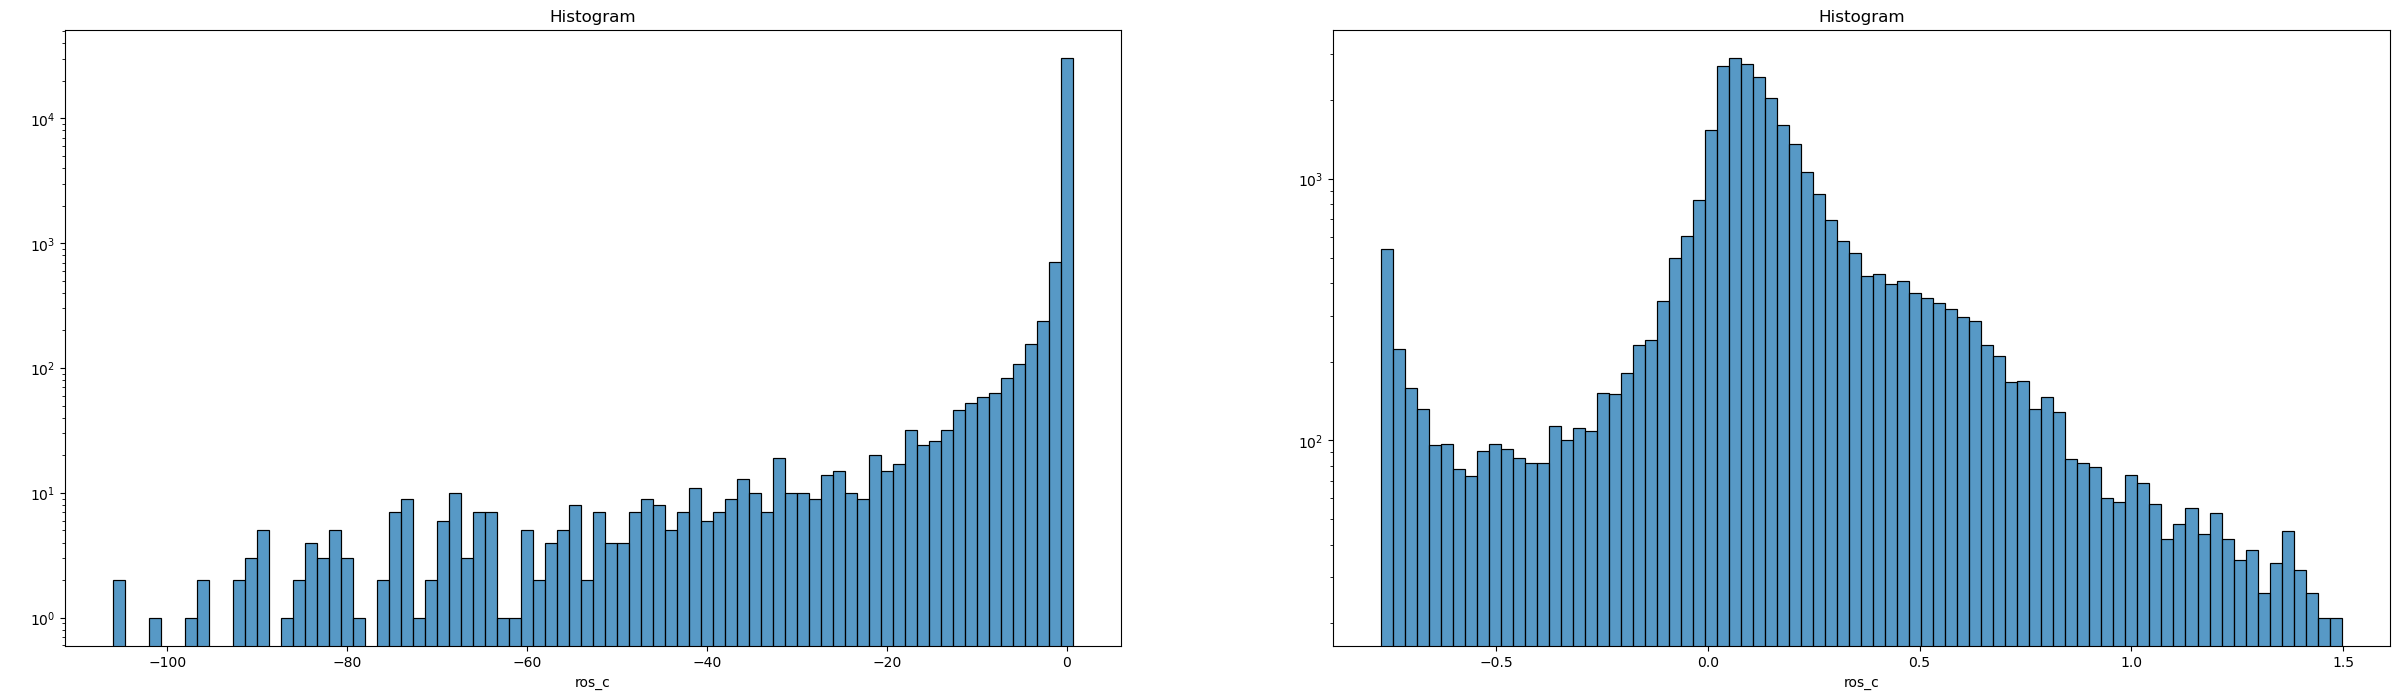

### prof_c

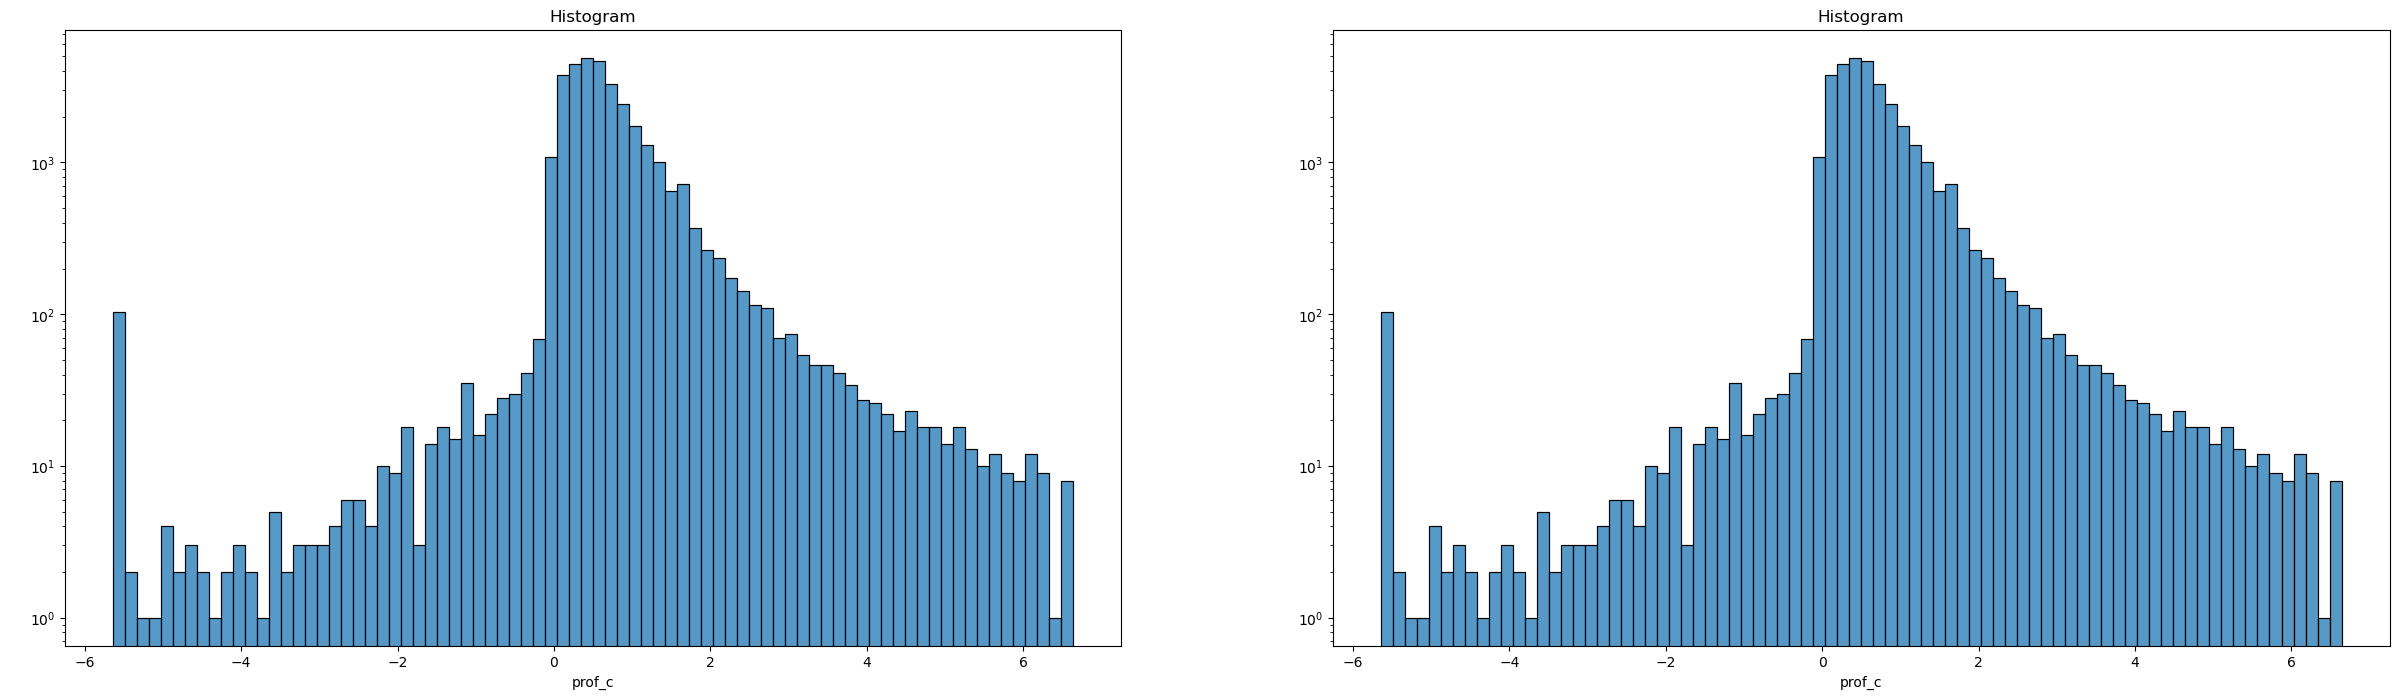

### finlev_c

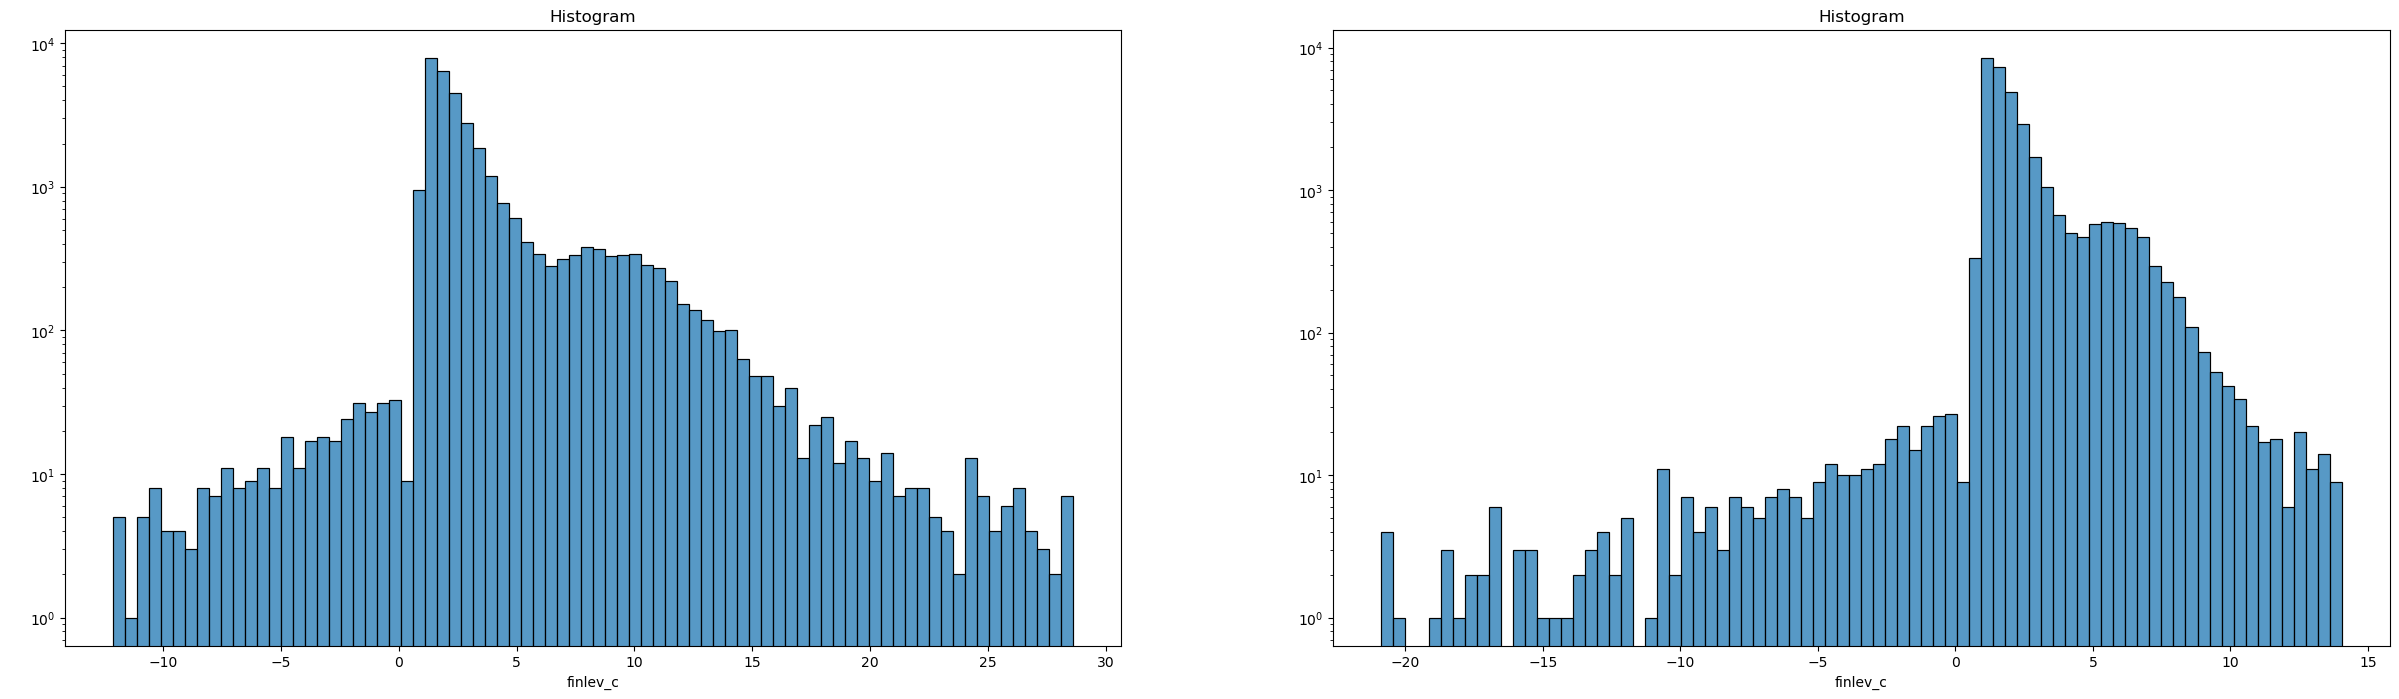

### inc_days

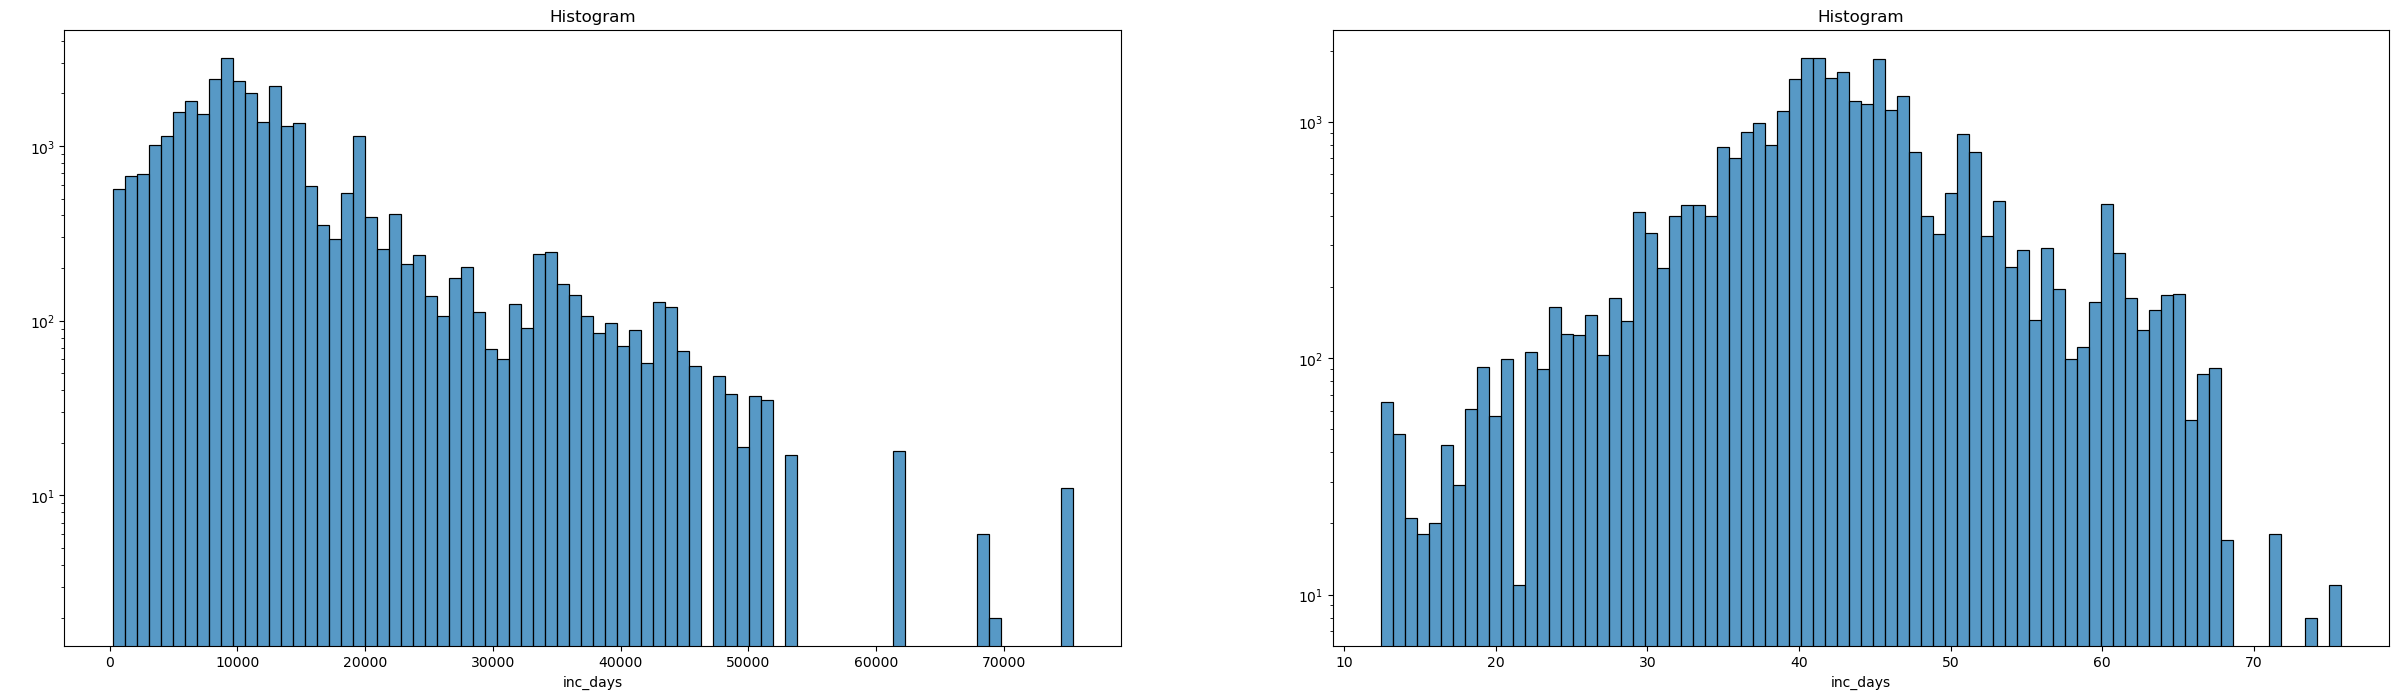

### ipo_days

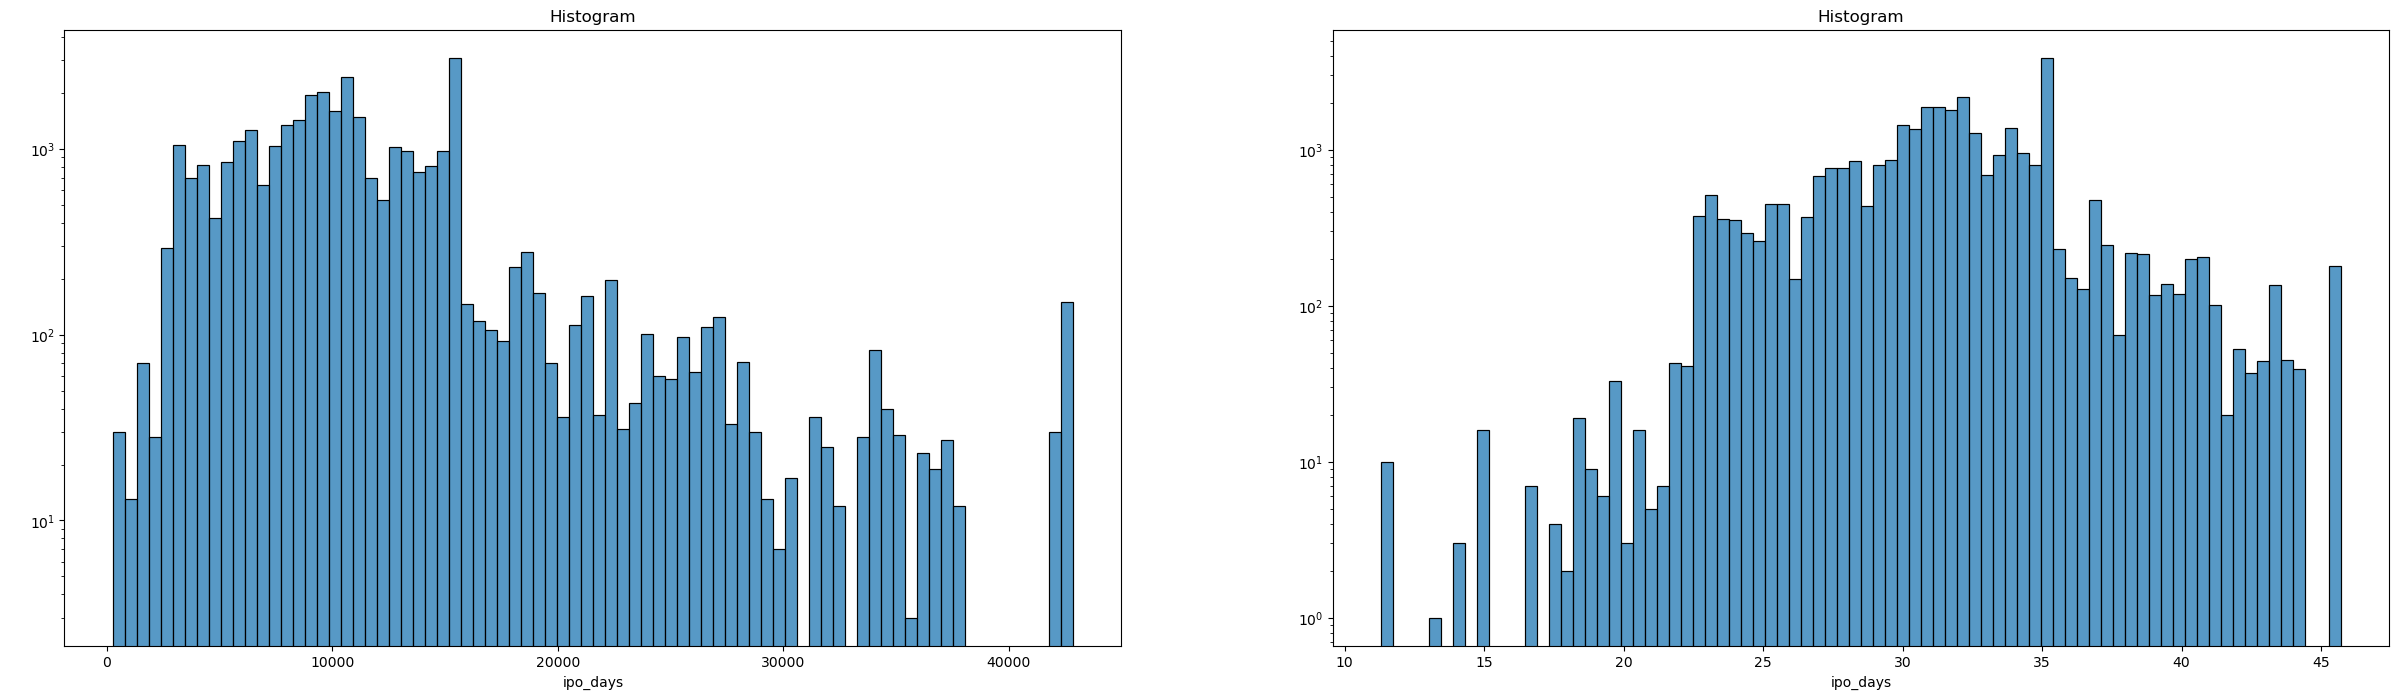

In [14]:
for feature in var_num:
    display(Markdown("### {feature}".format(feature=feature)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 8)

    # histogram original data
    sns.histplot(data_set[feature], log_scale = (False, True), bins = 80, ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel(' ')
    ax1.set_title('Histogram')

    # histogram log-transformed data
    sns.histplot(data_set_corrected[feature], log_scale = (False, True), bins = 80, ax=ax2)
    ax2.set_xlabel(feature)
    ax2.set_ylabel(' ')
    ax2.set_title('Histogram')

    plt.show()

## ----------------------------------------

## Standardization (Numerical Variables)
- also known as feature scaling or nominalization (Hull p.24; Drobetz et al.)
- subtracting cross-sectional mean and dividing by cross-sectional standard deviation

In [15]:
data_set_scaled = data_set_corrected.copy()

In [16]:
scaler = StandardScaler()
data_set_scaled[var_num] = scaler.fit_transform(data_set_scaled[var_num])
display(data_set_scaled.head())

,ric,year,symbol,naics,tau_cop_3y,tau_cop_5y,fam_target_ori,rot_target_ori,tau_target_ori,par_target_ori,year_hor,tau_target_hor,fam_target_hor,rot_target_hor,par_target_hor,debt,tass,rtass,tlia,tsheq,comeq,comsi,noa,wc,ndebt,capex,ncfo,levfcf,nincam,gp,trev,ebit,roe,roce,rnoa,ebitmarg,shouts,mc,ptbvps,oips,cfps,ros_c,prof_c,finlev_c,inc_days,ipo_days
3,A.ITC,2004,A,Manufacturing,0.485946,0.425203,frank,0,0.462612,[[5.09499262]],2005,0.371968,frank,0,[[3.78686423]],0.724119,0.934727,-0.322801,0.034067,0.627112,0.667573,1.636099,0.057001,2.209911,-3.080019,0.455358,0.377481,0.557085,0.373503,0.872499,1.050527,-0.209038,-0.371659,-0.617933,-0.347687,-0.538646,1.750710,1.375897,0.207180,-0.428181,-0.337362,-0.417621,-0.093411,-0.366484,-0.319891,-0.37766
4,A.ITC,2005,A,Manufacturing,0.451243,0.457525,frank,0,0.371968,[[3.78686423]],2006,0.384465,gaussian,0,[[0.56787014]],-2.241748,0.904411,-0.125101,-0.058830,0.769603,0.815436,1.675887,-0.056930,1.888018,-6.019859,0.675604,0.600123,0.767432,0.308105,0.972029,1.067135,0.062047,-0.222672,-0.369045,-0.020705,-0.396042,1.757078,1.518272,0.404743,-0.353201,-0.305037,-0.260991,-0.126606,-0.492430,-0.319891,-0.37766
5,A.ITC,2006,A,Manufacturing,0.396258,0.457678,gaussian,0,0.384465,[[0.56787014]],2007,0.379842,gumbel,180,[[1.61249331]],0.842004,0.951377,2.710760,0.048729,0.649254,0.690543,1.711115,0.149258,1.810818,-2.022006,0.850563,0.342006,0.389434,4.636146,1.114784,1.102818,0.277253,1.909661,-0.148505,0.222685,-0.260717,1.626717,1.474888,0.418459,-0.261741,0.276630,-0.135573,0.056585,-0.359963,-0.319891,-0.37766
6,A.ITC,2007,A,Manufacturing,0.368536,0.425415,gumbel,180,0.379842,[[1.61249331]],2008,0.573060,gumbel,180,[[2.34224801]],0.994720,0.964709,0.661017,0.108090,0.532532,0.569482,1.734718,0.262343,1.460667,-0.066225,0.762686,0.667285,0.818548,0.785464,1.261756,1.154780,0.396193,0.581183,-0.077263,0.151476,-0.209164,1.562732,1.463126,0.575732,-0.193956,-0.061476,-0.089937,0.288953,-0.249367,-0.319891,-0.37766
7,A.ITC,2008,A,Manufacturing,0.449823,0.429873,gumbel,180,0.573060,[[2.34224801]],2009,0.557232,student,0,[[0.76773438]\n [2.88717691]],1.003267,0.924343,0.809965,0.120623,0.338112,0.368001,1.748967,0.218192,1.327788,0.058889,0.762686,0.461669,0.570003,0.868561,1.366715,1.193338,0.611192,0.944631,0.183405,0.339715,-0.081537,1.524972,1.129583,0.123389,-0.061202,0.012943,0.020378,0.694797,-0.112826,-0.319891,-0.37766


### debt

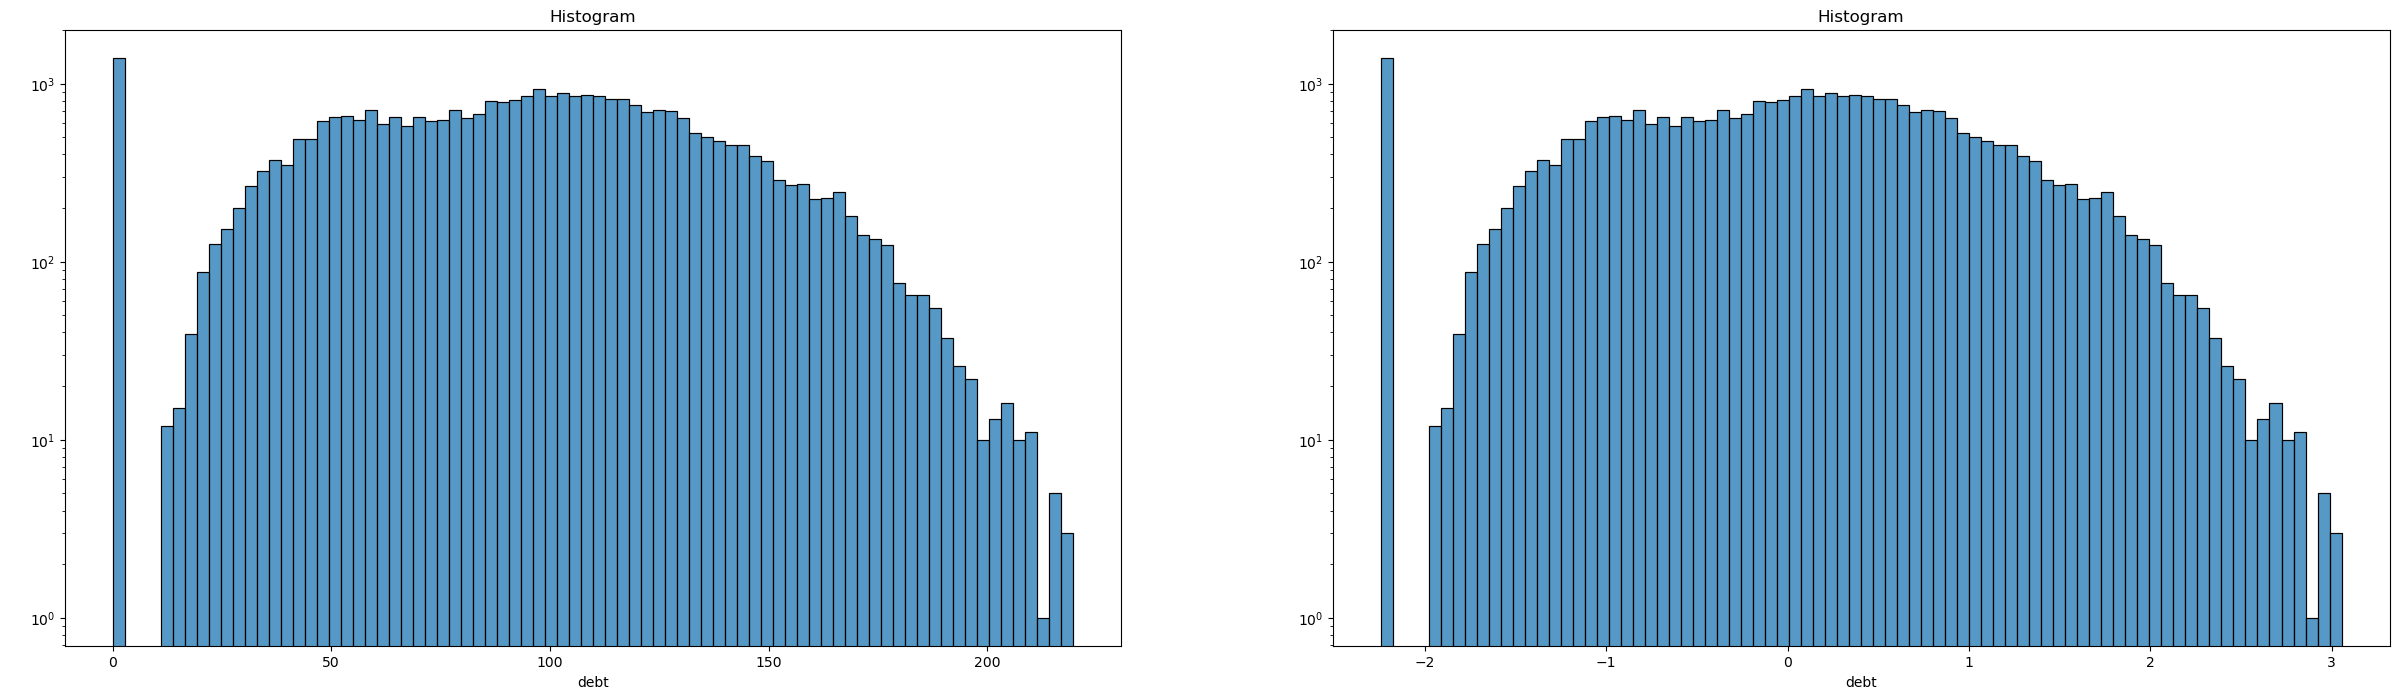

### tass

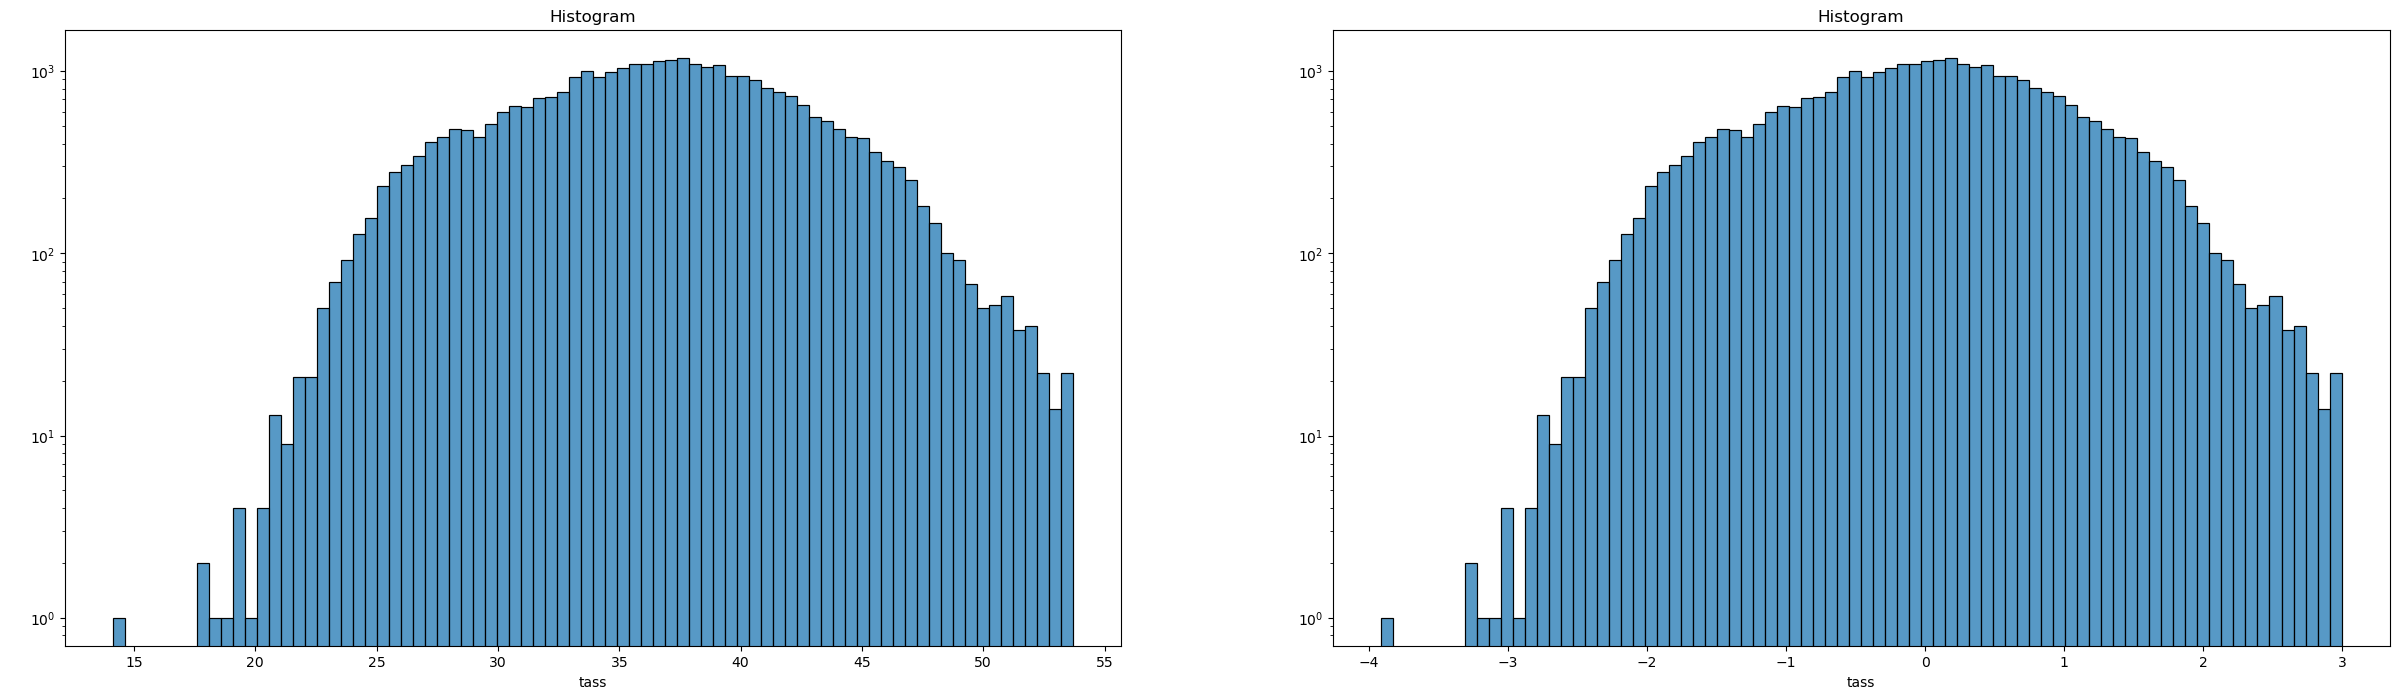

### rtass

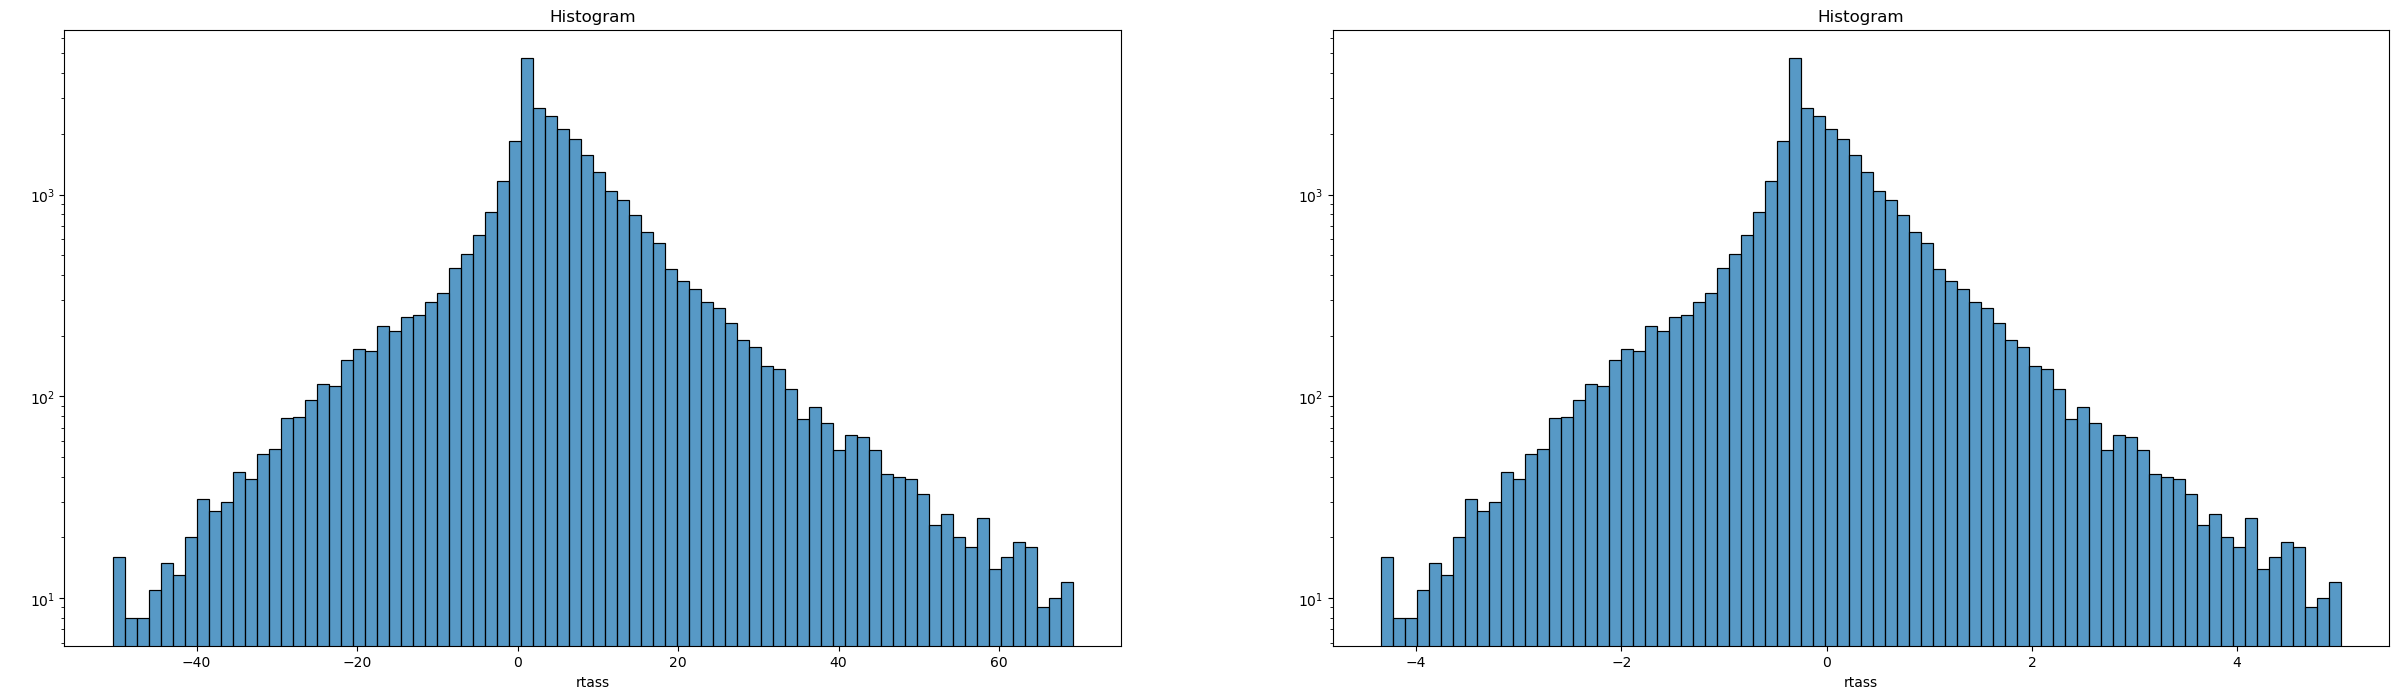

### tlia

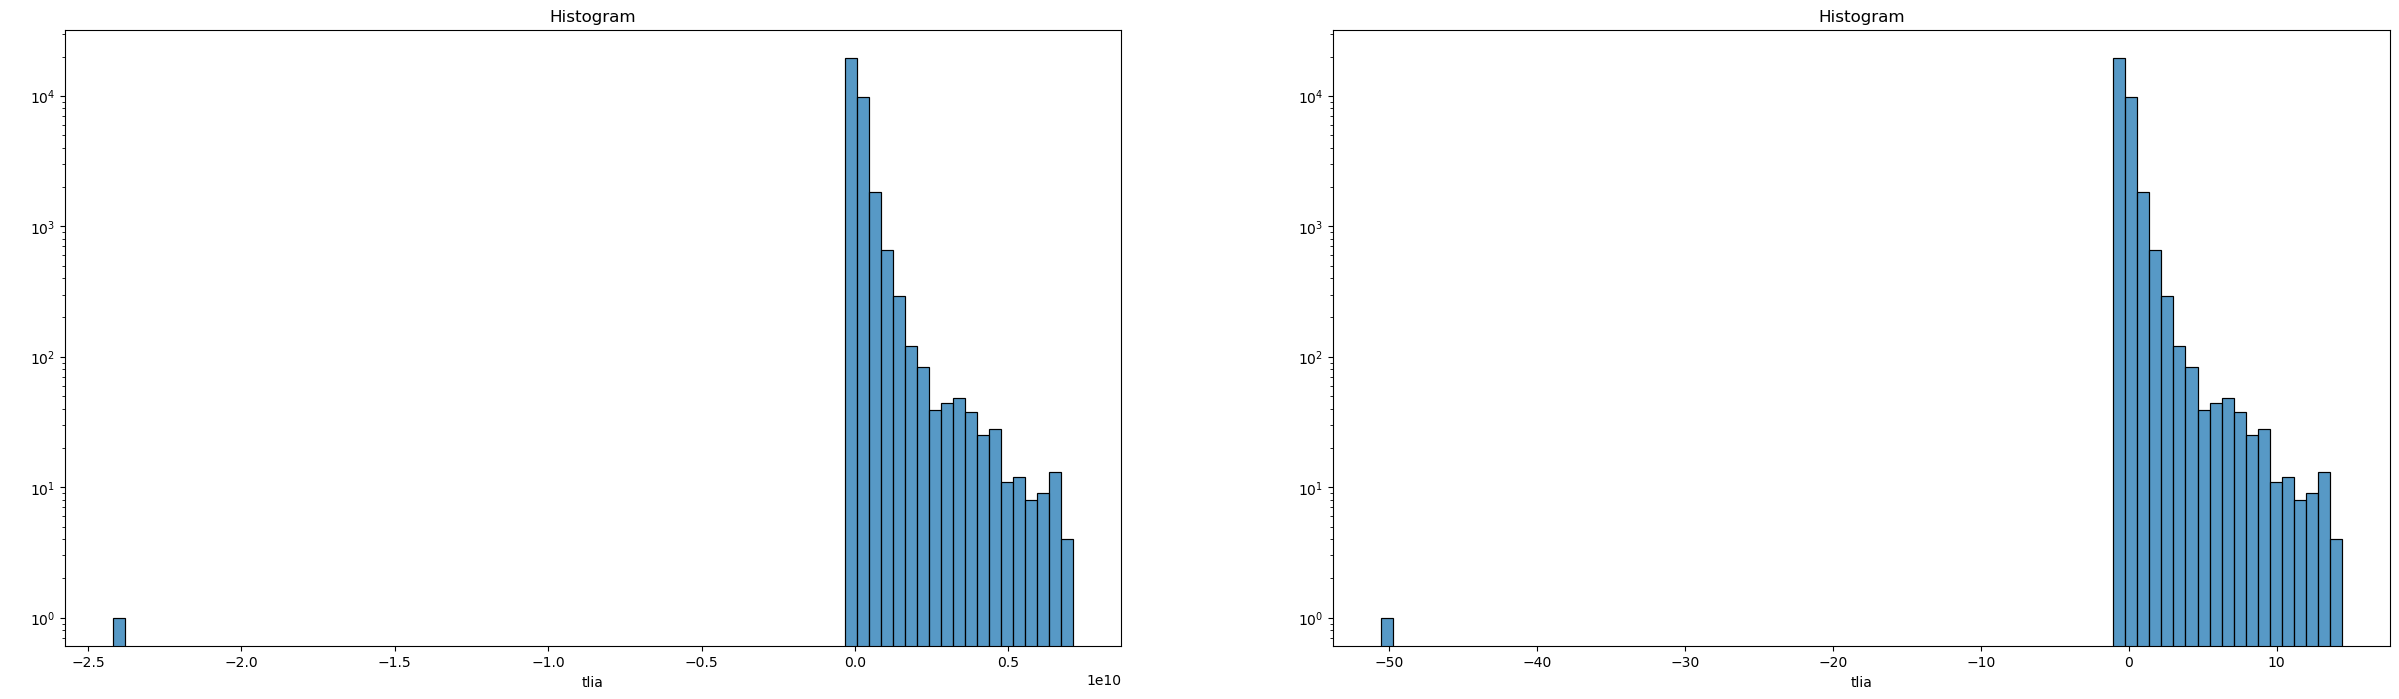

### tsheq

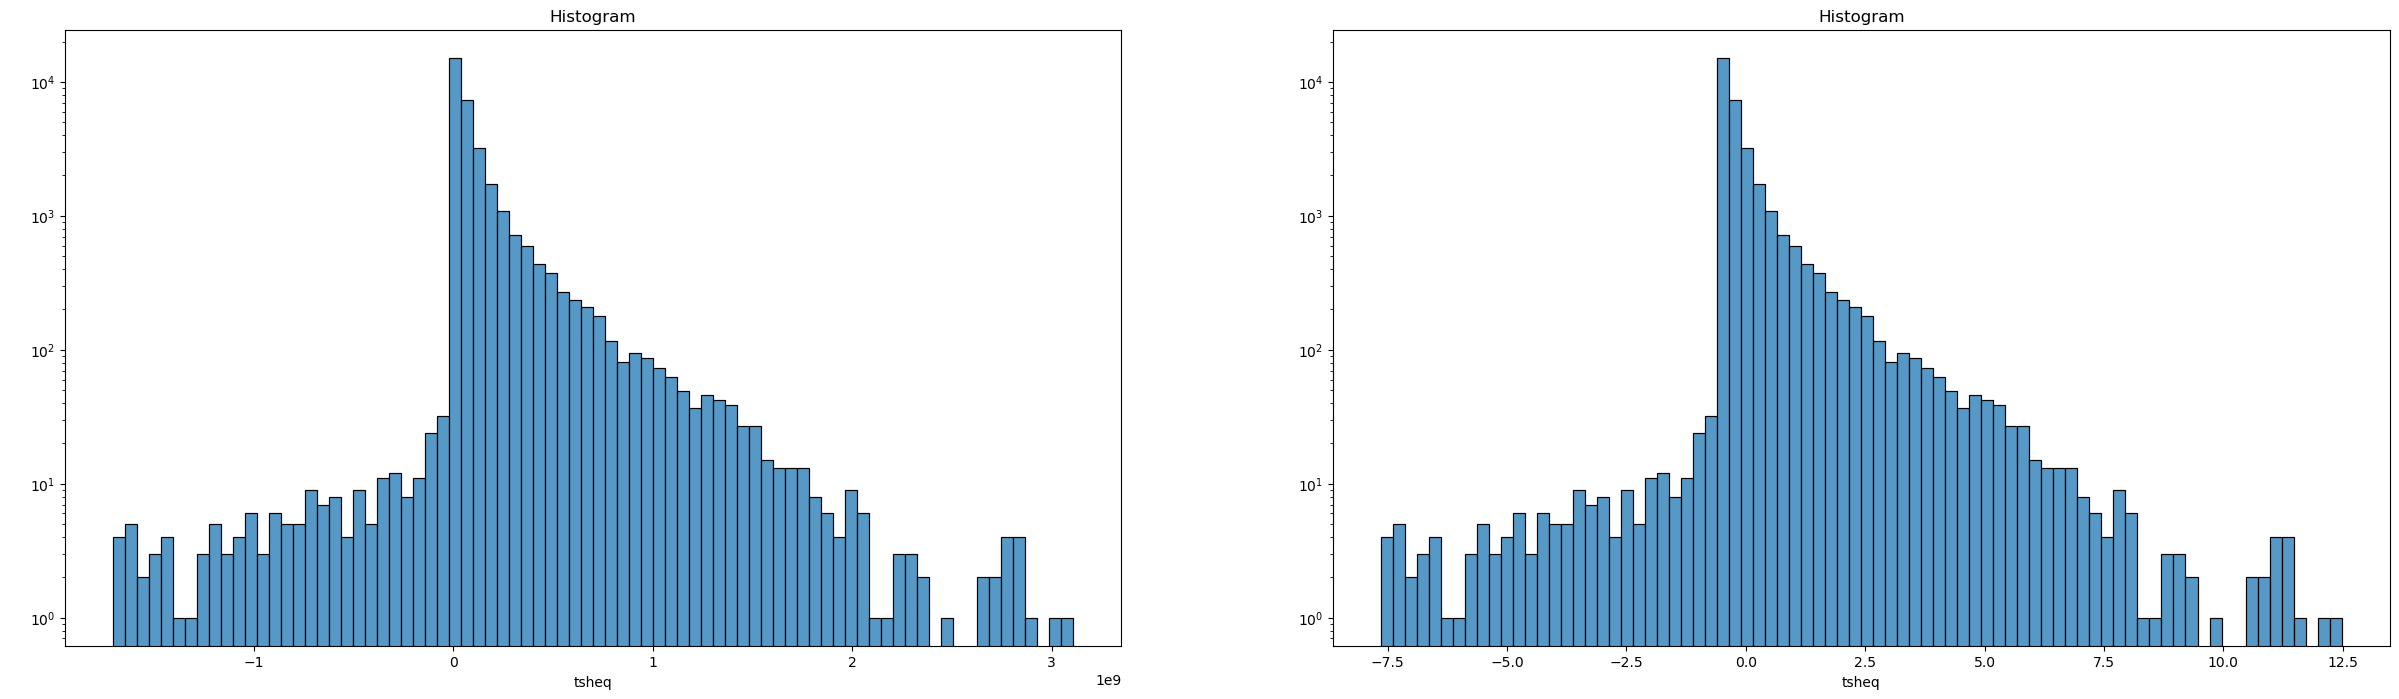

### comeq

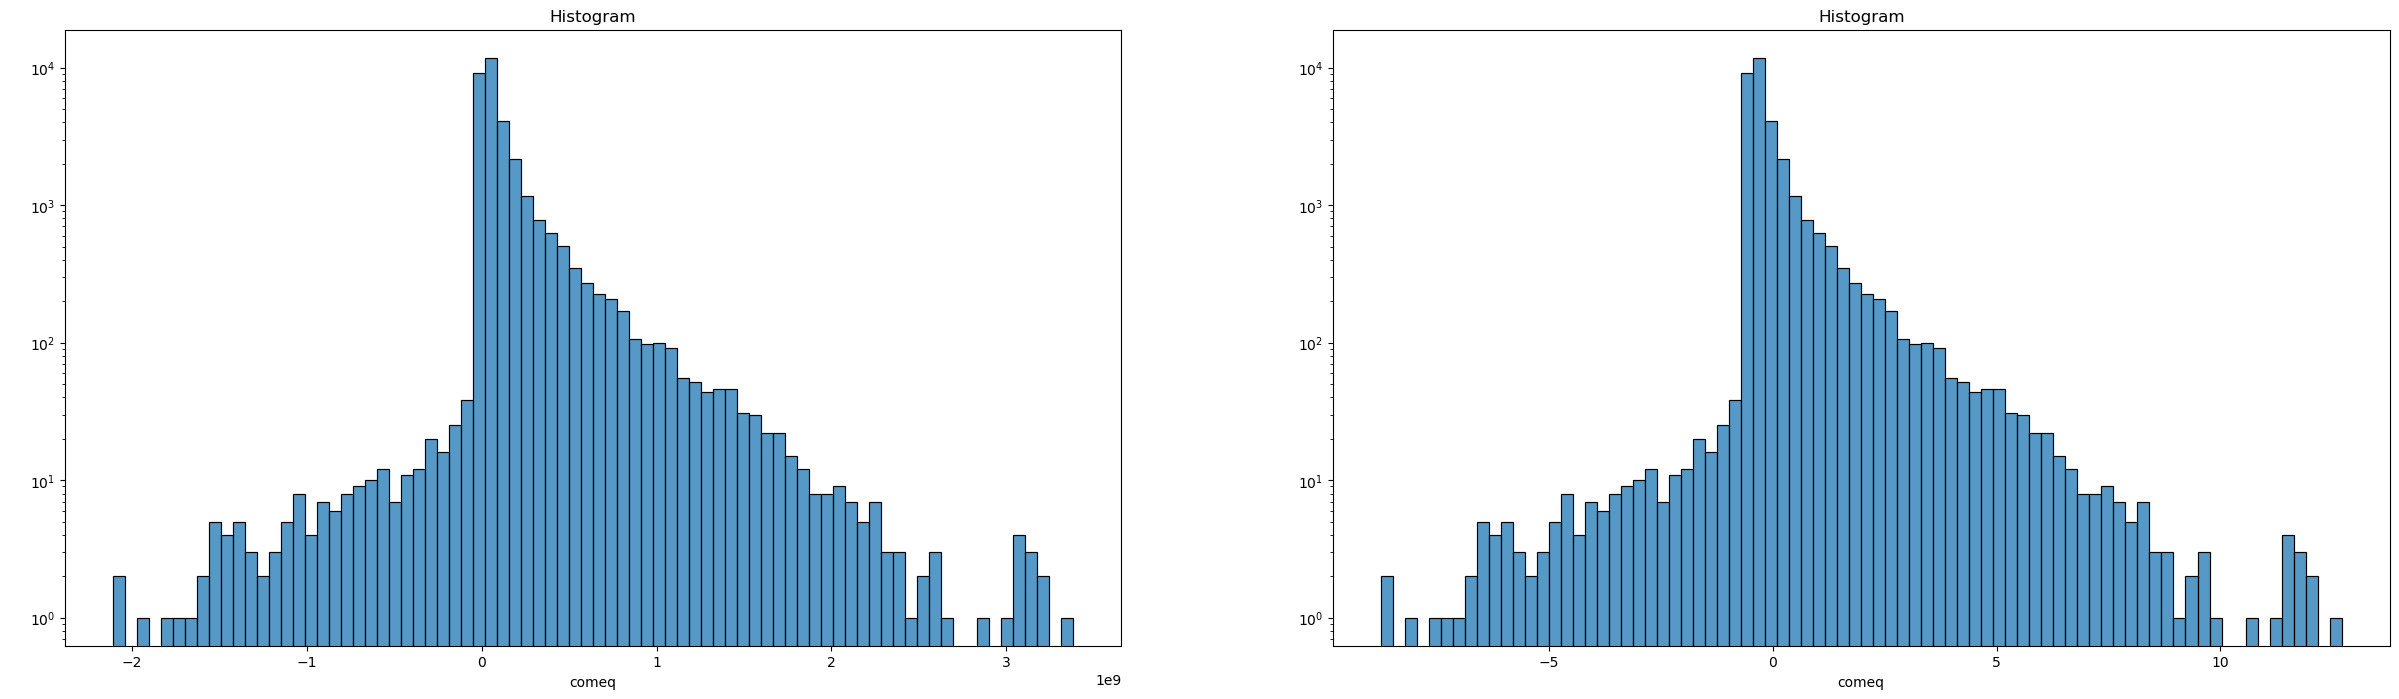

### comsi

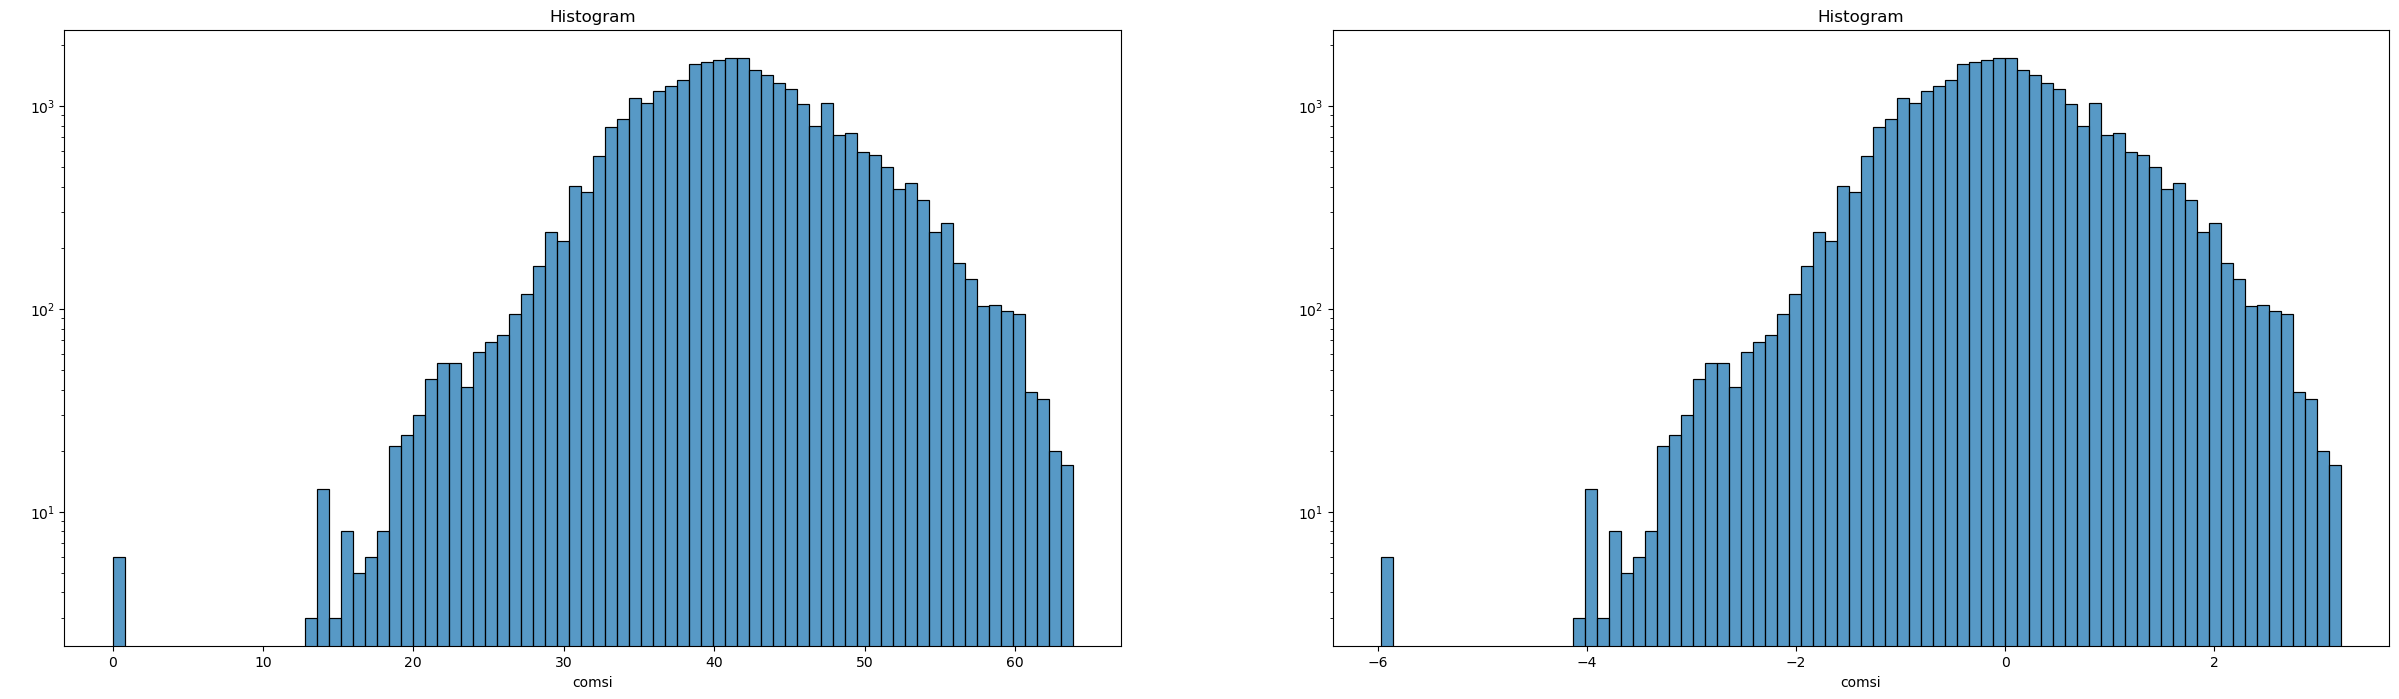

### noa

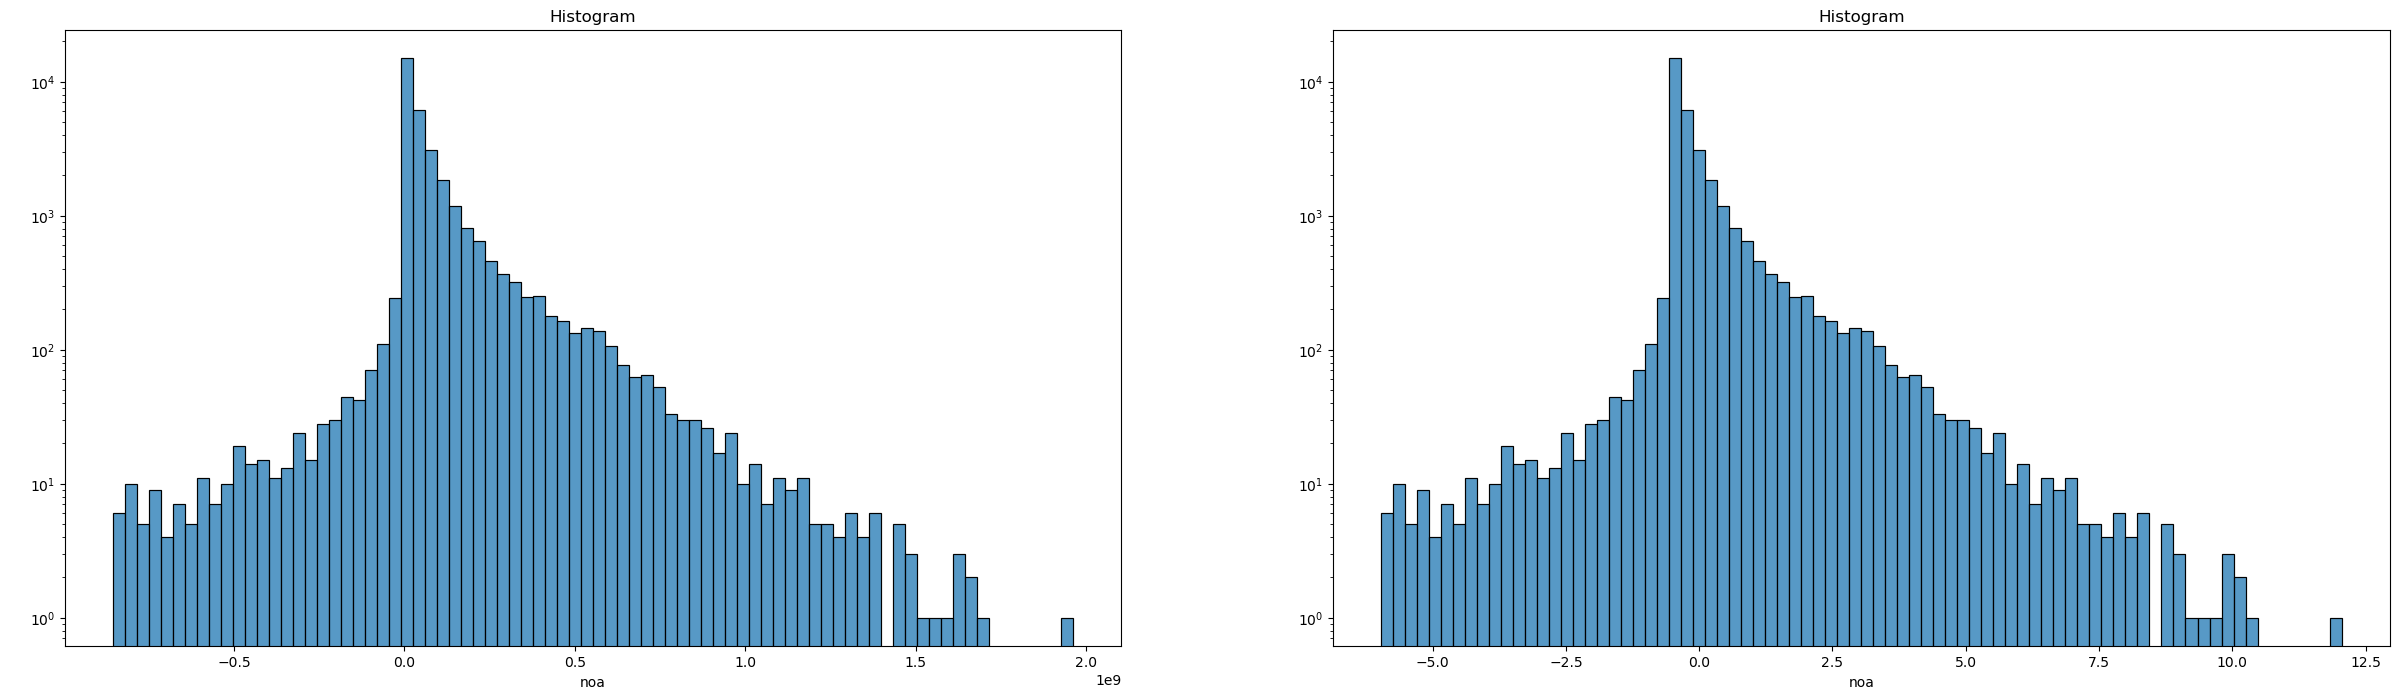

### wc

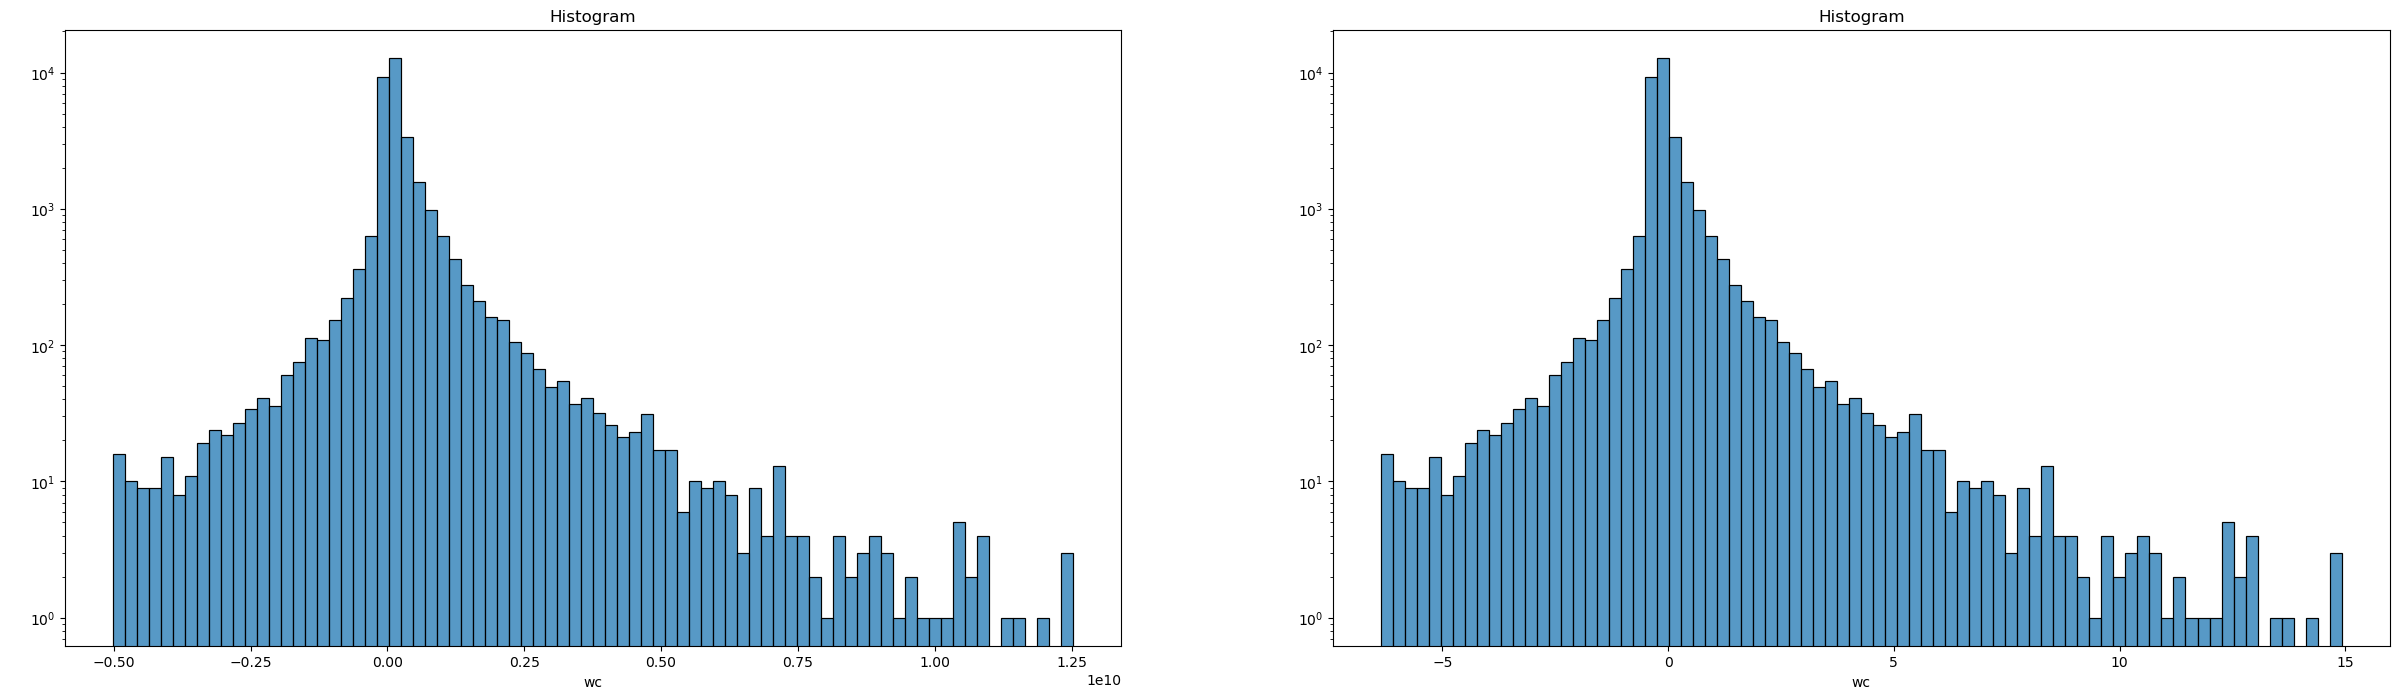

### ndebt

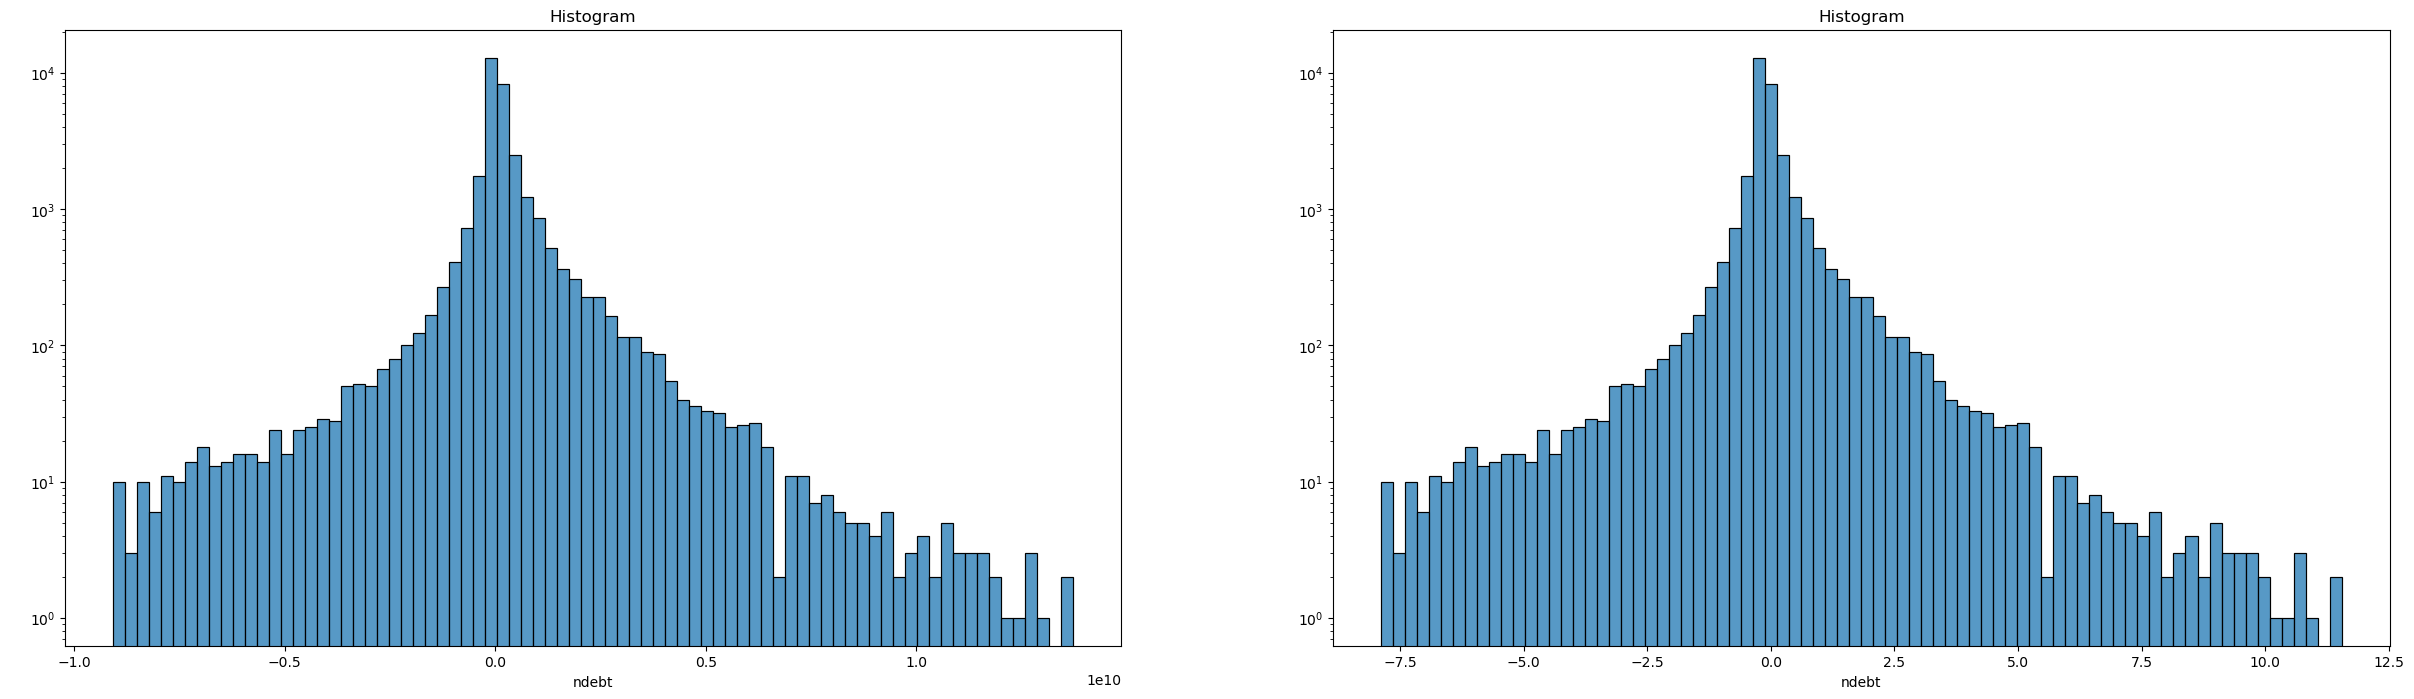

### capex

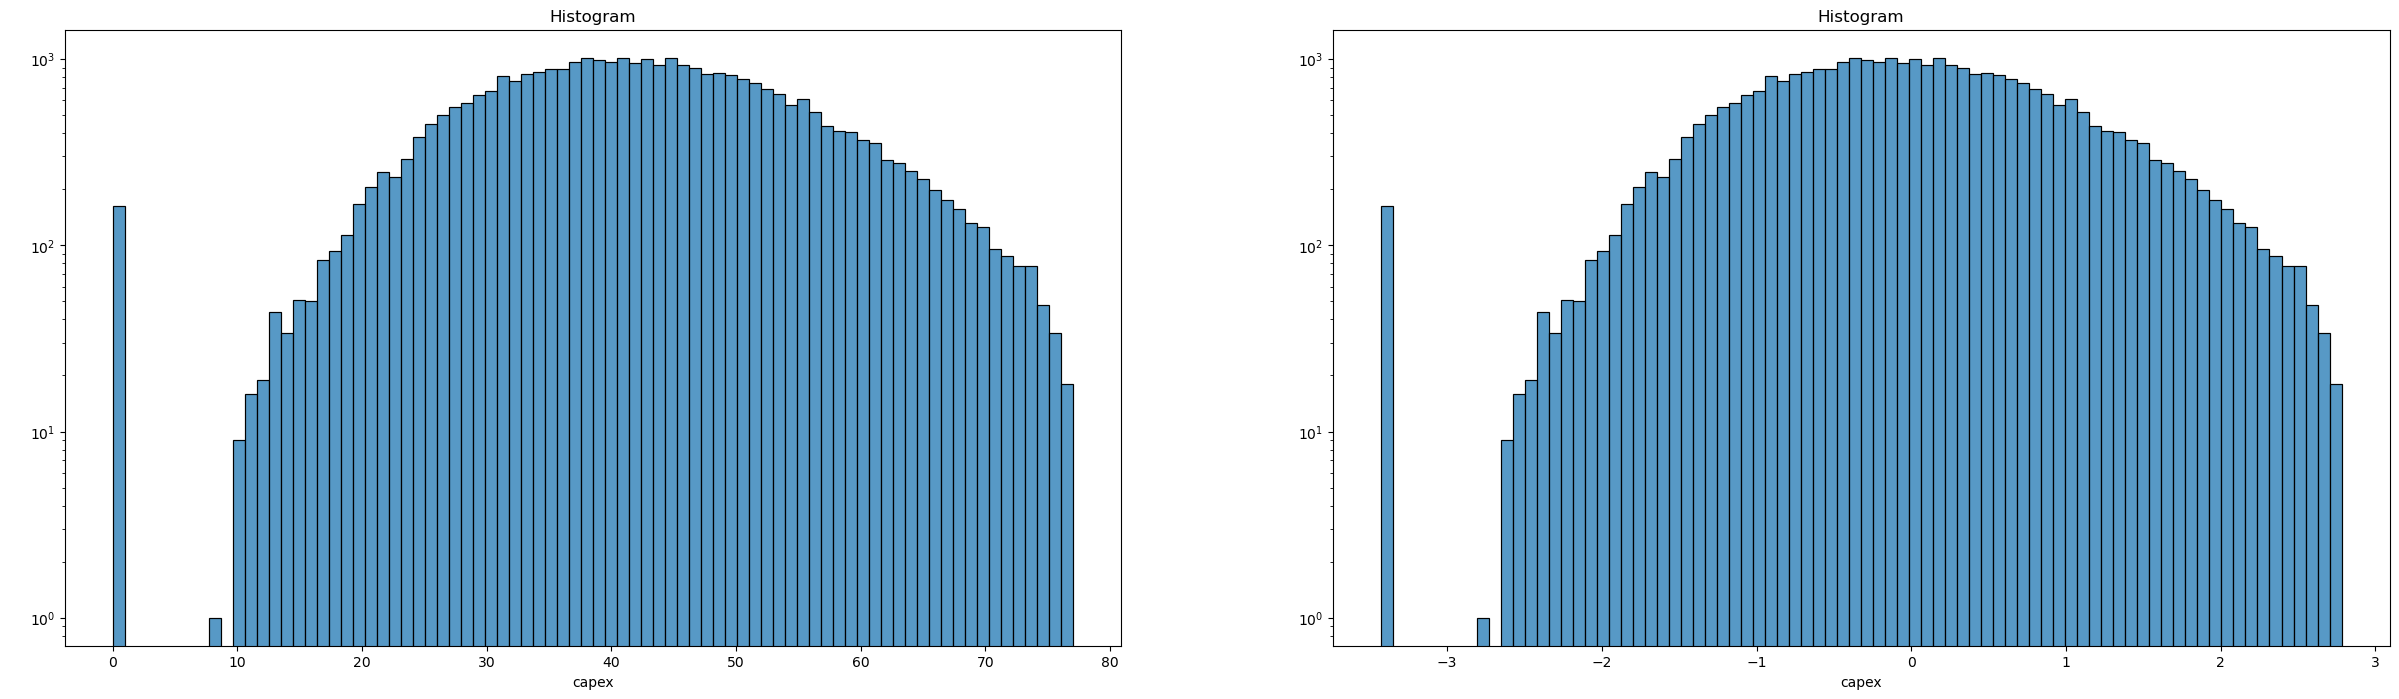

### ncfo

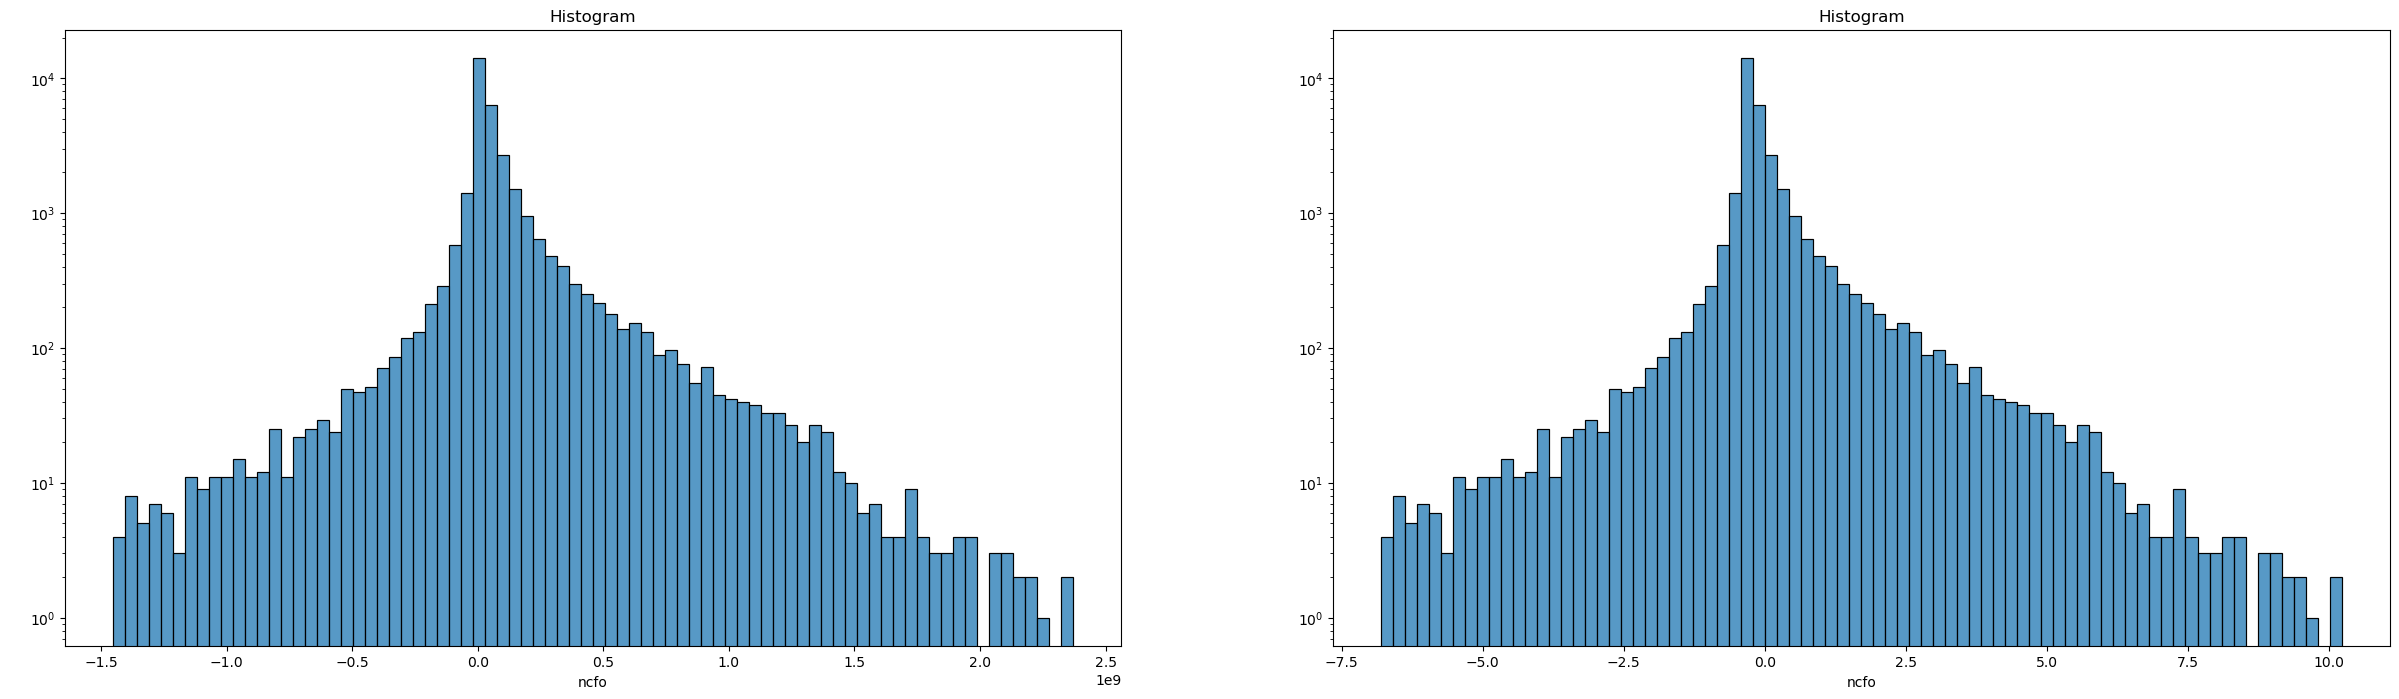

### levfcf

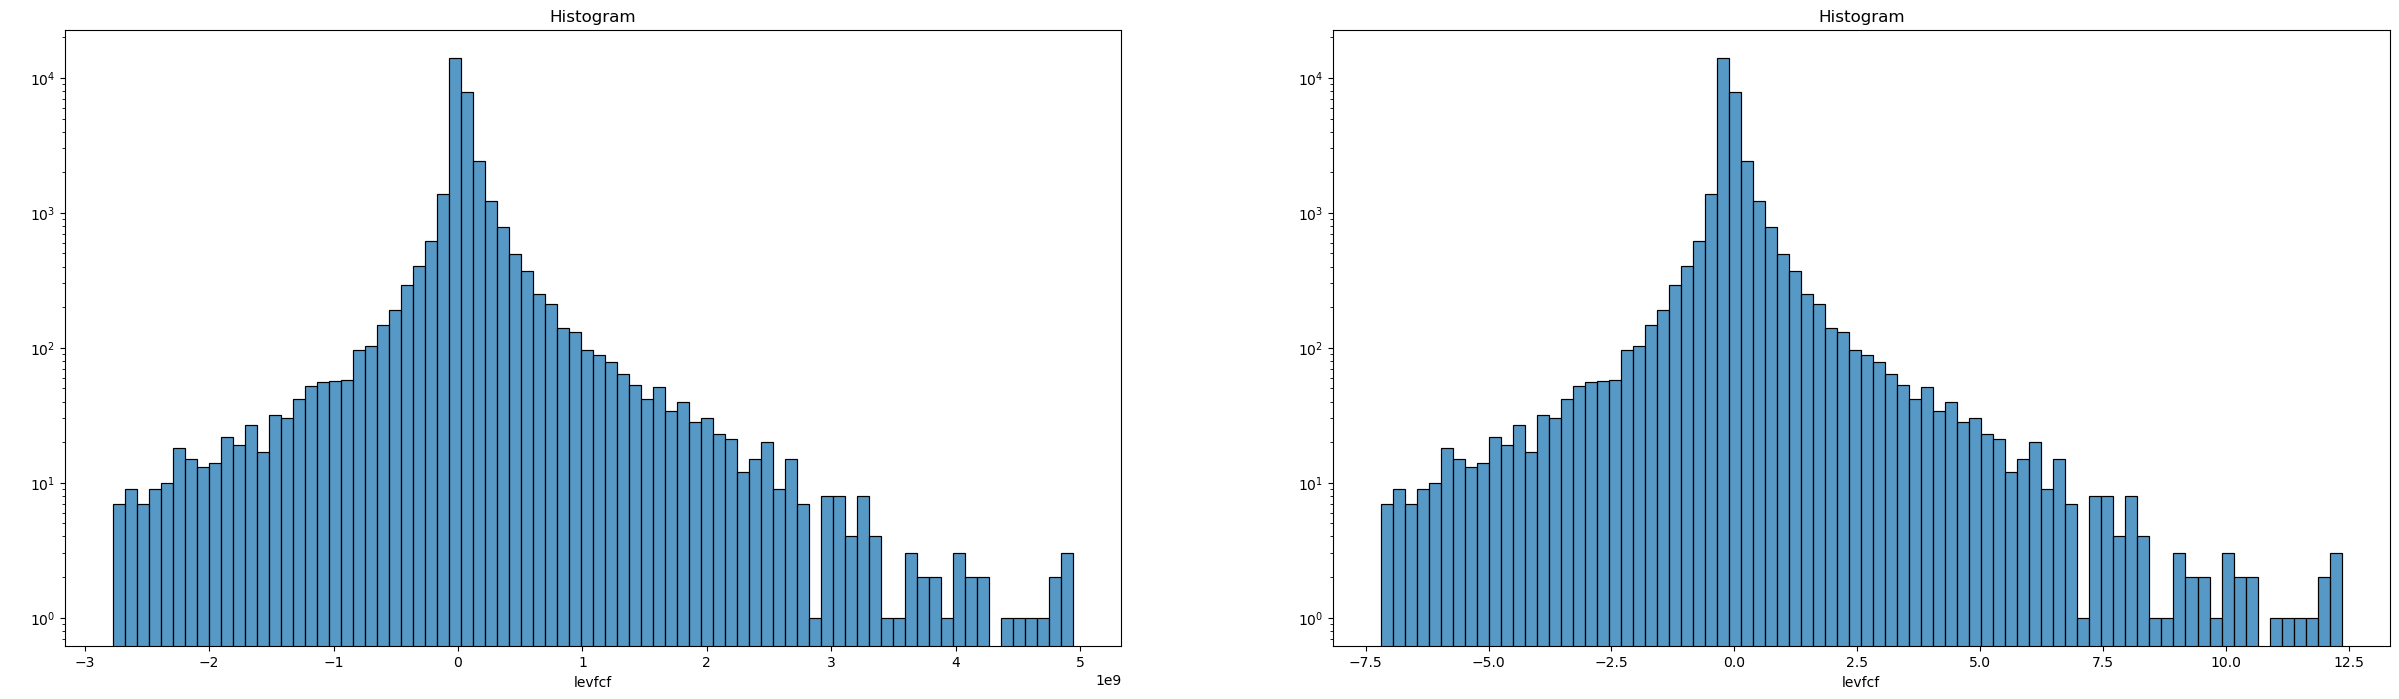

### nincam

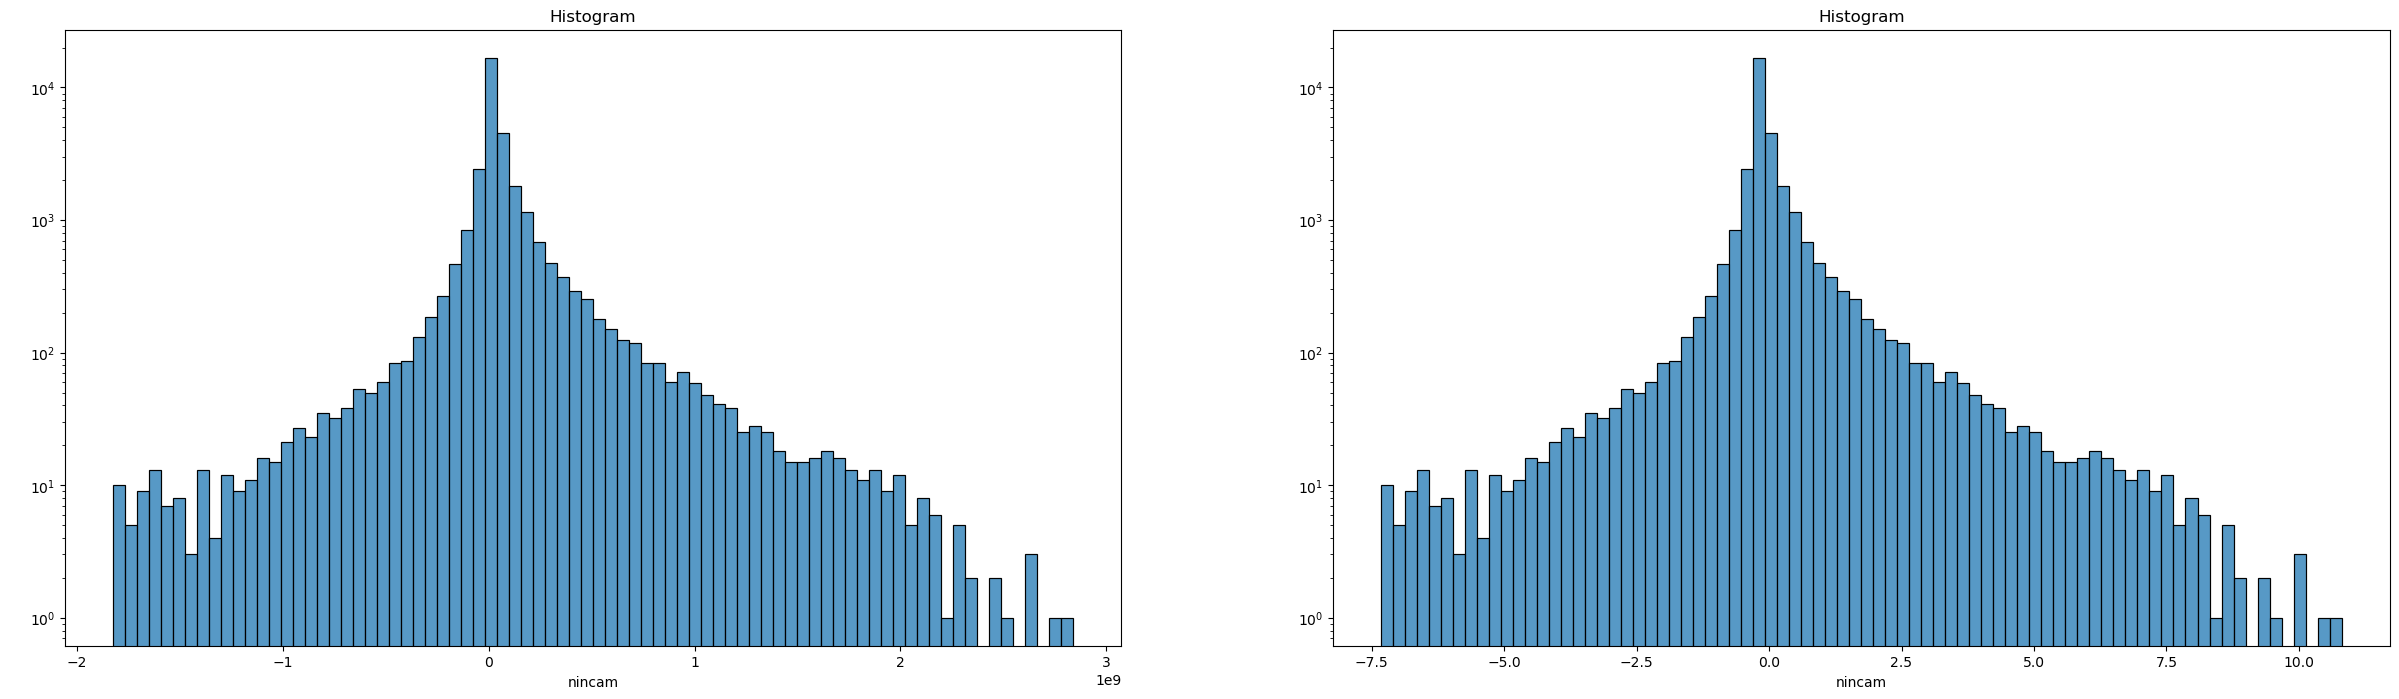

### gp

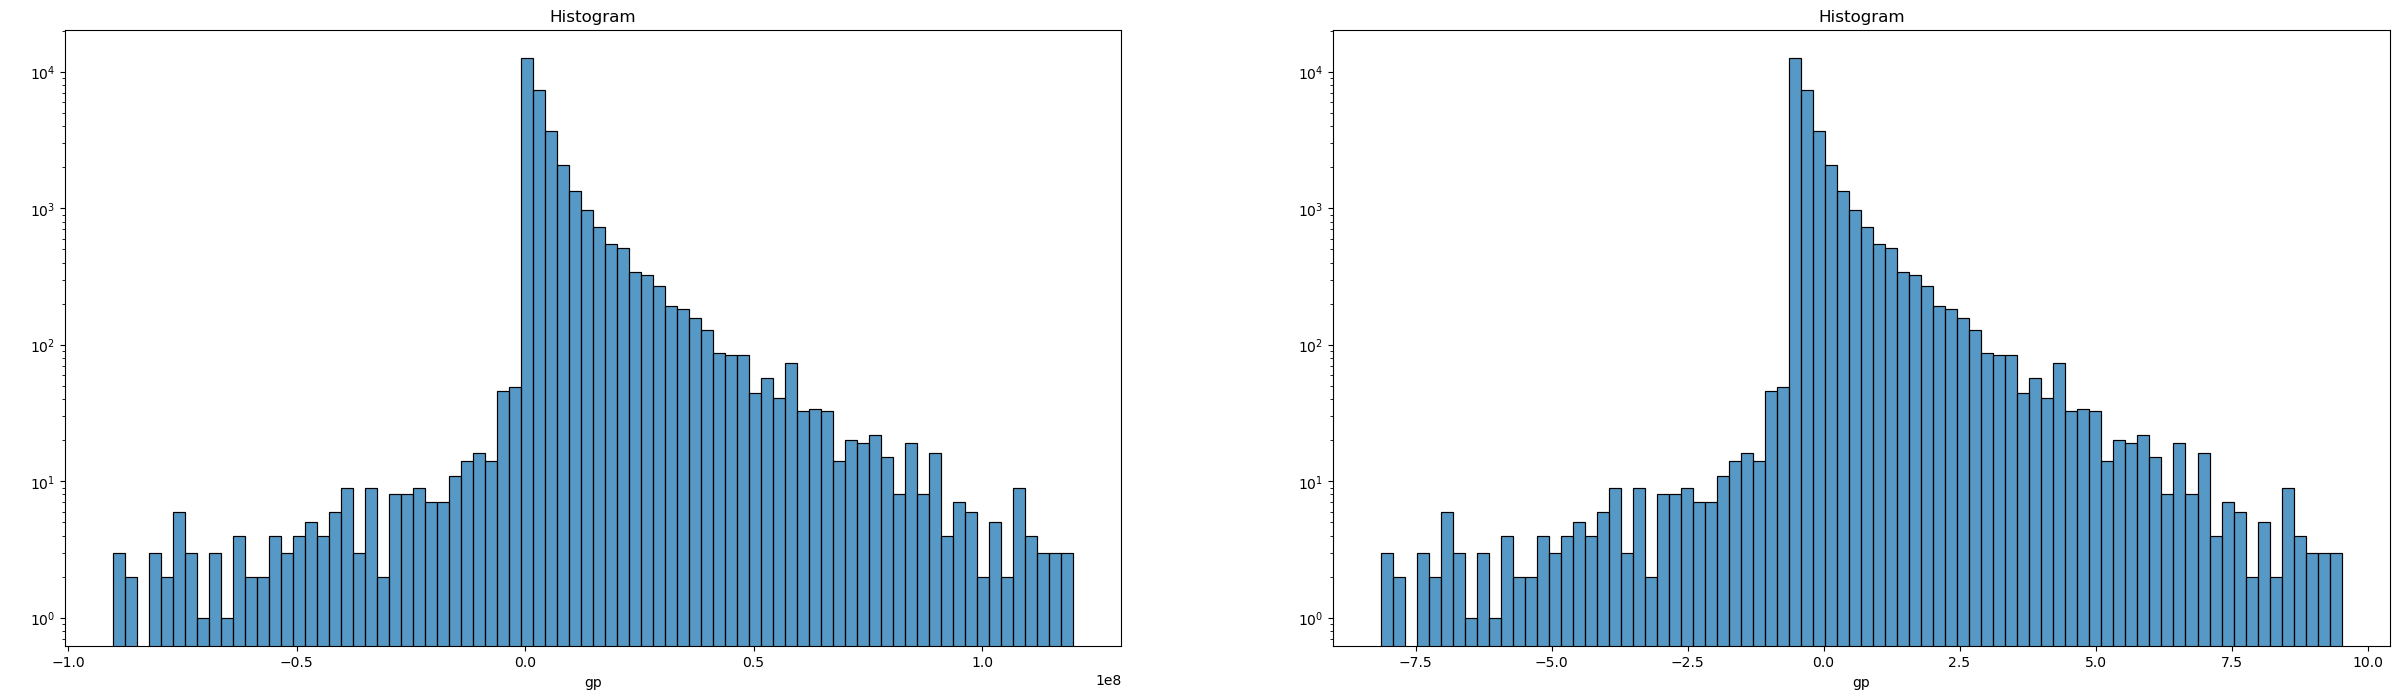

### trev

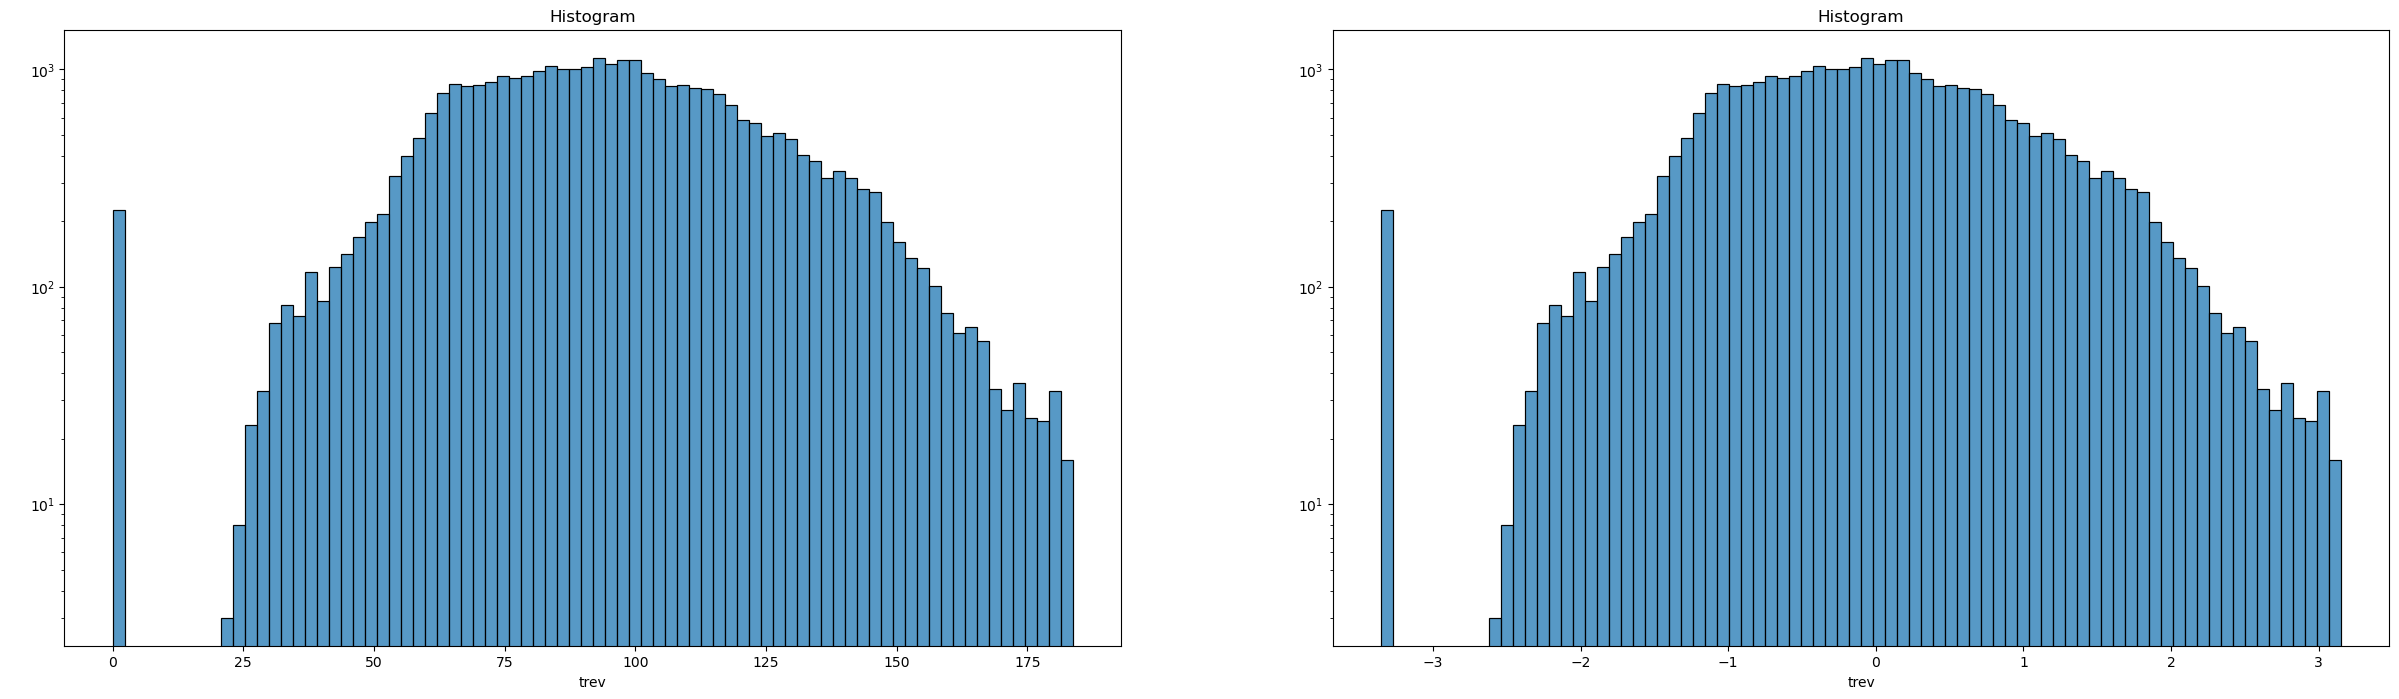

### ebit

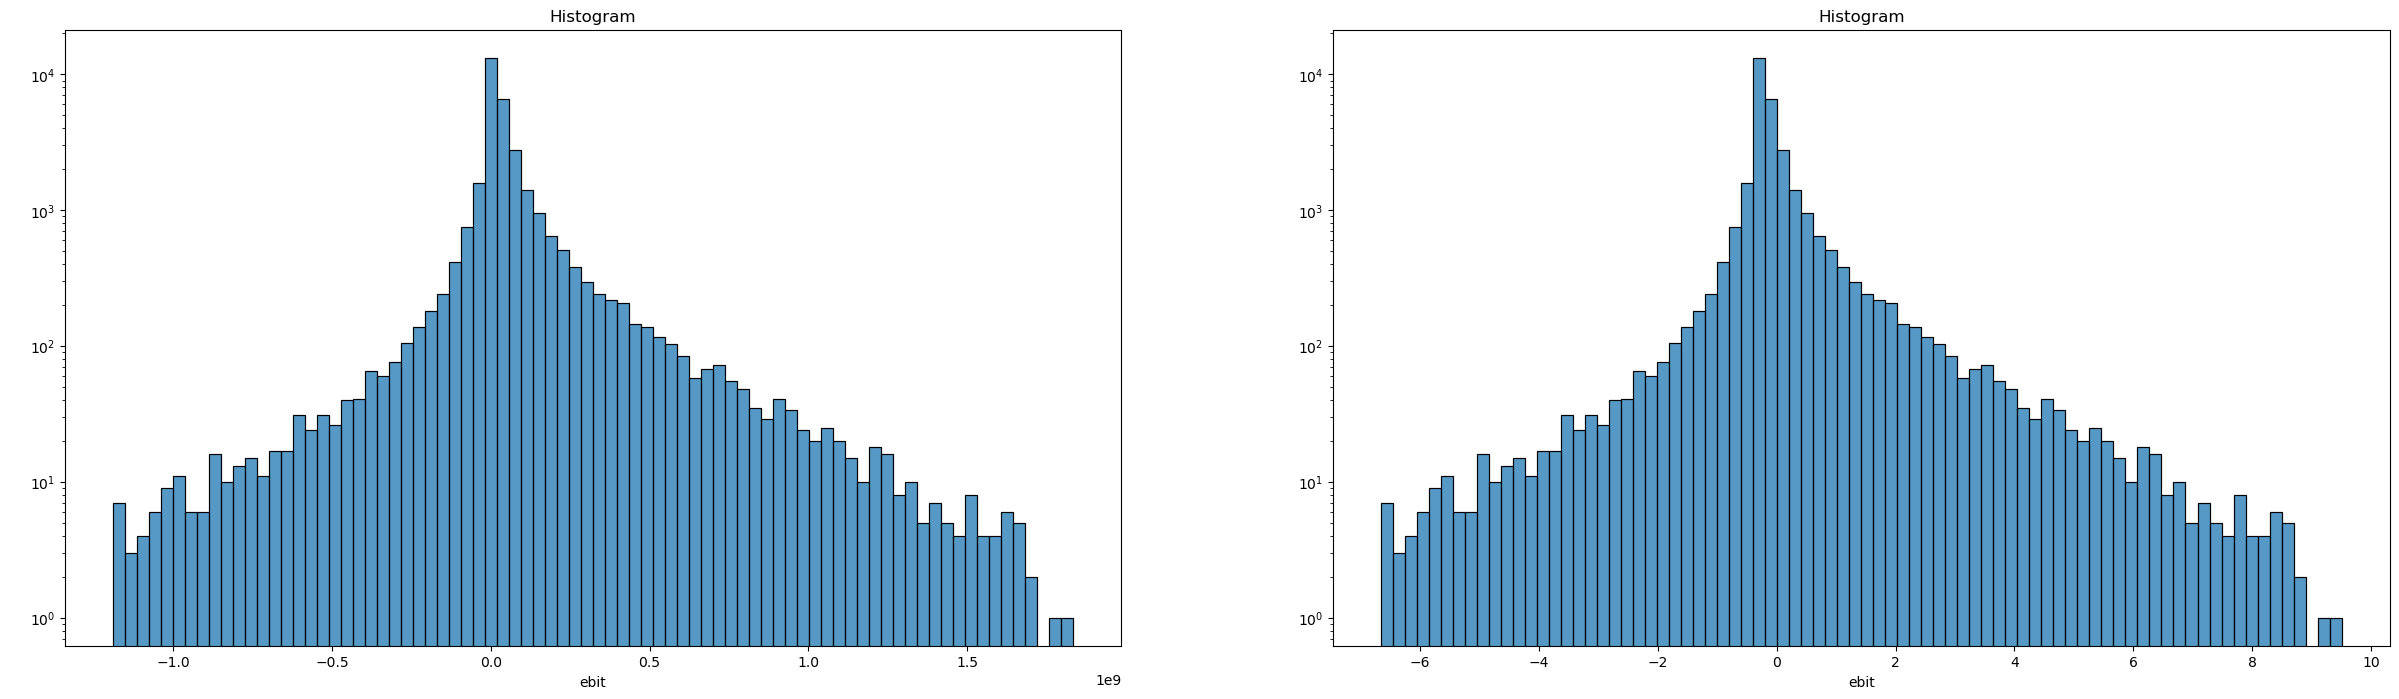

### roe

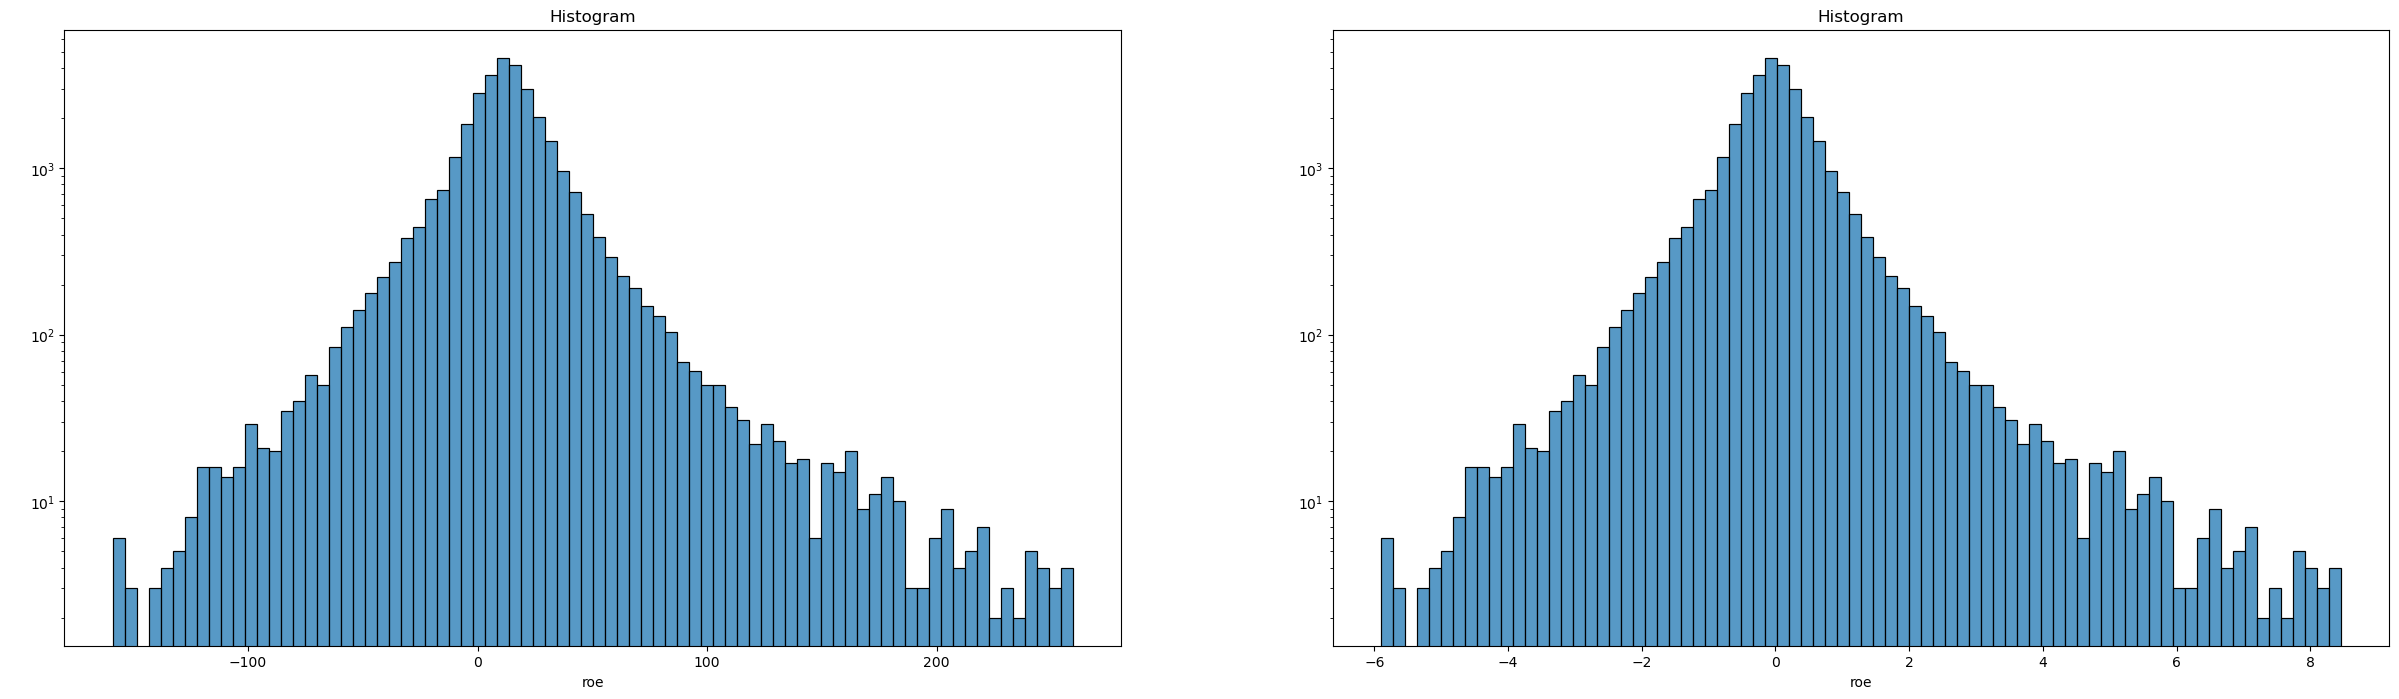

### roce

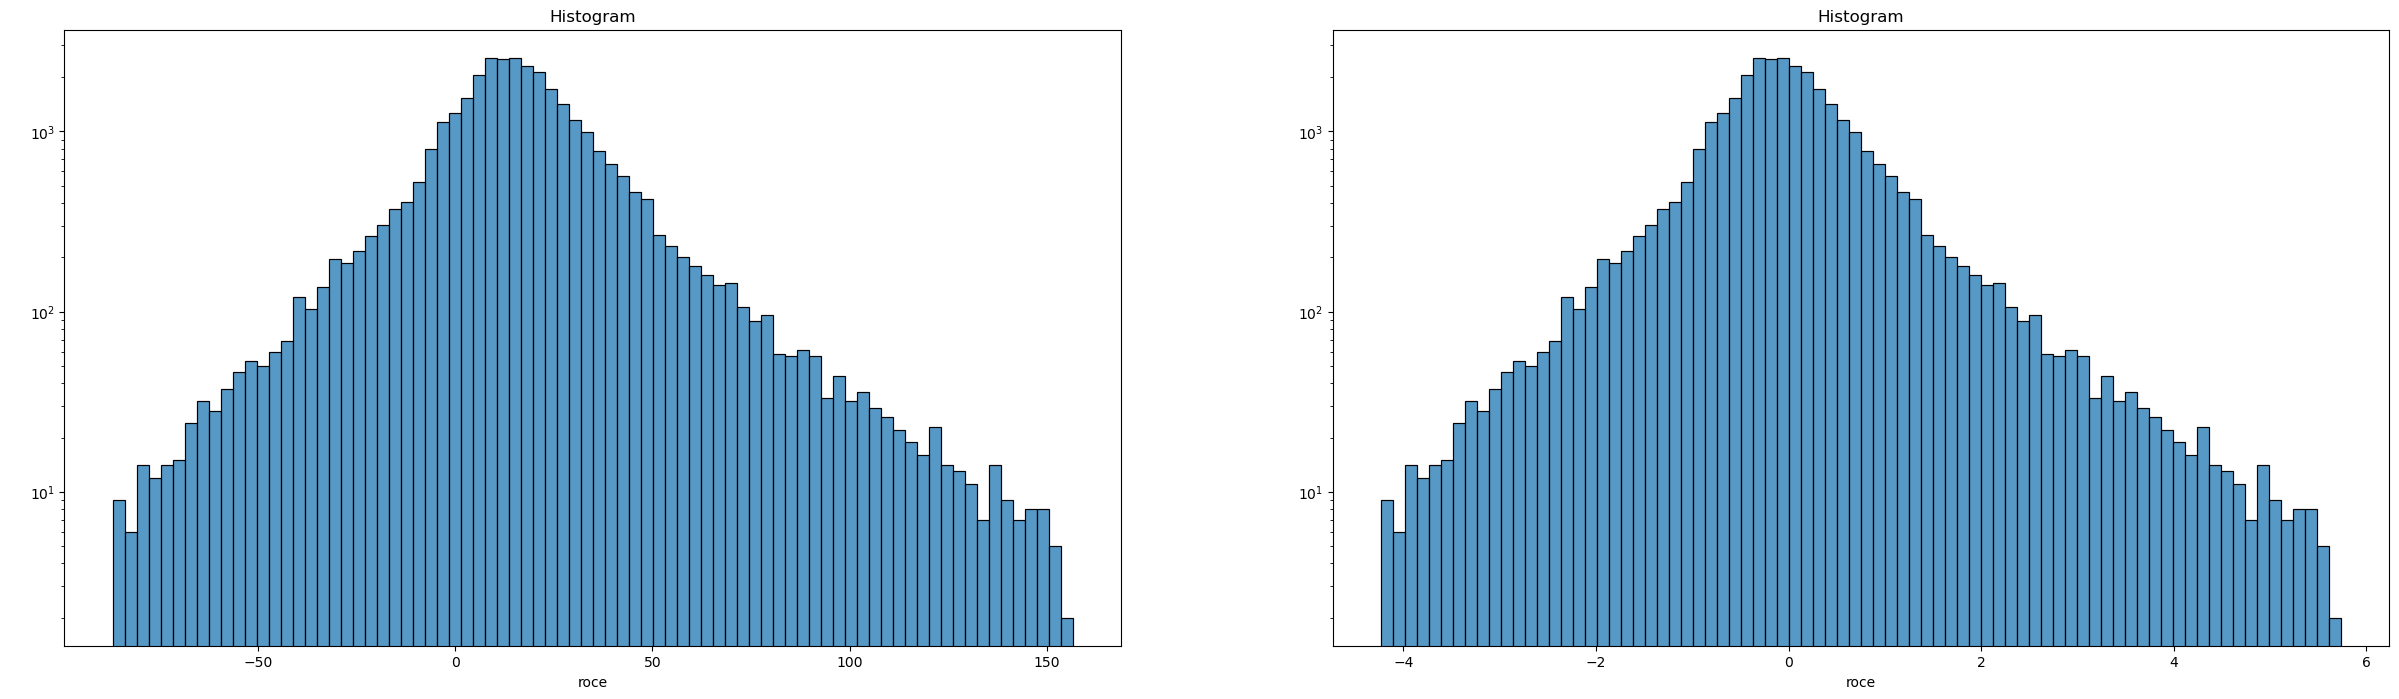

### rnoa

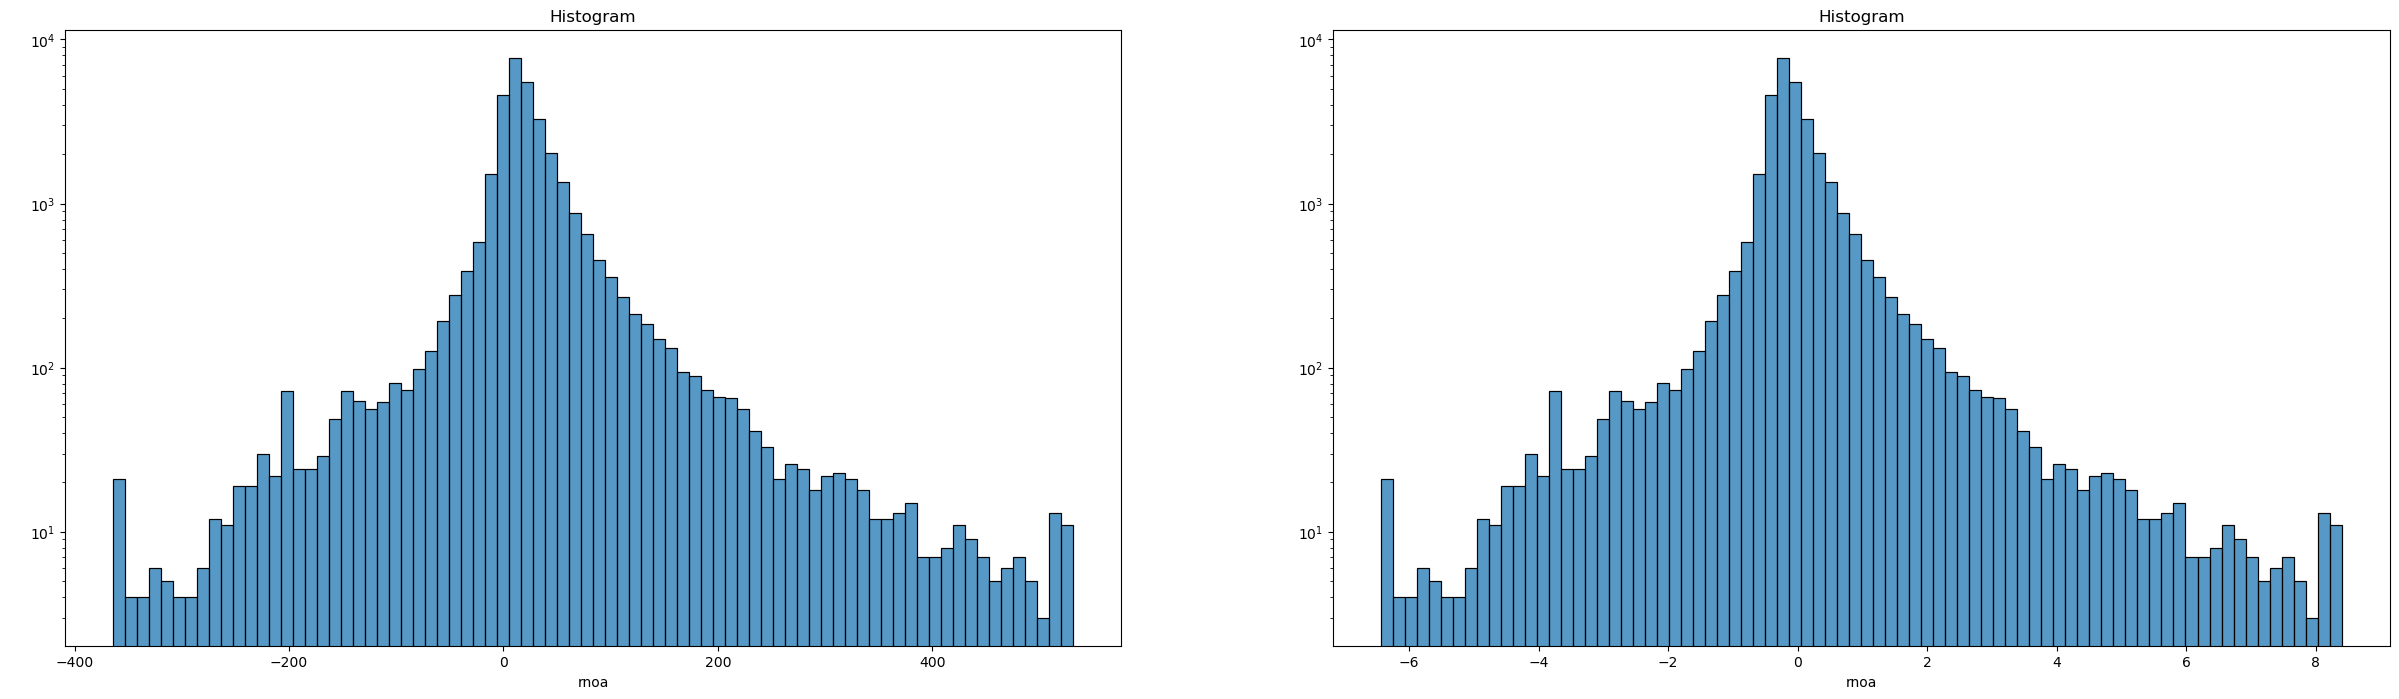

### ebitmarg

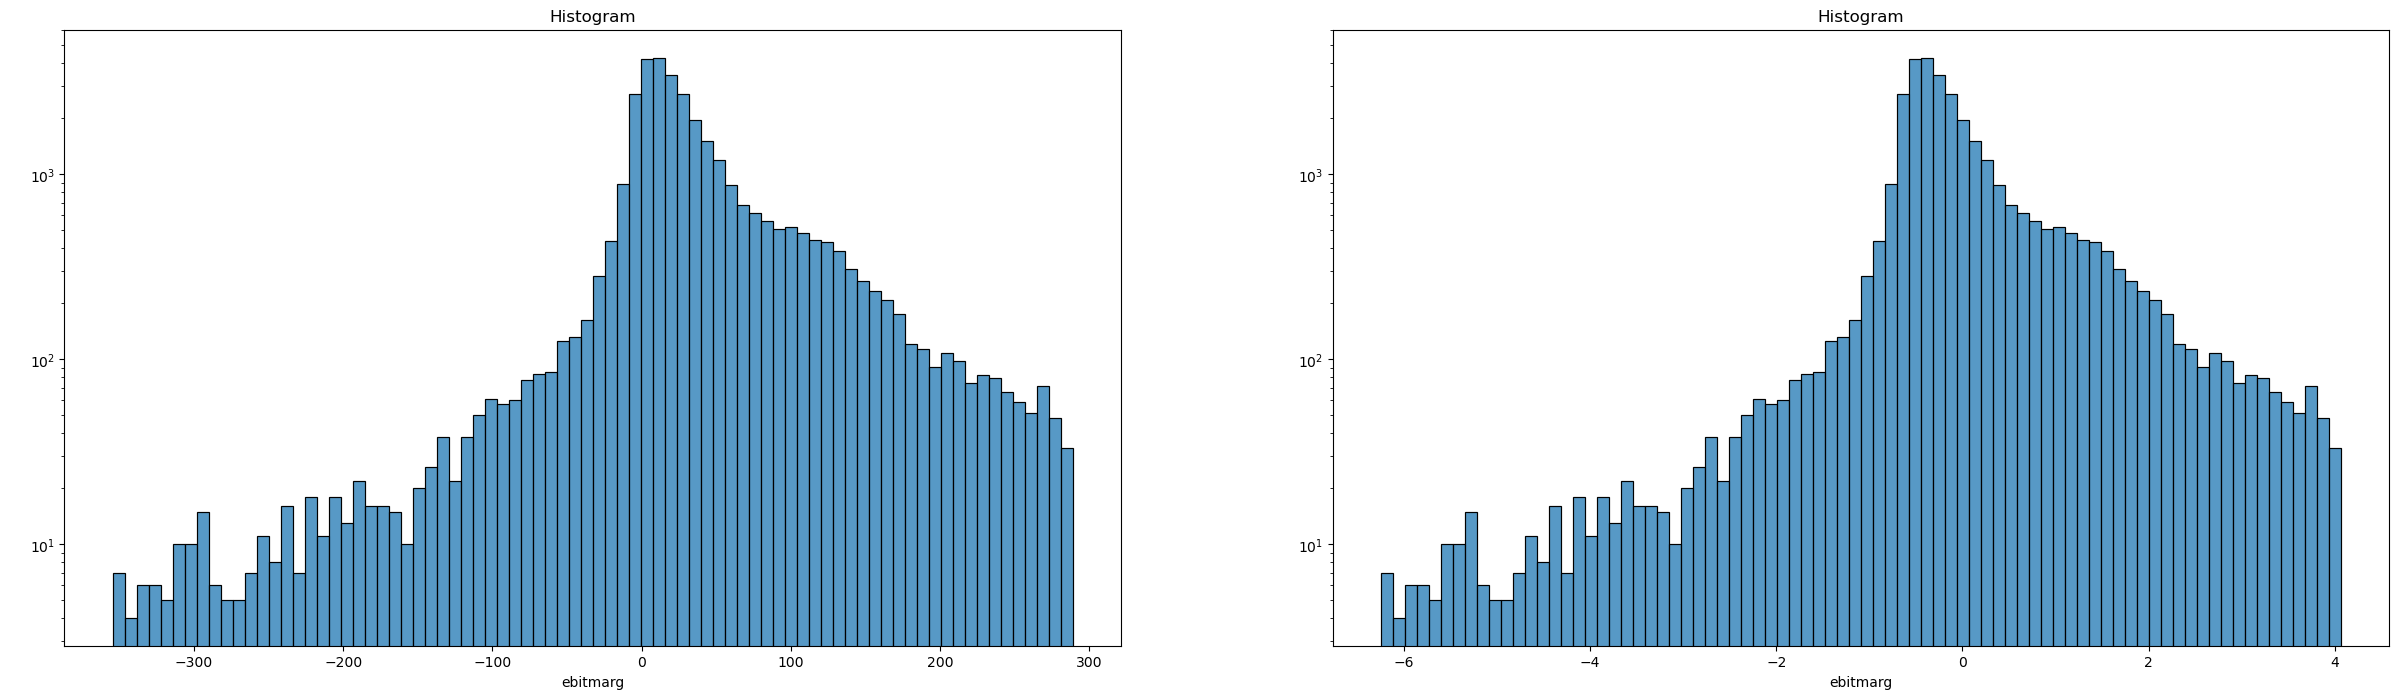

### shouts

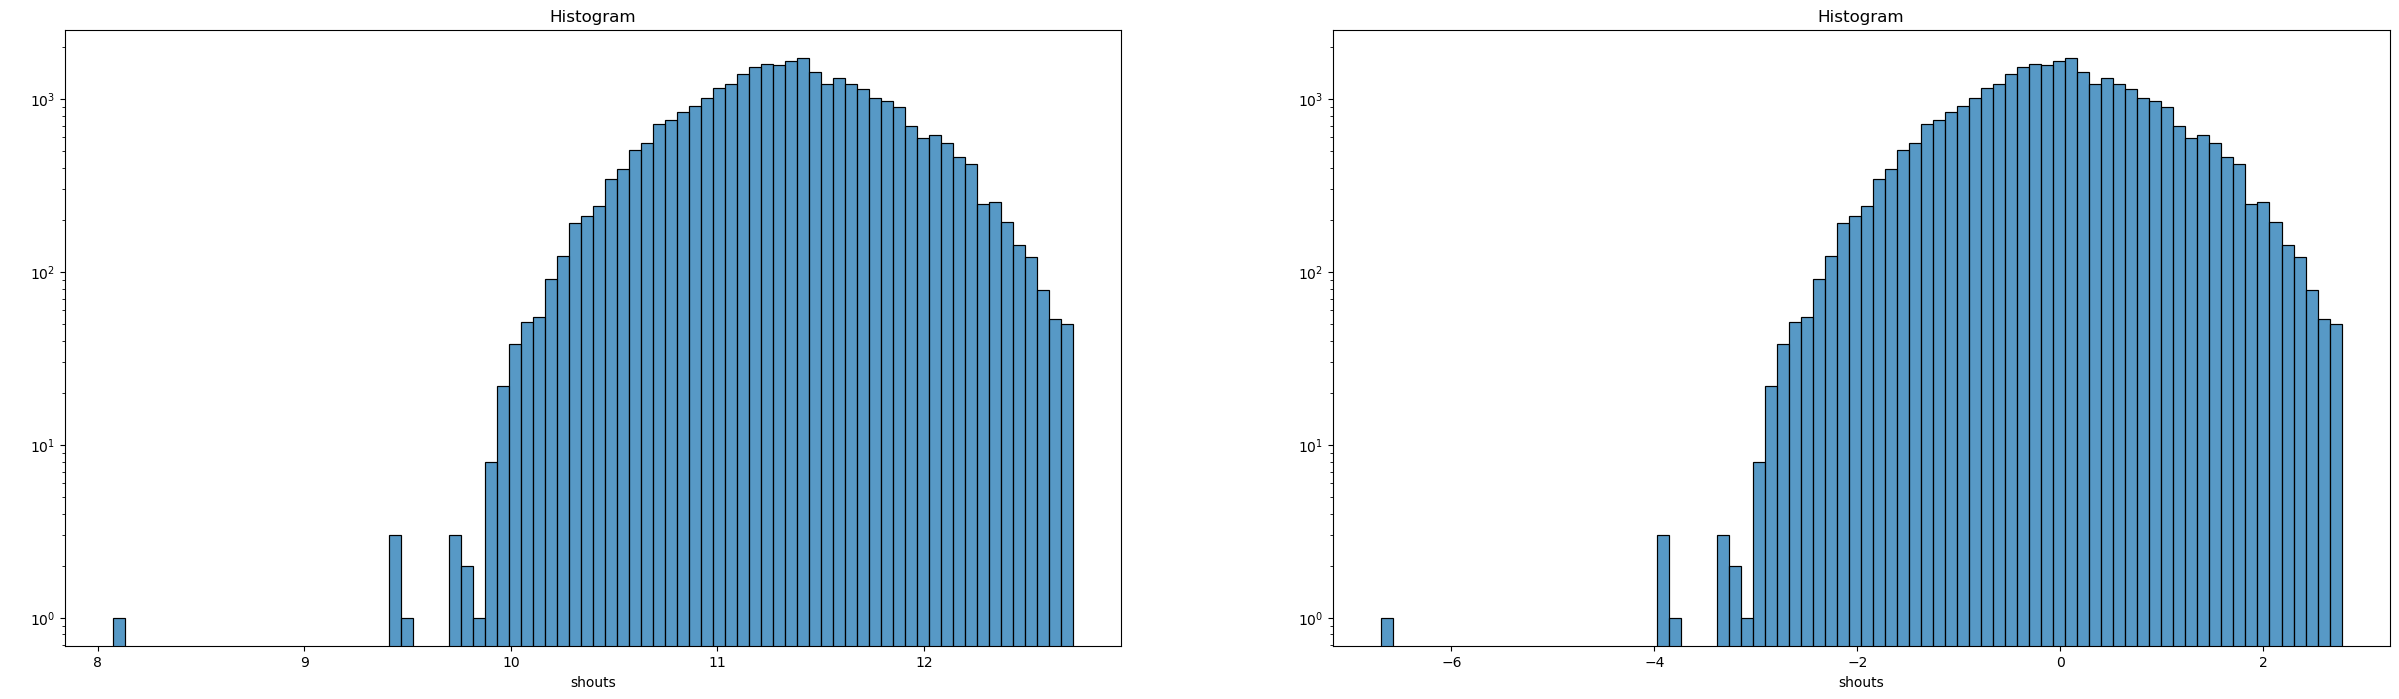

### mc

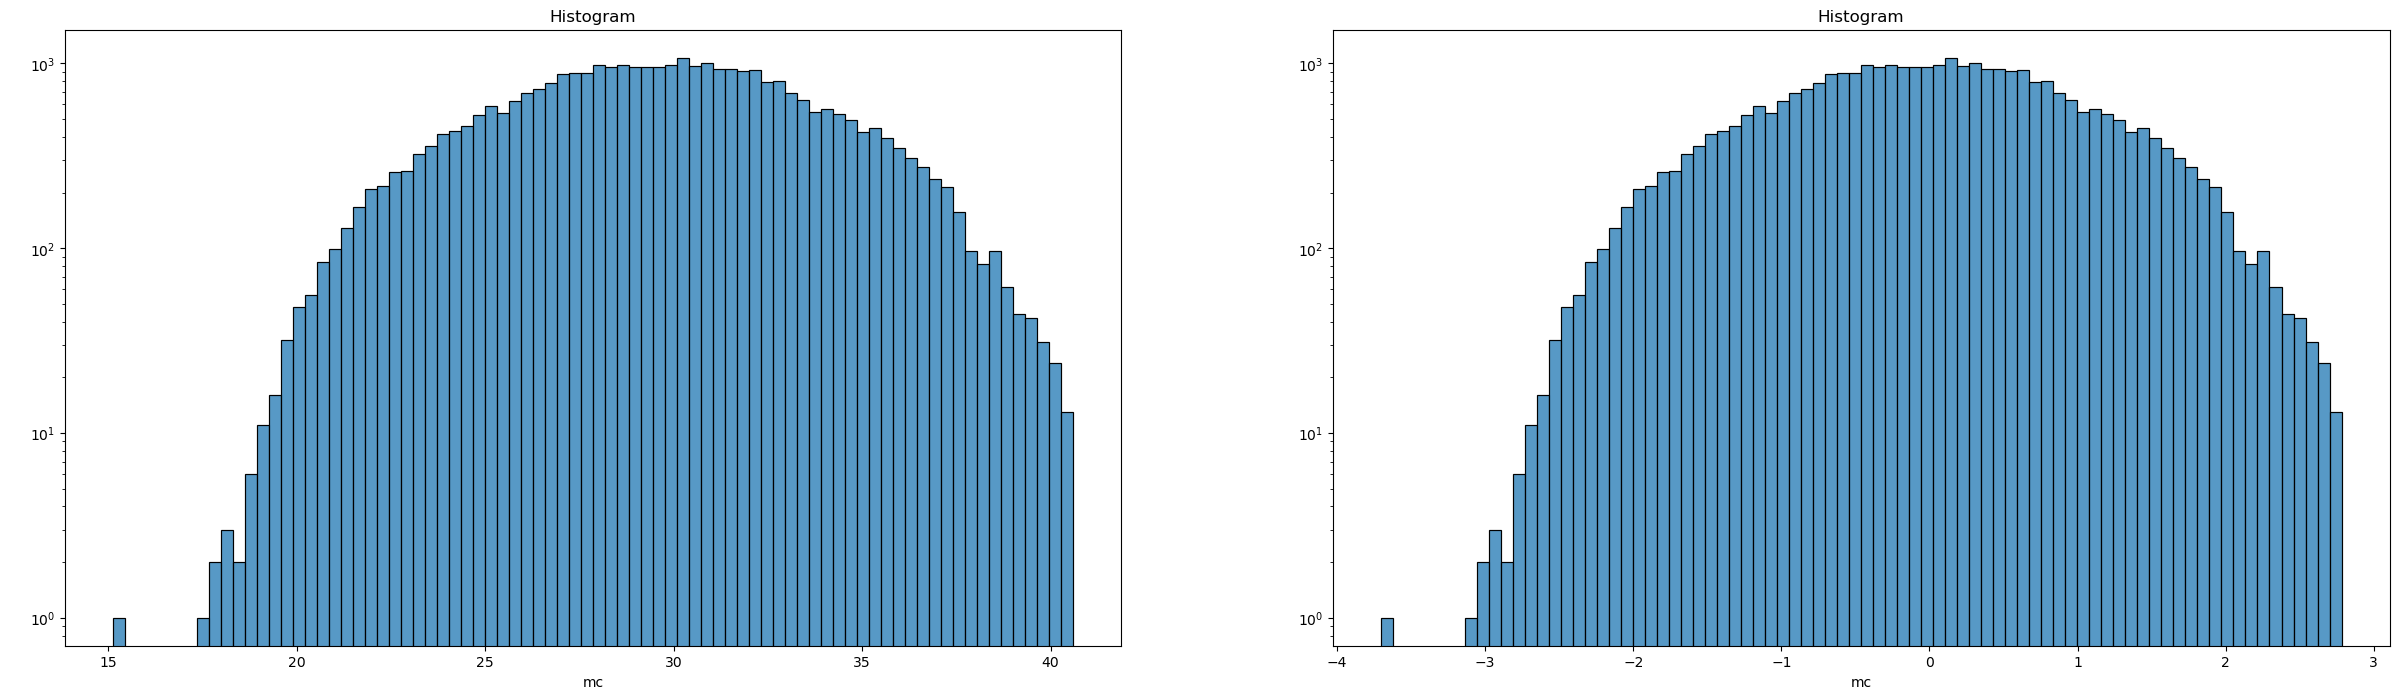

### ptbvps

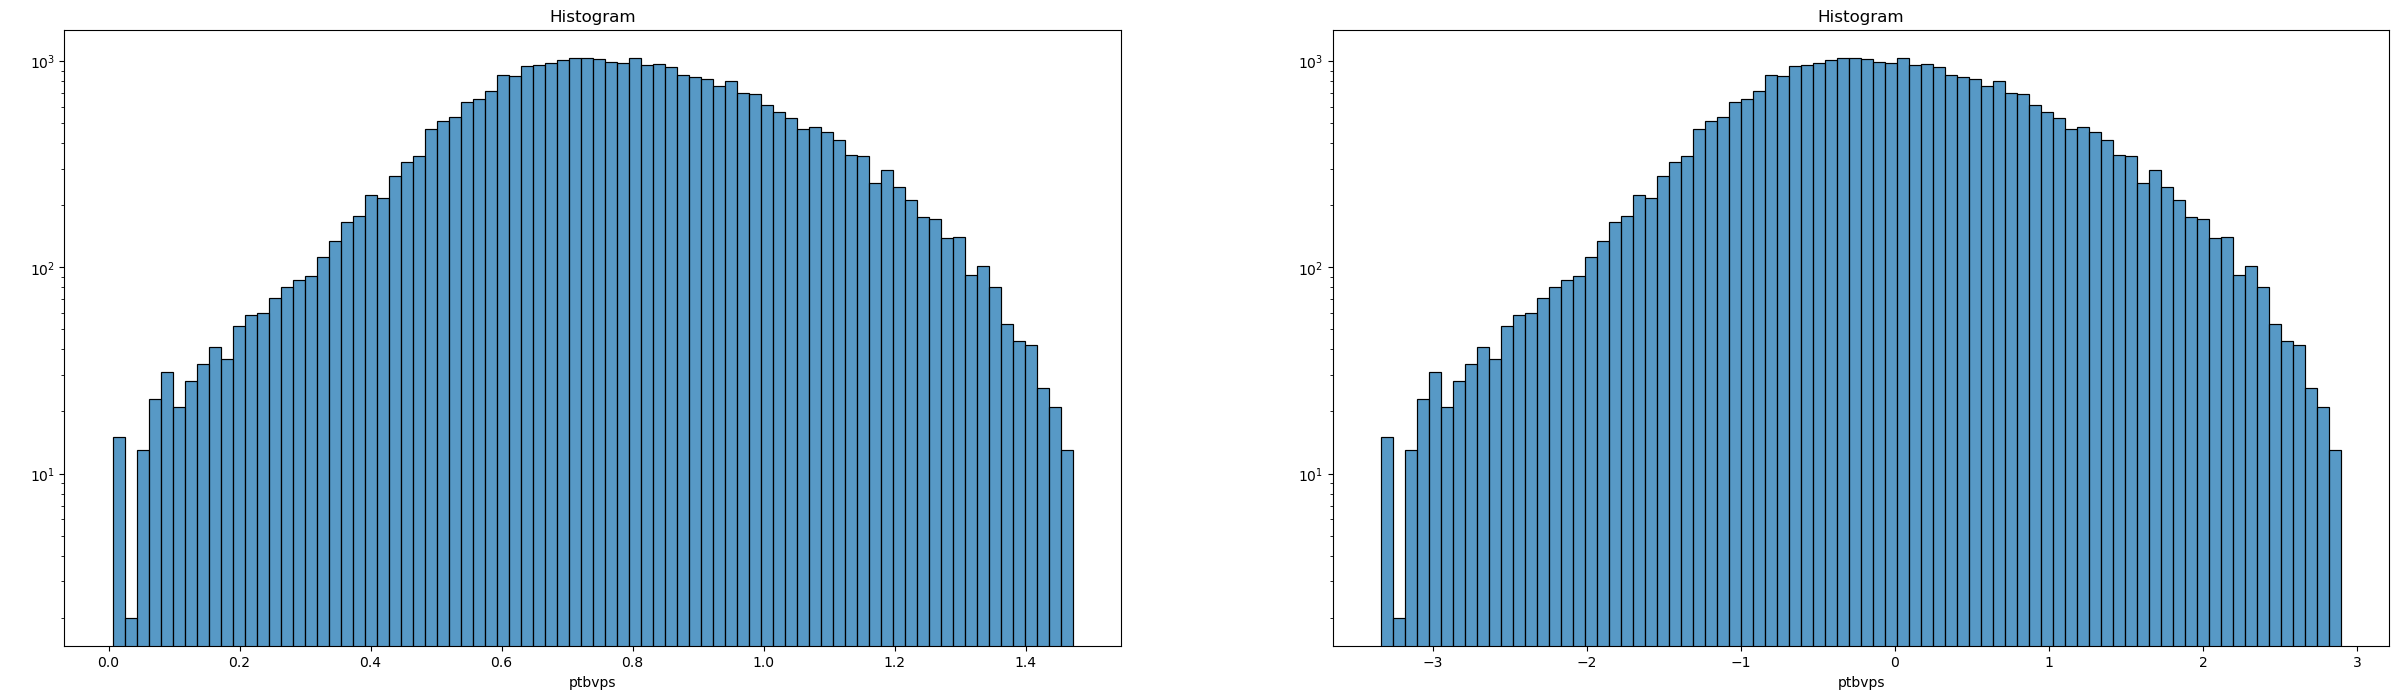

### oips

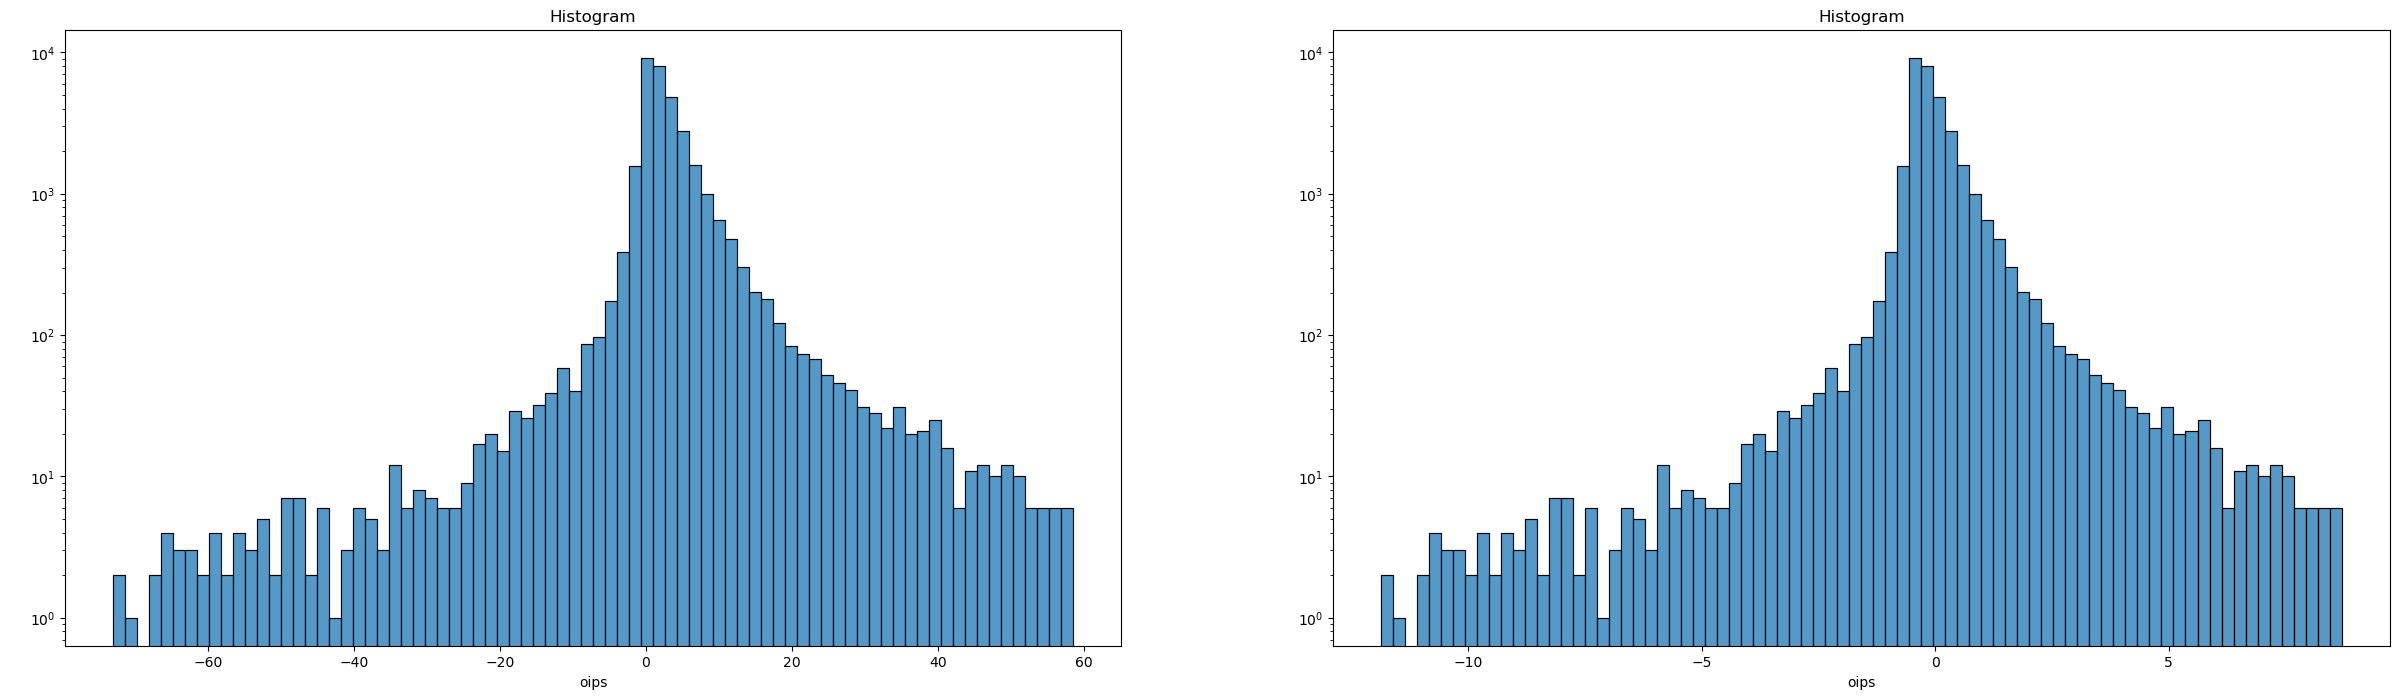

### cfps

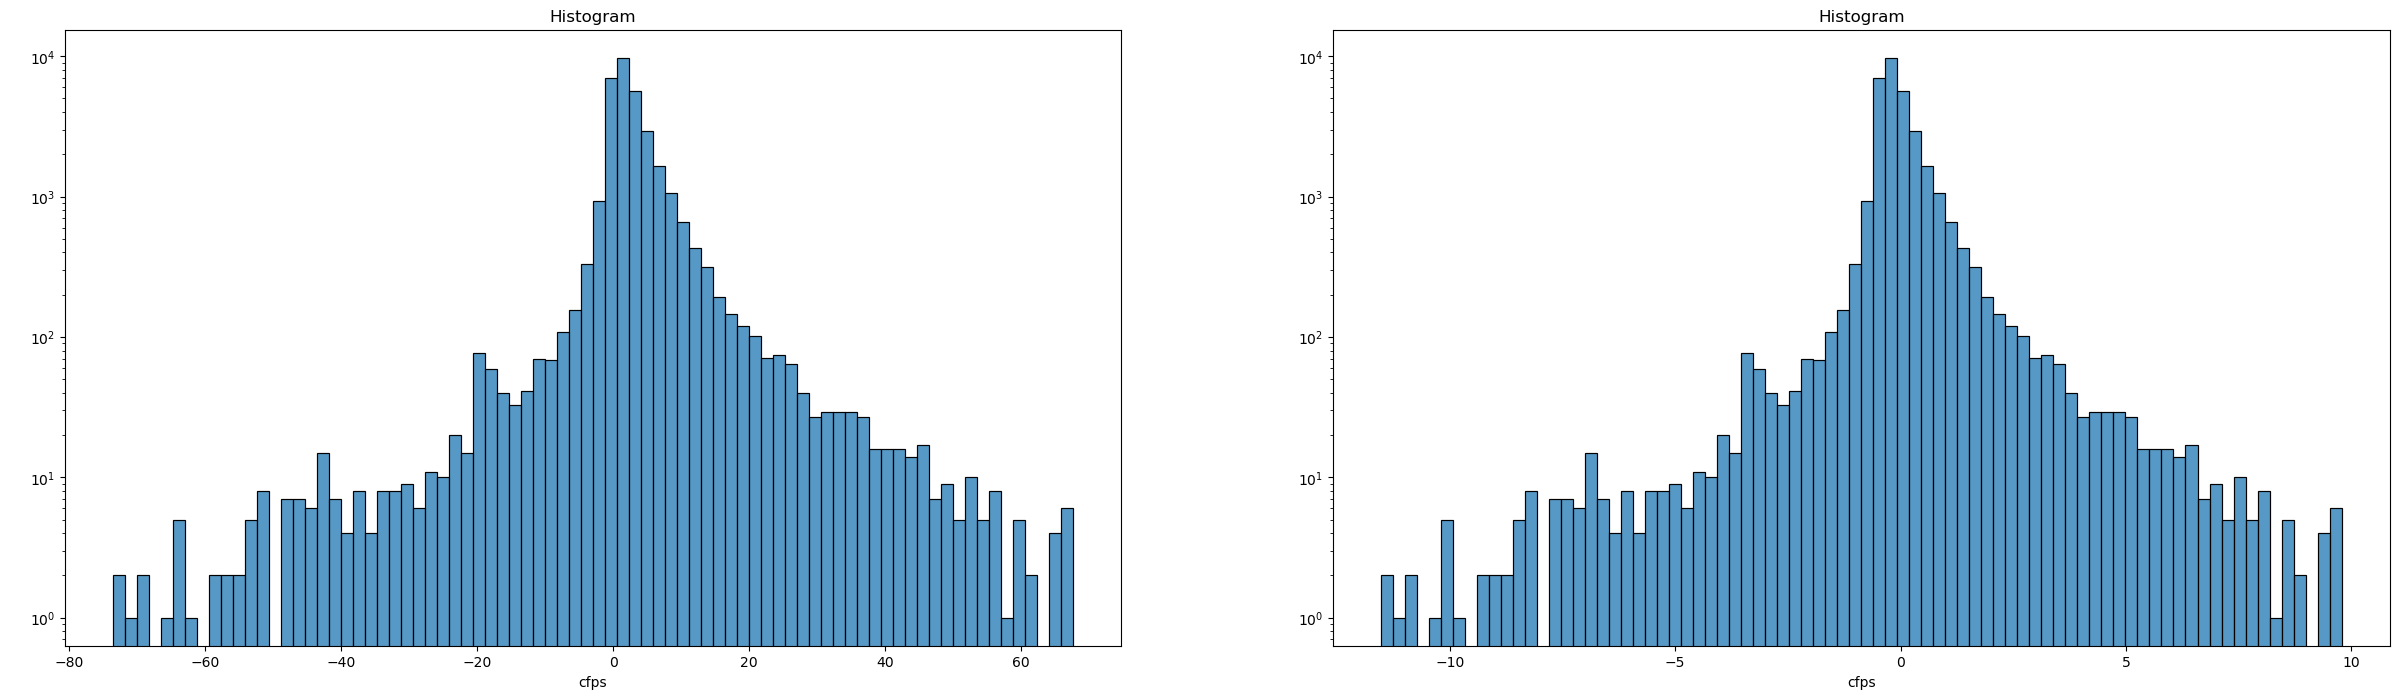

### ros_c

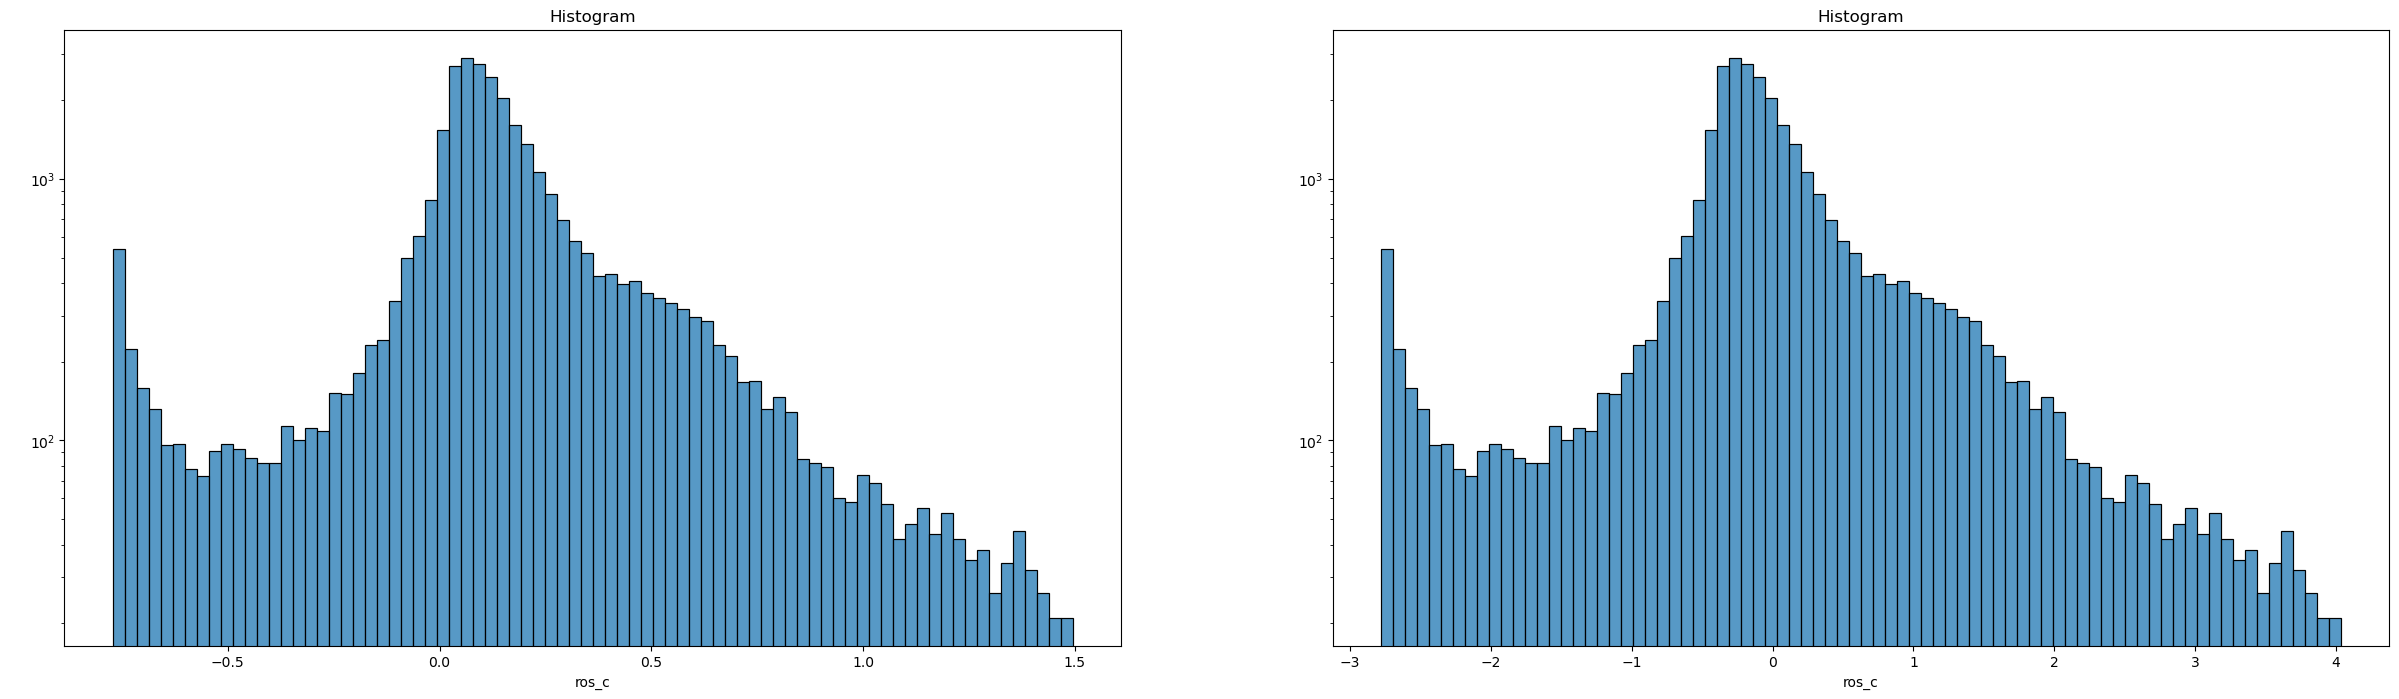

### prof_c

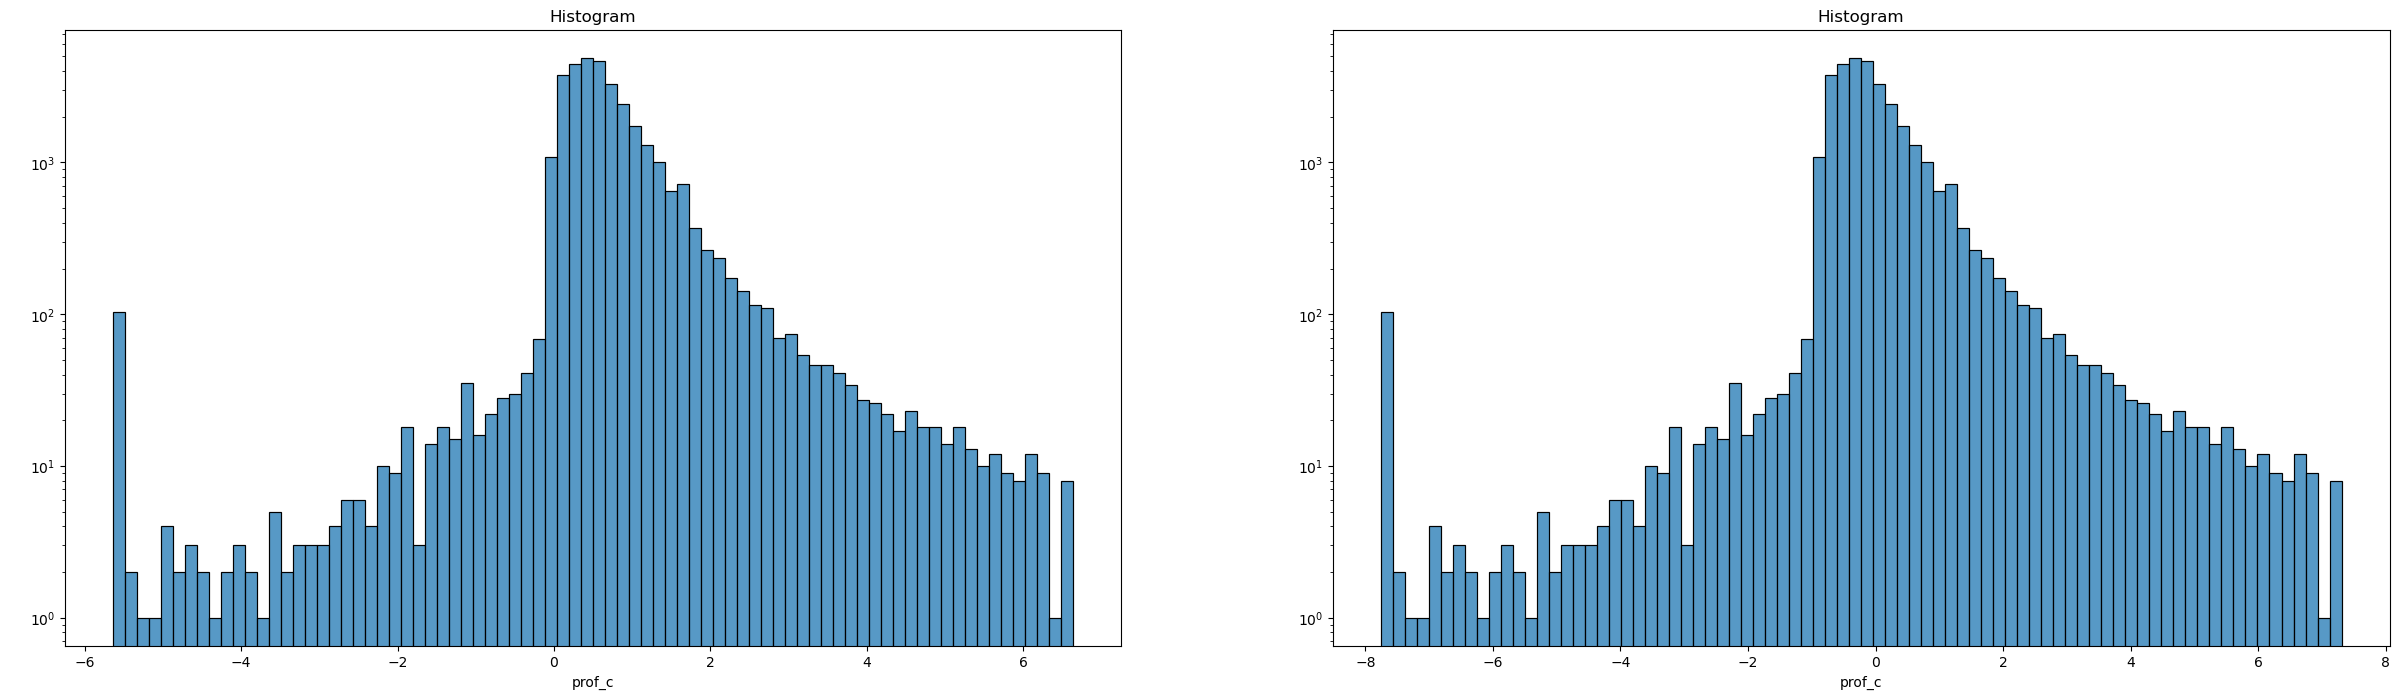

### finlev_c

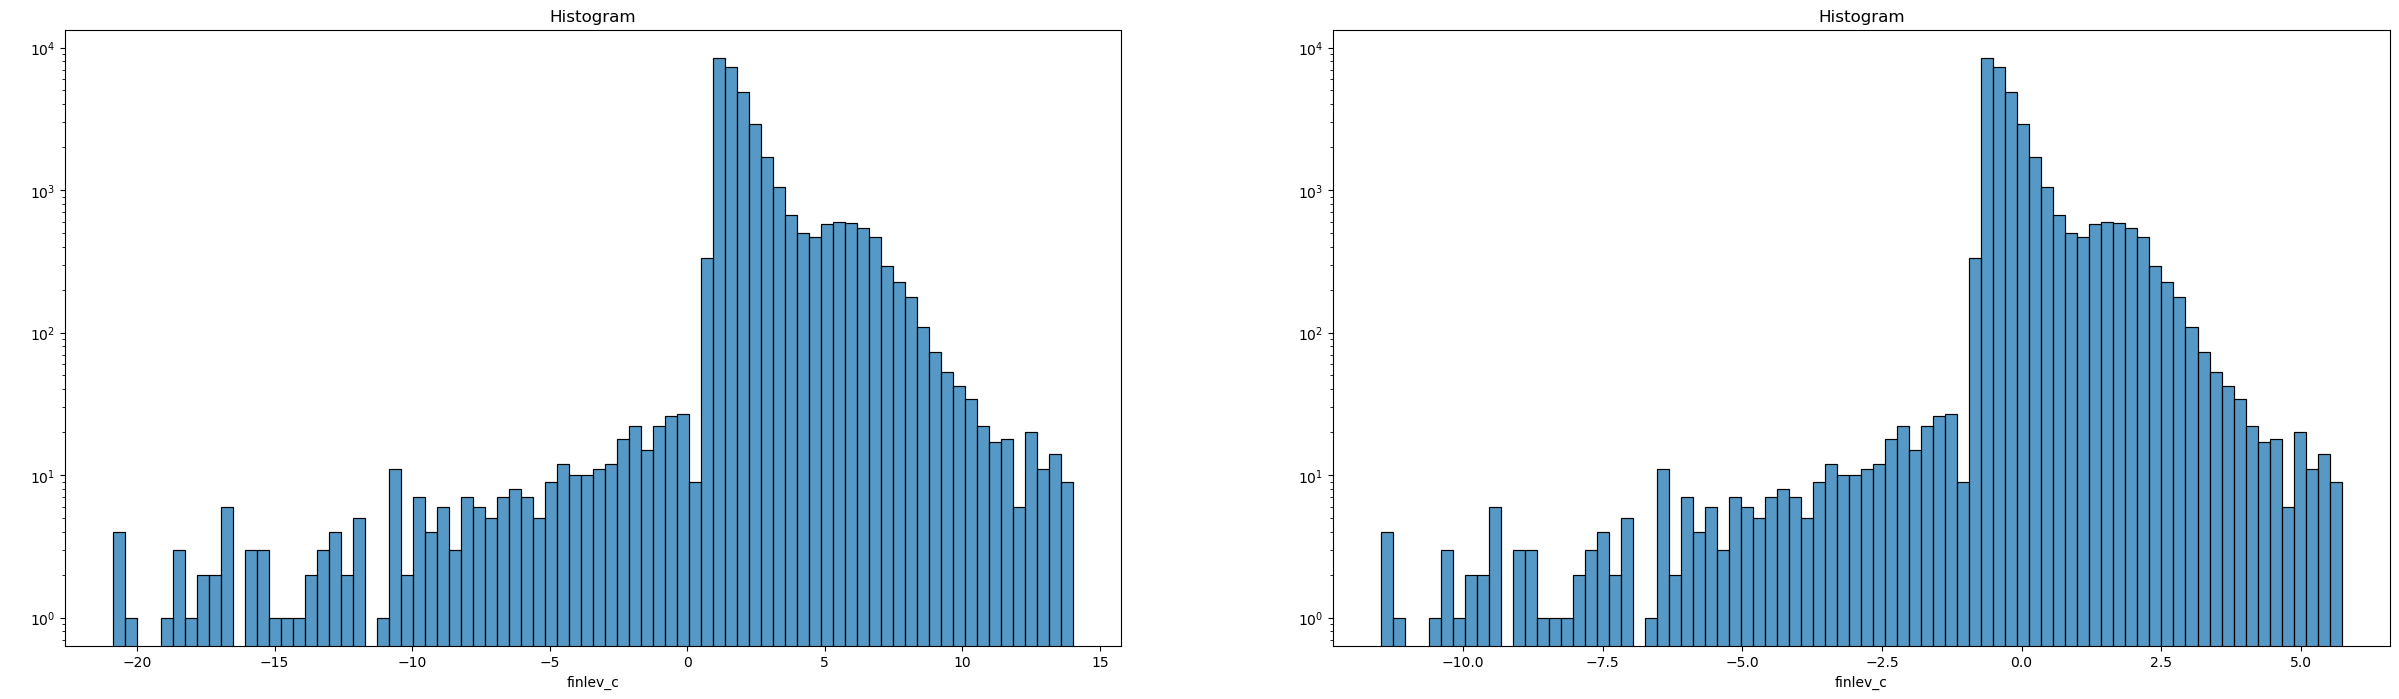

### inc_days

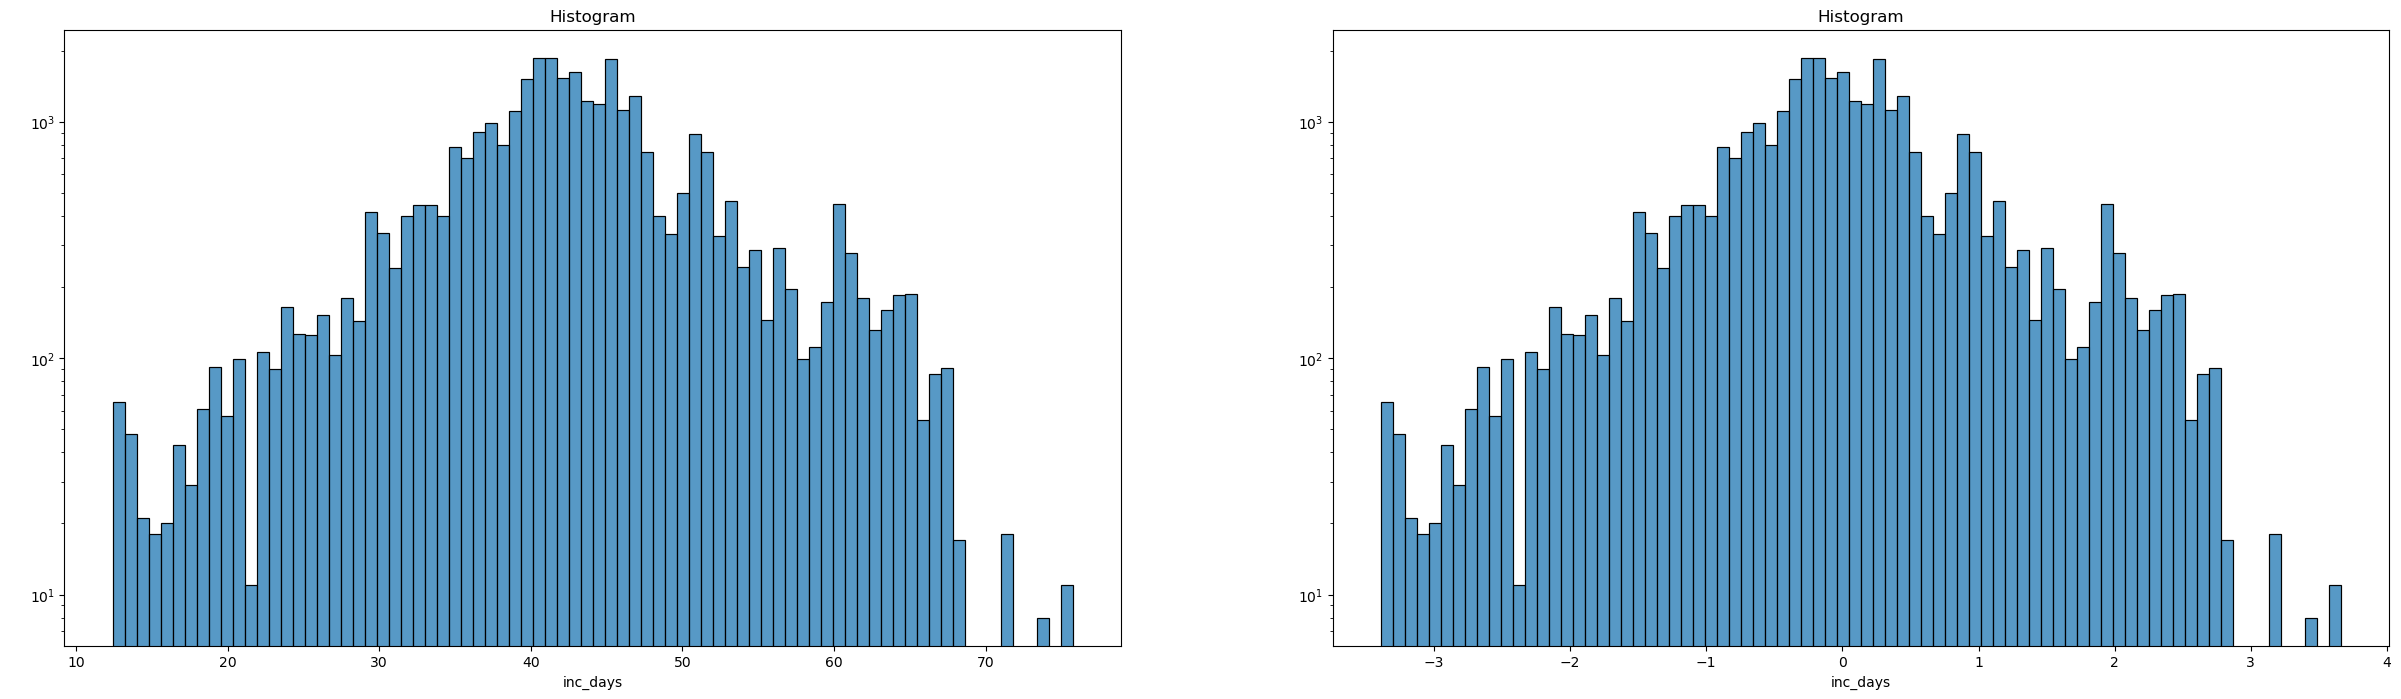

### ipo_days

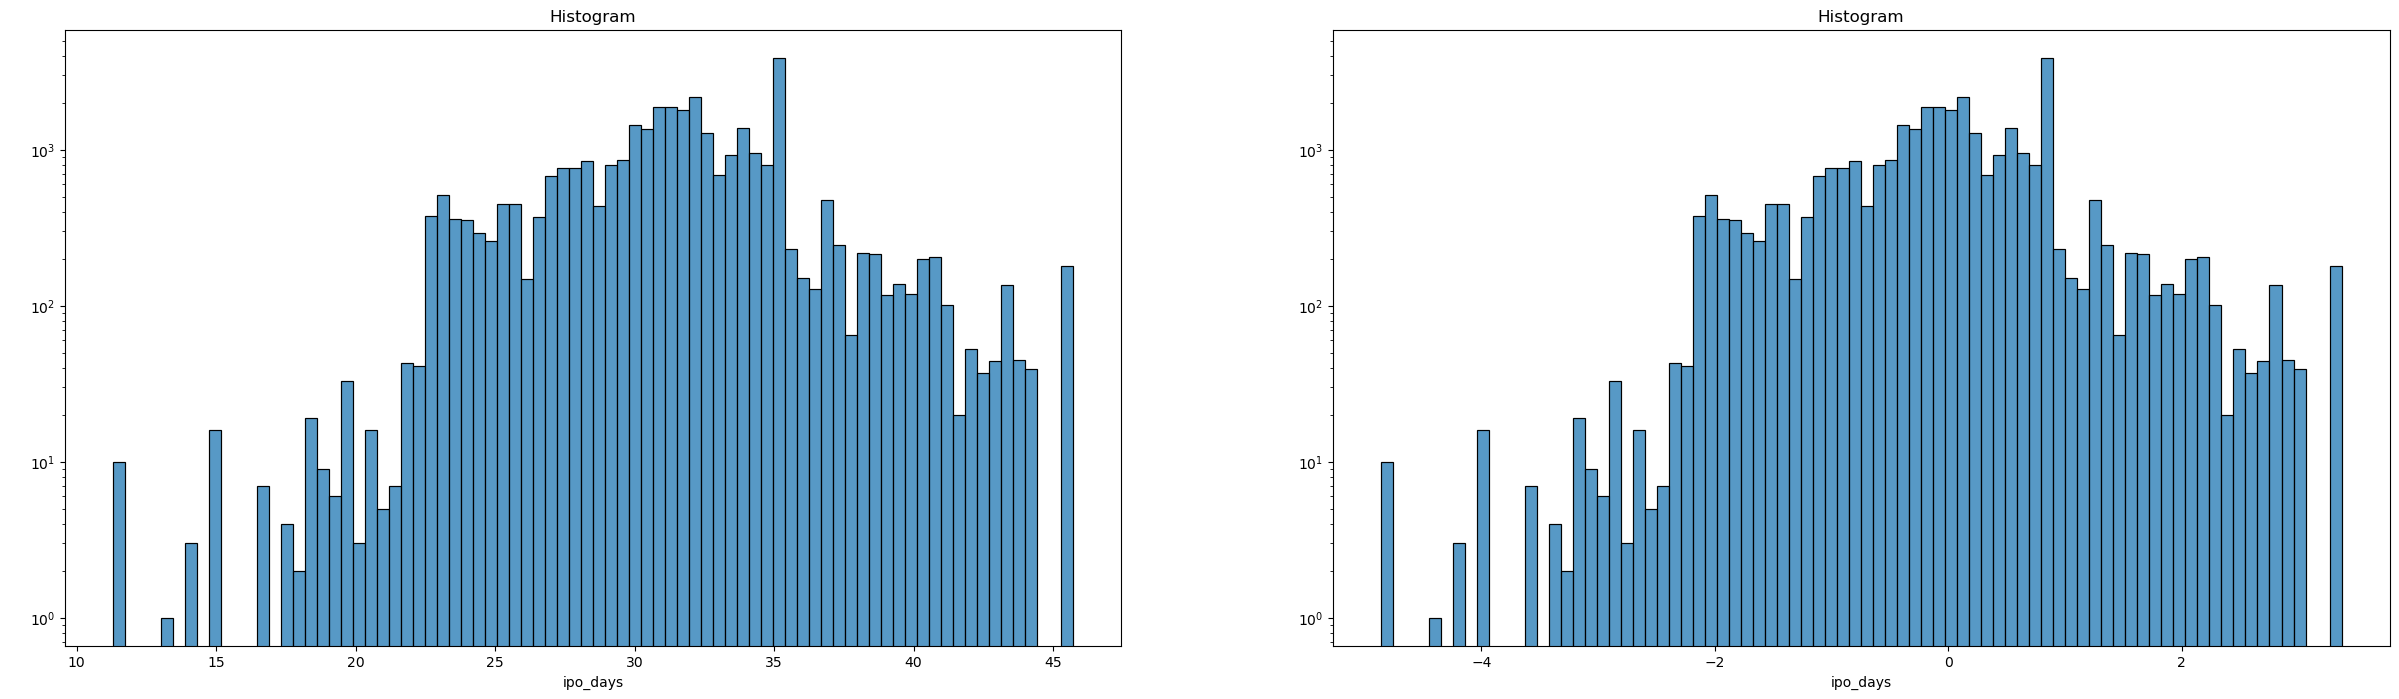

In [17]:
for feature in var_num:
    display(Markdown("### {feature}".format(feature=feature)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 8)

    # histogram original data
    sns.histplot(data_set_corrected[feature], log_scale = (False, True), bins = 80, ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel(' ')
    ax1.set_title('Histogram')

    # histogram log-transformed data
    sns.histplot(data_set_scaled[feature], log_scale = (False, True), bins = 80, ax=ax2)
    ax2.set_xlabel(feature)
    ax2.set_ylabel(' ')
    ax2.set_title('Histogram')

    plt.show()

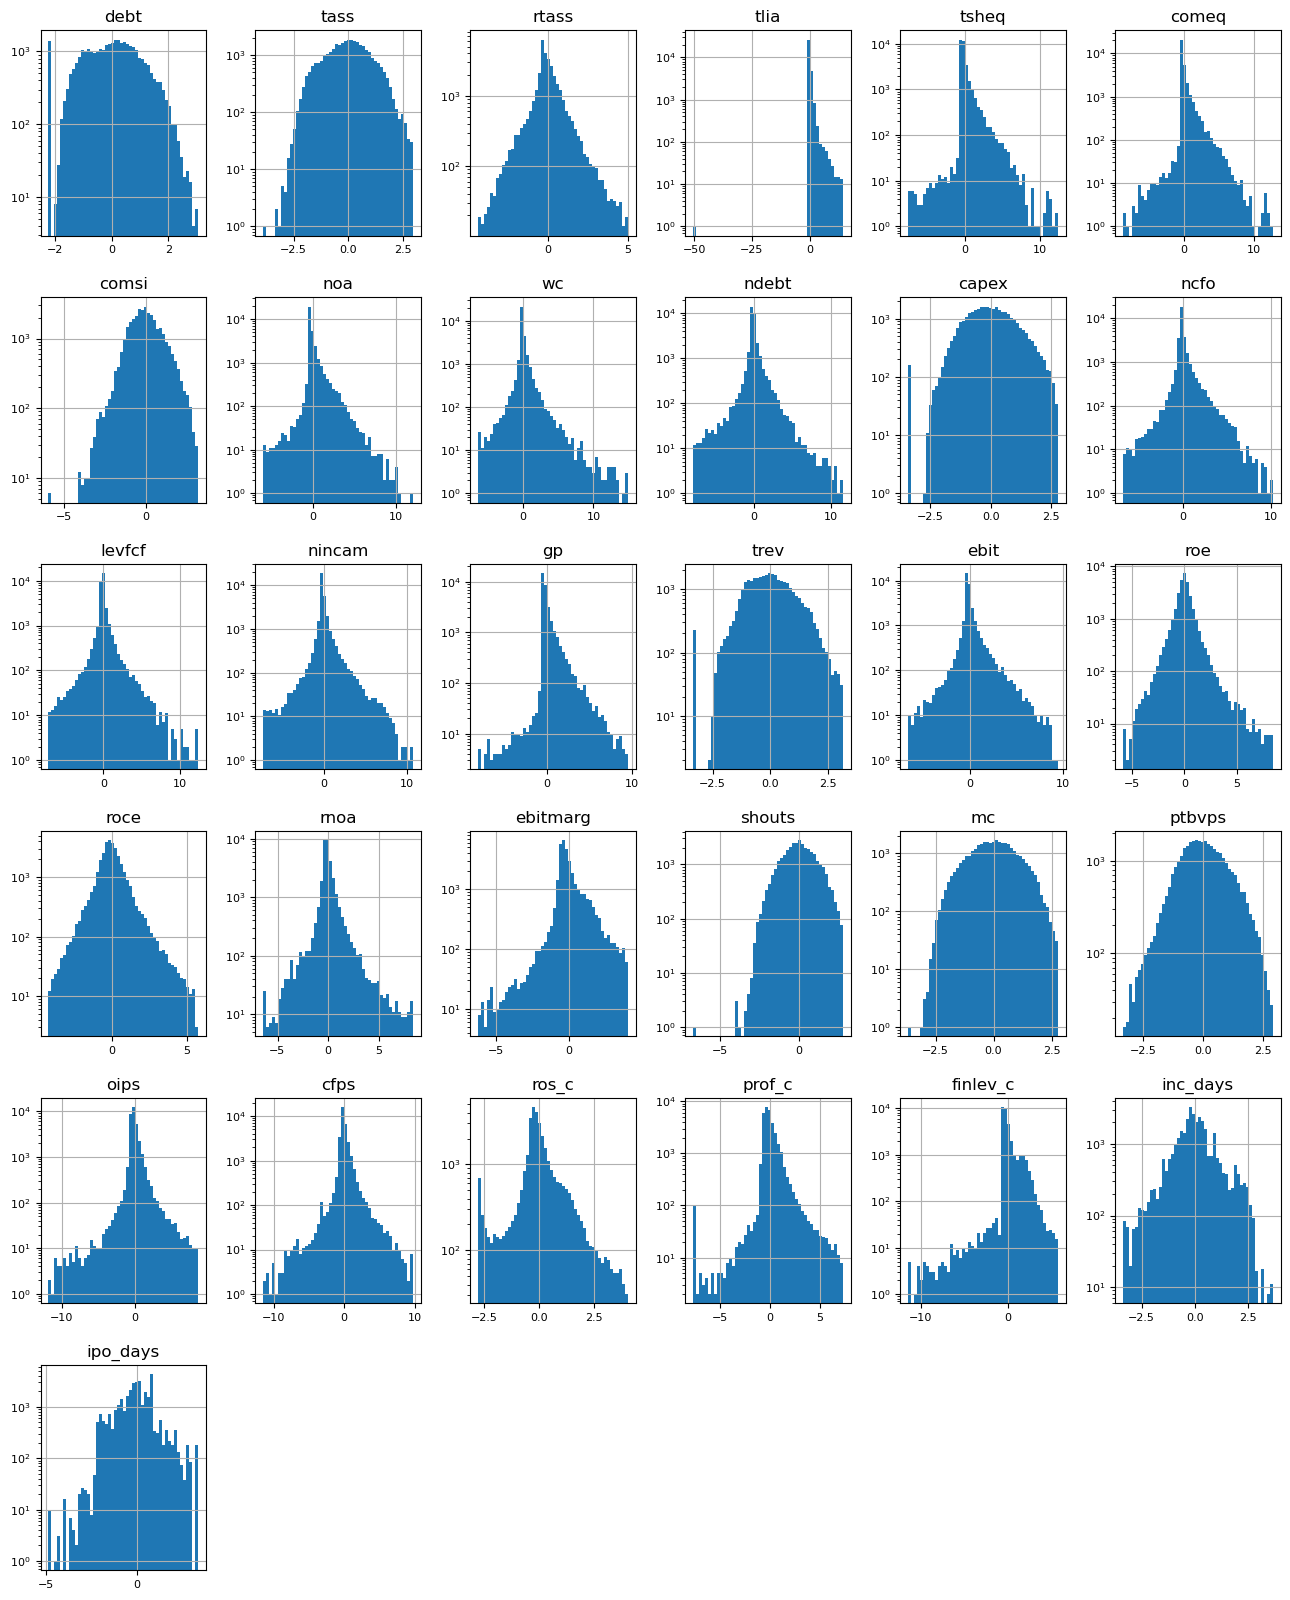

In [18]:
data_set_scaled[var_num].hist(figsize=(16, 20), log=True, bins=50, xlabelsize=8, ylabelsize=8);

In [19]:
data_set_scaled.describe()

,year,tau_cop_3y,tau_cop_5y,rot_target_ori,tau_target_ori,year_hor,tau_target_hor,rot_target_hor,debt,tass,rtass,tlia,tsheq,comeq,comsi,noa,wc,ndebt,capex,ncfo,levfcf,nincam,gp,trev,ebit,roe,roce,rnoa,ebitmarg,shouts,mc,ptbvps,oips,cfps,ros_c,prof_c,finlev_c,inc_days,ipo_days
count,32597.000000,32597.000000,32597.000000,32597.000000,32597.000000,32597.000000,32597.000000,32597.000000,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04,3.259700e+04
mean,2011.463632,0.286209,0.282392,50.426726,0.291295,2012.463632,0.300977,53.303678,-3.898740e-17,1.468763e-16,-1.156646e-17,5.875357e-17,-6.027772e-17,1.401871e-17,-2.204021e-16,6.317955e-18,1.746719e-17,6.455213e-17,-1.571076e-16,7.763762e-17,1.886020e-18,-5.166418e-17,2.150829e-17,6.771758e-16,2.930782e-18,9.155074e-18,1.555954e-16,3.142629e-17,-1.600231e-16,-2.260806e-16,-1.164534e-15,-1.172049e-16,-1.204192e-16,-1.394684e-16,-1.981215e-16,-5.407216e-17,3.154805e-17,5.358171e-17,3.012523e-16
std,5.268878,0.152440,0.149763,80.904804,0.161583,5.268878,0.159084,82.237644,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,2001.000000,-0.133399,-0.109982,0.000000,-0.224582,2002.000000,-0.224582,0.000000,-2.241748e+00,-3.914951e+00,-4.345790e+00,-5.057620e+01,-7.644501e+00,-8.751997e+00,-5.970707e+00,-5.970918e+00,-6.360878e+00,-7.887529e+00,-3.429510e+00,-6.803773e+00,-7.190877e+00,-7.326425e+00,-8.137943e+00,-3.354027e+00,-6.661408e+00,-5.904271e+00,-4.236710e+00,-6.435061e+00,-6.248931e+00,-6.696320e+00,-3.705014e+00,-3.336820e+00,-1.186716e+01,-1.152723e+01,-2.780290e+00,-7.759189e+00,-1.147161e+01,-3.391343e+00,-4.862635e+00
25%,2007.000000,0.169156,0.162340,0.000000,0.179248,2008.000000,0.194278,0.000000,-7.198020e-01,-6.756170e-01,-3.734995e-01,-3.655799e-01,-4.538944e-01,-4.503673e-01,-6.457637e-01,-4.553725e-01,-2.648660e-01,-1.874938e-01,-6.983325e-01,-3.211749e-01,-1.813649e-01,-2.257583e-01,-4.966346e-01,-7.030581e-01,-2.865951e-01,-4.104834e-01,-4.848418e-01,-3.274969e-01,-4.911428e-01,-6.694956e-01,-6.976055e-01,-6.701546e-01,-3.952432e-01,-3.612943e-01,-3.606970e-01,-4.812531e-01,-5.301115e-01,-5.342572e-01,-5.281778e-01
50%,2012.000000,0.300733,0.295569,0.000000,0.307467,2013.000000,0.318904,0.000000,5.835388e-02,2.282614e-02,-1.088395e-01,-2.876474e-01,-3.294613e-01,-3.267471e-01,-3.951187e-02,-3.284074e-01,-1.895810e-01,-1.209050e-01,-3.394430e-02,-2.307738e-01,-1.240651e-01,-1.717728e-01,-3.272129e-01,-3.759933e-02,-2.083286e-01,-2.776603e-02,-6.912319e-02,-1.308232e-01,-2.341444e-01,-1.171337e-02,6.585432e-03,-3.527370e-02,-1.646574e-01,-1.545942e-01,-1.131276e-01,-1.643172e-01,-2.976875e-01,-4.771022e-02,4.032626e-02
75%,2016.000000,0.402276,0.399405,180.000000,0.408183,2017.000000,0.416072,180.000000,6.980038e-01,6.838687e-01,3.925594e-01,-4.810527e-02,2.212629e-02,2.445716e-02,6.082108e-01,5.410131e-02,3.735589e-02,7.528323e-02,6.719438e-01,4.971517e-02,6.371911e-02,3.376774e-02,6.624705e-02,6.581848e-01,4.681166e-02,3.554996e-01,4.238180e-01,1.932323e-01,2.859463e-01,6.805019e-01,6.944865e-01,6.698159e-01,2.007258e-01,1.912655e-01,3.288250e-01,2.964230e-01,1.546880e-01,4.592177e-01,6.622036e-01
max,2019.000000,0.696102,0.674719,270.000000,0.748887,2020.000000,0.748887,270.000000,3.053360e+00,2.993713e+00,5.015186e+00,1.439163e+01,1.247815e+01,1.270509e+01,3.214723e+00,1.205038e+01

## ----------------------------------------

## One-Hot Encoding (Categorical Variables)
- applied to nominal categorical variables as they can not be ordered
- transforming industry classifiers (feature variable) to dummy variables
- transforming copula families (target varibale) to dummy variables

### Industry Classifiers

In [20]:
#data_set_naics = data_set_scaled['naics'].copy()
data_set_scaled = pd.get_dummies(data_set_scaled, columns=['naics'])

data_set_scaled = data_set_scaled.rename(columns={'naics_Accommodation and Food Services': 'naics_1',
                        'naics_Administrative and Support and Waste Management and Remediation Services': 'naics_2',
                        'naics_Agriculture, Forestry, Fishing and Hunting': 'naics_3',
                        'naics_Arts, Entertainment, and Recreation': 'naics_4',
                        'naics_Construction': 'naics_5',
                        'naics_Educational Services': 'naics_6',
                        'naics_Finance and Insurance': 'naics_7',
                        'naics_Health Care and Social Assistance': 'naics_8',
                        'naics_Information': 'naics_9',
                        'naics_Manufacturing': 'naics_10',
                        'naics_Mining, Quarrying, and Oil and Gas Extraction': 'naics_11',
                        'naics_Other Services (except Public Administration)': 'naics_12',
                        'naics_Professional, Scientific, and Technical Services': 'naics_13',
                        'naics_Public Administration': 'naics_14',
                        'naics_Real Estate and Rental and Leasing': 'naics_15',
                        'naics_Retail Trade': 'naics_16',
                        'naics_Transportation and Warehousing': 'naics_17',
                        'naics_Utilities': 'naics_18',
                        'naics_Wholesale Trade': 'naics_19'})
#data_set_scaled['naics'] = data_set_naics
data_set_scaled.head()

,ric,year,symbol,tau_cop_3y,tau_cop_5y,fam_target_ori,rot_target_ori,tau_target_ori,par_target_ori,year_hor,tau_target_hor,fam_target_hor,rot_target_hor,par_target_hor,debt,tass,rtass,tlia,tsheq,comeq,comsi,noa,wc,ndebt,capex,ncfo,levfcf,nincam,gp,trev,ebit,roe,roce,rnoa,ebitmarg,shouts,mc,ptbvps,oips,cfps,ros_c,prof_c,finlev_c,inc_days,ipo_days,naics_1,naics_2,naics_3,naics_4,naics_5,naics_6,naics_7,naics_8,naics_9,naics_10,naics_11,naics_12,naics_13,naics_14,naics_15,naics_16,naics_17,naics_18,naics_19
3,A.ITC,2004,A,0.485946,0.425203,frank,0,0.462612,[[5.09499262]],2005,0.371968,frank,0,[[3.78686423]],0.724119,0.934727,-0.322801,0.034067,0.627112,0.667573,1.636099,0.057001,2.209911,-3.080019,0.455358,0.377481,0.557085,0.373503,0.872499,1.050527,-0.209038,-0.371659,-0.617933,-0.347687,-0.538646,1.750710,1.375897,0.207180,-0.428181,-0.337362,-0.417621,-0.093411,-0.366484,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,A.ITC,2005,A,0.451243,0.457525,frank,0,0.371968,[[3.78686423]],2006,0.384465,gaussian,0,[[0.56787014]],-2.241748,0.904411,-0.125101,-0.058830,0.769603,0.815436,1.675887,-0.056930,1.888018,-6.019859,0.675604,0.600123,0.767432,0.308105,0.972029,1.067135,0.062047,-0.222672,-0.369045,-0.020705,-0.396042,1.757078,1.518272,0.404743,-0.353201,-0.305037,-0.260991,-0.126606,-0.492430,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,A.ITC,2006,A,0.396258,0.457678,gaussian,0,0.384465,[[0.56787014]],2007,0.379842,gumbel,180,[[1.61249331]],0.842004,0.951377,2.710760,0.048729,0.649254,0.690543,1.711115,0.149258,1.810818,-2.022006,0.850563,0.342006,0.389434,4.636146,1.114784,1.102818,0.277253,1.909661,-0.148505,0.222685,-0.260717,1.626717,1.474888,0.418459,-0.261741,0.276630,-0.135573,0.056585,-0.359963,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,A.ITC,2007,A,0.368536,0.425415,gumbel,180,0.379842,[[1.61249331]],2008,0.573060,gumbel,180,[[2.34224801]],0.994720,0.964709,0.661017,0.108090,0.532532,0.569482,1.734718,0.262343,1.460667,-0.066225,0.762686,0.667285,0.818548,0.785464,1.261756,1.154780,0.396193,0.581183,-0.077263,0.151476,-0.209164,1.562732,1.463126,0.575732,-0.193956,-0.061476,-0.089937,0.288953,-0.249367,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,A.ITC,2008,A,0.449823,0.429873,gumbel,180,0.573060,[[2.34224801]],2009,0.557232,student,0,[[0.76773438]\n [2.88717691]],1.003267,0.924343,0.809965,0.120623,0.338112,0.368001,1.748967,0.218192,1.327788,0.058889,0.762686,0.461669,0.570003,0.868561,1.366715,1.193338,0.611192,0.944631,0.183405,0.339715,-0.081537,1.524972,1.129583,0.123389,-0.061202,0.012943,0.020378,0.694797,-0.112826,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Copula Familes

In [21]:
data_set_fam_target_hor = data_set_scaled['fam_target_hor'].copy()
data_set_fam_target_ori = data_set_scaled['fam_target_ori'].copy()
data_set_scaled = pd.get_dummies(data_set_scaled, columns=['fam_target_hor'])
data_set_scaled = pd.get_dummies(data_set_scaled, columns=['fam_target_ori'])
data_set_scaled['fam_target_hor'] = data_set_fam_target_hor
data_set_scaled['fam_target_ori'] = data_set_fam_target_ori

data_set_scaled.head()

,ric,year,symbol,tau_cop_3y,tau_cop_5y,rot_target_ori,tau_target_ori,par_target_ori,year_hor,tau_target_hor,rot_target_hor,par_target_hor,debt,tass,rtass,tlia,tsheq,comeq,comsi,noa,wc,ndebt,capex,ncfo,levfcf,nincam,gp,trev,ebit,roe,roce,rnoa,ebitmarg,shouts,mc,ptbvps,oips,cfps,ros_c,prof_c,finlev_c,inc_days,ipo_days,naics_1,naics_2,naics_3,naics_4,naics_5,naics_6,naics_7,naics_8,naics_9,naics_10,naics_11,naics_12,naics_13,naics_14,naics_15,naics_16,naics_17,naics_18,naics_19,fam_target_hor_clayton,fam_target_hor_frank,fam_target_hor_gaussian,fam_target_hor_gumbel,fam_target_hor_indep,fam_target_hor_joe,fam_target_hor_student,fam_target_ori_clayton,fam_target_ori_frank,fam_target_ori_gaussian,fam_target_ori_gumbel,fam_target_ori_indep,fam_target_ori_joe,fam_target_ori_student,fam_target_hor,fam_target_ori
3,A.ITC,2004,A,0.485946,0.425203,0,0.462612,[[5.09499262]],2005,0.371968,0,[[3.78686423]],0.724119,0.934727,-0.322801,0.034067,0.627112,0.667573,1.636099,0.057001,2.209911,-3.080019,0.455358,0.377481,0.557085,0.373503,0.872499,1.050527,-0.209038,-0.371659,-0.617933,-0.347687,-0.538646,1.750710,1.375897,0.207180,-0.428181,-0.337362,-0.417621,-0.093411,-0.366484,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,frank,frank
4,A.ITC,2005,A,0.451243,0.457525,0,0.371968,[[3.78686423]],2006,0.384465,0,[[0.56787014]],-2.241748,0.904411,-0.125101,-0.058830,0.769603,0.815436,1.675887,-0.056930,1.888018,-6.019859,0.675604,0.600123,0.767432,0.308105,0.972029,1.067135,0.062047,-0.222672,-0.369045,-0.020705,-0.396042,1.757078,1.518272,0.404743,-0.353201,-0.305037,-0.260991,-0.126606,-0.492430,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,gaussian,frank
5,A.ITC,2006,A,0.396258,0.457678,0,0.384465,[[0.56787014]],2007,0.379842,180,[[1.61249331]],0.842004,0.951377,2.710760,0.048729,0.649254,0.690543,1.711115,0.149258,1.810818,-2.022006,0.850563,0.342006,0.389434,4.636146,1.114784,1.102818,0.277253,1.909661,-0.148505,0.222685,-0.260717,1.626717,1.474888,0.418459,-0.261741,0.276630,-0.135573,0.056585,-0.359963,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,gumbel,gaussian
6,A.ITC,2007,A,0.368536,0.425415,180,0.379842,[[1.61249331]],2008,0.573060,180,[[2.34224801]],0.994720,0.964709,0.661017,0.108090,0.532532,0.569482,1.734718,0.262343,1.460667,-0.066225,0.762686,0.667285,0.818548,0.785464,1.261756,1.154780,0.396193,0.581183,-0.077263,0.151476,-0.209164,1.562732,1.463126,0.575732,-0.193956,-0.061476,-0.089937,0.288953,-0.249367,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,gumbel,gumbel
7,A.ITC,2008,A,0.449823,0.429873,180,0.573060,[[2.34224801]],2009,0.557232,0,[[0.76773438]\n [2.88717691]],1.003267,0.924343,0.809965,0.120623,0.338112,0.368001,1.748967,0.218192,1.327788,0.058889,0.762686,0.461669,0.570003,0.868561,1.366715,1.193338,0.611192,0.944631,0.183405,0.339715,-0.081537,1.524972,1.129583,0.123389,-0.061202,0.012943,0.020378,0.694797,-0.112826,-0.319891,-0.37766,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,student,gumbel


## ----------------------------------------
## Save Data

In [22]:
print('Amount of observations data set ' + str(len(data_set)))

Amount of observations data set 32597


In [23]:
data_set_scaled.to_csv(path + 'data_artifacts' + slash + 'data_set_e_spx_2-formatted.csv')